In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dicom
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms as tfs
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from collections import defaultdict

In [ ]:
import numpy as np
import pandas as pd

import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import pydicom as dicom
import nibabel as nib
import sys
import glob
import os
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler

c:\Users\User\anaconda3\envs\MRI_NiR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Data

## Обработка исходных файлов

In [6]:
def read_labels_from_file(file_path):
    values = []
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            try:
                value = int(line.split(': ')[1])
            except ValueError:
                value = line.split(': ')[1].strip()  # Если значение не может быть преобразовано в int, оставляем его как строку
            if str(value) in ['3а'  ,'3','3a']:
                value = '3a'
            values.append(value)
    return values

In [7]:
file_path = os.path.join('data_TEST/ID_65', 'labels.txt')

values = read_labels_from_file('data_TEST/ID_89/labels.txt')[::-1]
print(values)

['3a', 4]


In [46]:
def load_tif(x_path, y_path, step=4): # скачивет снимки как они есть
    images = []
    labels = []
    image = Image.open(x_path)

    i = 0
    
    while True:
        try:
            image.seek(i)
            image_array = np.array(image)
            images.append(image_array)
            labels.append(read_labels_from_file(y_path))
            i += 1
        except EOFError:
            break
    
    return images, labels

In [47]:
def load_tif_inv(x_path, y_path, step=4):# скачивет снимки инвертировано по Y
    images = []
    labels = []
    image = Image.open(x_path)

    i = 0
    
    while True:
        try:
            image.seek(i)
            image_array =  np.fliplr(np.array(image))
            images.append(image_array)
            labels.append(read_labels_from_file(y_path)[::-1])
            i += 1
        except EOFError:
            break
    
    return images, labels

In [48]:
def load_tif_mask(x_path, y_path, mask_pth, step=4):# скачивет снимки c ненулевыми масками
    images = []
    labels = []
    image = Image.open(x_path)
    mask = Image.open(mask_pth)
    i = 0
    
    while True:
        try:
            mask.seek(i)
            mask_array = np.array(mask)
            image.seek(i)
            image_array = np.array(image)
            if sum(sum(mask_array)) > 0:
                images.append(image_array)
                labels.append(read_labels_from_file(y_path))
            i += 1
        except EOFError:
            break
    
    return images, labels

In [1]:
def load_tif_mask_inv(x_path, y_path, mask_pth, type):# скачивет снимки инвертированные по Y c ненулевыми масками 
    images = []
    labels = []
    msk_summ = []
    image = Image.open(x_path)
    mask = Image.open(mask_pth)
    i = 0
    
    while True:
        try:
            mask.seek(i)
            mask_array = np.array(mask)
            image.seek(i)
            msk_summ.append(sum(sum(mask_array)))
            if sum(sum(mask_array)) > 0:
                image_array =  np.fliplr(np.array(image))
                images.append(image_array)
                labels.append(read_labels_from_file(y_path)[::-1])
            i += 1
        except EOFError:
            break
    
    return images, labels,msk_summ

In [50]:
def get_images(x_pathes, y_pathes): 

    images =[]
    labels = []

    for x_path, y_path in zip(x_pathes, y_pathes):

          images_sample,mask_sample = load_tif(x_path, y_path)
          for im,ms in zip(images_sample,mask_sample):
          
                images.append(im)
                labels.append(ms)
            #     fig , ax =  plt.subplots( 1,2, figsize=(18, 18))
            #     # for i in range(len(ms[7:14])):
            #     # ax[i][0].imshow(im[i])
            #     # ax[i][1].imshow(ms[i])
            #     ax[0].imshow(im)
            #     ax[1].imshow(im)
            #     ax[1].imshow(ms, alpha=0.5)
            #     plt.show()
                            
    return images, labels

In [51]:
def get_images_inv(x_pathes, y_pathes):

    images =[]
    labels = []

    for x_path, y_path in zip(x_pathes, y_pathes):

          images_sample,mask_sample = load_tif_inv(x_path, y_path)
          for im,ms in zip(images_sample,mask_sample):
          
                images.append(im)
                labels.append(ms)
            #     fig , ax =  plt.subplots( 1,2, figsize=(18, 18))
            #     # for i in range(len(ms[7:14])):
            #     # ax[i][0].imshow(im[i])
            #     # ax[i][1].imshow(ms[i])
            #     ax[0].imshow(im)
            #     ax[1].imshow(im)
            #     ax[1].imshow(ms, alpha=0.5)
            #     plt.show()
                            
    return images, labels

In [52]:
def get_images_mask(x_pathes, y_pathes):

    images =[]
    labels = []

    for x_path, y_path in zip(x_pathes, y_pathes):

          images_sample,mask_sample = load_tif_mask(x_path, y_path[1],y_path[0])
          for im,ms in zip(images_sample,mask_sample):
          
                images.append(im)
                labels.append(ms)
            #     fig , ax =  plt.subplots( 1,2, figsize=(18, 18))
            #     # for i in range(len(ms[7:14])):
            #     # ax[i][0].imshow(im[i])
            #     # ax[i][1].imshow(ms[i])
            #     ax[0].imshow(im)
            #     ax[1].imshow(im)
            #     ax[1].imshow(ms, alpha=0.5)
            #     plt.show()
                            
    return images, labels

In [142]:
def get_images_mask_inv(x_pathes, y_pathes):

    images =[]
    labels = []

    for x_path, y_path in zip(x_pathes, y_pathes):

          images_sample,mask_sample = load_tif_mask_inv(x_path, y_path[1],y_path[0])
          for im,ms in zip(images_sample,mask_sample):
          
                images.append(im)
                labels.append(ms)
            #     fig , ax =  plt.subplots( 1,2, figsize=(18, 18))
            #     # for i in range(len(ms[7:14])):
            #     # ax[i][0].imshow(im[i])
            #     # ax[i][1].imshow(ms[i])
            #     ax[0].imshow(im)
            #     ax[1].imshow(im)
            #     ax[1].imshow(ms, alpha=0.5)
            #     plt.show()
                            
    return images, labels

In [42]:
def get_pathes_mask(path):#обходит директорию и сохранятет пути пациентов c масками
    x_pathes_all = []
    y_pathes_all = []
    for patient in os.listdir(path):
            x_pathes = []
            y_pathes = []
        
            for ID_s in os.listdir(path + '/'+ patient ):
                if 'ID' in ID_s:
                    msk_t1 = 0
                    msk_t2 = 0  
                    for tif_name in os.listdir(path + '/'+ patient + '/'+ID_s):
                        if 'Cor' in tif_name:
                            if 'T1' in tif_name:
                
                                if  'mask' not in tif_name.lower():
                                    x_pathes.append(path + '/'+ patient + '/' + ID_s + '/'+ tif_name)

                                elif 'mask' in tif_name.lower():
                                    msk_t1 = 1
                                    y_pathes.append([path + '/'+ patient + '/'+ID_s + '/' + tif_name,path + '/'+ patient + '/' +'labels.txt'])

                            elif 'T2' in tif_name:
                                
                                if 'mask' not in tif_name.lower():
                                    x_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)
                                
                                elif 'mask' in tif_name.lower():
                                    msk_t2 = 1
                                    y_pathes.append([path + '/'+ patient + '/'+ID_s + '/' + tif_name,path + '/'+ patient + '/' +'labels.txt'])
                            
                    if msk_t1==0:
                        x_pathes.pop()
                    if msk_t2==0:
                        x_pathes.pop()
                            
            x_pathes_all.append(x_pathes)
            y_pathes_all.append(y_pathes)
    return x_pathes_all, y_pathes_all

In [14]:
def get_pathes(path):#обходит директорию и сохранятет пути пациентов 
    x_pathes_all = []
    y_pathes_all = []
    for patient in os.listdir(path):
        x_pathes = []
        y_pathes = []
        
        for ID_s in os.listdir(path + '/'+ patient ):
            if 'ID' in ID_s:
                for tif_name in os.listdir(path + '/'+ patient + '/'+ID_s):
    
                    if 'Cor' in tif_name:
                        if 'T1' in tif_name:

                            if 'mask' not in tif_name.lower():
                                x_pathes.append(path + '/'+ patient + '/' + ID_s + '/'+ tif_name)
                                y_pathes.append(path + '/'+ patient + '/' +'labels.txt')
                            # elif 'mask' in tif_name.lower():
                            # y_pathes.append(path + '/'+ patient + '/' + tif_name)

                        elif 'T2' in tif_name:
                            
                            if 'mask' not in tif_name.lower():
                                x_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)
                                y_pathes.append(path + '/'+ patient + '/' +'labels.txt')
                            # elif 'mask' in tif_name.lower():
                            #     y_pathes.append(path + '/'+ patient + '/' + tif_name)
                        
        x_pathes_all.append(x_pathes)
        y_pathes_all.append(y_pathes)
                
                
    return x_pathes_all, y_pathes_all

In [15]:
x_pth ,y_pth = get_pathes('data_12_05_24_cls92_seg64')

In [ ]:
get_pathes_mask

In [16]:
len(x_pth)

92

In [43]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [143]:
def data_preproc(is_mask,flip,data):
    if is_mask == 'mask_false':
        x_pth ,y_pth = get_pathes(data)
        x_pth_train,x_pth_val,y_pth_train,y_pth_val = train_test_split(x_pth , y_pth, test_size=0.25)
        x_pth_train,y_pth_train,x_pth_val,y_pth_val = flatten(x_pth_train) ,flatten(y_pth_train),flatten(x_pth_val),flatten(y_pth_val)
        x_val,y_val = get_images(x_pth_val ,y_pth_val) 
        x_train,y_train = get_images(x_pth_train ,y_pth_train)
        if flip == 'invert':
            x_val_inv,y_val_inv = get_images_inv(x_pth_val ,y_pth_val) 
            x_train_inv,y_train_inv = get_images_inv(x_pth_train ,y_pth_train)
            x_tr,y_tr,x_v,y_v = np.concatenate((x_train_inv, x_train), axis=0),np.concatenate((y_train_inv, y_train), axis=0),np.concatenate((x_val_inv, x_val), axis=0),np.concatenate((y_val_inv, y_val), axis=0)  
        elif flip == 'no_flip':
            x_tr,y_tr,x_v,y_v = x_train,y_train, x_val,y_val

    elif is_mask == 'mask_true':
        x_pth ,y_pth = get_pathes_mask(data)
        x_pth_train,x_pth_val,y_pth_train,y_pth_val = train_test_split(x_pth , y_pth, test_size=0.25)
        x_pth_train,y_pth_train,x_pth_val,y_pth_val = flatten(x_pth_train) ,flatten(y_pth_train),flatten(x_pth_val),flatten(y_pth_val)
        x_val,y_val = get_images_mask(x_pth_val ,y_pth_val) 
        x_train,y_train = get_images_mask(x_pth_train ,y_pth_train)
        if flip == 'invert':
            x_val_inv,y_val_inv = get_images_mask_inv(x_pth_val ,y_pth_val) 
            x_train_inv,y_train_inv = get_images_mask_inv(x_pth_train ,y_pth_train)
            x_tr,y_tr,x_v,y_v = np.concatenate((x_train_inv, x_train), axis=0),np.concatenate((y_train_inv, y_train), axis=0),np.concatenate((x_val_inv, x_val), axis=0),np.concatenate((y_val_inv, y_val), axis=0)  
        elif flip == 'no_flip':
            x_tr,y_tr,x_v,y_v = x_train,y_train, x_val,y_val
        
    return x_tr,y_tr,x_v,y_v

In [19]:
x_pth_train,x_pth_val,y_pth_train,y_pth_val = train_test_split(x_pth , y_pth, test_size=0.25)

print(x_pth_train)
x_pth_train,y_pth_train,x_pth_val,y_pth_val = flatten(x_pth_train) ,flatten(y_pth_train),flatten(x_pth_val),flatten(y_pth_val)
print(x_pth_train)

[['data_12_05_24_cls92_seg64/ID_94/ID94/ID94_Cor T1 FSE+C_SE13.tif', 'data_12_05_24_cls92_seg64/ID_94/ID94/ID94_Cor T2 FRFSE 2mm_SE9.tif'], ['data_12_05_24_cls92_seg64/ID_92/ID92/ID92_Cor T1 FSE+C_SE13.tif', 'data_12_05_24_cls92_seg64/ID_92/ID92/ID92_Cor T2 FRFSE 2mm_SE8.tif'], ['data_12_05_24_cls92_seg64/ID_40/ID40/ID40_ Cor T1 SE+C_SE12.tif', 'data_12_05_24_cls92_seg64/ID_40/ID40/ID40_Cor T2 FSE (Thin)_SE4.tif'], ['data_12_05_24_cls92_seg64/ID_24/ID24/ID24_Cor T1 FSE+C_SE13.tif', 'data_12_05_24_cls92_seg64/ID_24/ID24/ID24_Cor T2 FRFSE 2mm_SE9.tif'], ['data_12_05_24_cls92_seg64/ID_89/ID89/ID89_ Cor T1 SE+C_SE11.tif', 'data_12_05_24_cls92_seg64/ID_89/ID89/ID89_Cor T2 FSE (Thin)_SE6.tif'], ['data_12_05_24_cls92_seg64/ID_79/ID79/ID79_ Cor T1 SE+C_SE12.tif', 'data_12_05_24_cls92_seg64/ID_79/ID79/ID79_Cor T2 FSE (Thin)_SE6.tif'], ['data_12_05_24_cls92_seg64/ID_8/ID 8/ID8_ Cor T1+C_SE17.tif', 'data_12_05_24_cls92_seg64/ID_8/ID 8/ID8_Cor T2_SE12.tif'], ['data_12_05_24_cls92_seg64/ID_125/ID12

In [20]:
x_val,y_val = get_images(x_pth_val ,y_pth_val) 
x_train,y_train = get_images(x_pth_train ,y_pth_train)

In [401]:
x_val,y_val = get_images_mask(x_pth_val ,y_pth_val) 
x_train,y_train = get_images_mask(x_pth_train ,y_pth_train)

In [22]:
x_val_inv,y_val_inv = get_images_inv(x_pth_val ,y_pth_val) 
x_train_inv,y_train_inv = get_images_inv(x_pth_train ,y_pth_train)

In [21]:
print(len(x_train),len(x_val))

1988 690


## Dataset

In [29]:
import GPUtil
import torch

gpus = GPUtil.getGPUs()

gpu = gpus[0]

GPUtil.showUtilization()

free_memory = gpu.memoryFree

torch.cuda.empty_cache()


| ID | GPU | MEM |
------------------
|  0 | 24% |  6% |


In [27]:
from torchvision import transforms as T

In [ ]:
# class BuildDataset_prod(torch.utils.data.Dataset):
#     def __init__(self, X, transforms=None):
#         self.images = X
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, index):
#         img = self.images[index]
#         if self.transforms:
#         #     img = self.transforms(image = np.array(img, dtype=np.float32))
#         #     img = img['image']

#         # return torch.tensor([img])
#             img = self.transforms( np.array(img/255., dtype=np.float32))
#             img = img[None,:,:,:]
#             print( sum(sum(sum(img))))
#         return img


# target_shape = (224,224)
# transforms_prod =  {
#     "prod":
#     T.Compose([
#         T.ToTensor(),
#         T.transforms.CenterCrop(target_shape),
#         T.Resize(target_shape),
#         T.Normalize(mean=(0.485, ), std=(0.229, )),
#         ]),
#     "valid": A.Compose([
#         A.augmentations.crops.transforms.CenterCrop(target_shape[0],target_shape[1] ),
#         A.Resize(target_shape[0],target_shape[1] ),
#         A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
#         ], p=1.0)
#     }
# train_dataset = BuildDataset_prod(x_train, transforms=transforms_prod['prod'])
# imgs = next(iter(train_dataset))

In [136]:
class BuildDatasetR(torch.utils.data.Dataset):# только res = R метки снимков
    def __init__(self, X,y, mode='train', transforms=None):
   
        self.mode      = mode
        self.img_paths  = X
        self.labels_paths  = y
        self.transforms = transforms
        self.knsop_labels = {'0':0,'1':1,'2':2,'3a':3,'3b':4,'4':5}

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):

        img = self.img_paths[index]
        
        if self.mode == 'test':
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            sample = {
            "image": img,
            }
        else:
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            y = self.labels_paths[index]
            Left = self.knsop_labels[str(y[0])]
            Right = self.knsop_labels[str(y[1])]
            # if str(y[1]) == '0' or str(y[1]) == '1' or str(y[1]) == '2':
            #     Right = 0
            # elif     str(y[1]) == '3a' or str(y[1]) == '3b':
            #     Right = 1
            # elif str(y[1]) =='4':
            #     Right = 2
                
            # print(Left,Right)
            # res = np.max([Left,Right])
            sample = {
            "image":img,
            "labelS":Right
            # "labelR": self.knsop_labels[str(y[1])],
            }
        return sample
        


In [137]:
class BuildDatasetMax(torch.utils.data.Dataset):# только res = max(L,R) метки снимков
    def __init__(self, X,y, mode='train', transforms=None):
   
        self.mode      = mode
        self.img_paths  = X
        self.labels_paths  = y
        self.transforms = transforms
        self.knsop_labels = {'0':0,'1':1,'2':2,'3a':3,'3b':4,'4':5}

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):

        img = self.img_paths[index]
        
        if self.mode == 'test':
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            sample = {
            "image": img,
            }
        else:
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            y = self.labels_paths[index]
            Left = self.knsop_labels[str(y[0])]
            Right = self.knsop_labels[str(y[1])]
            # if str(y[1]) == '0' or str(y[1]) == '1' or str(y[1]) == '2':
            #     Right = 0
            # elif     str(y[1]) == '3a' or str(y[1]) == '3b':
            #     Right = 1
            # elif str(y[1]) =='4':
            #     Right = 2
                
            # print(Left,Right)
            res = np.max([Left,Right])
            sample = {
            "image":img,
            "labelS":res
            # "labelR": self.knsop_labels[str(y[1])],
            }
        return sample

In [138]:
class BuildDatasetGroupR(torch.utils.data.Dataset): # только res = R метки снимков ( классы угрупленны )
    def __init__(self, X,y, mode='train', transforms=None):
   
        self.mode      = mode
        self.img_paths  = X
        self.labels_paths  = y
        self.transforms = transforms
        self.knsop_labels = {'0':0,'1':1,'2':2,'3a':3,'3b':4,'4':5}

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):

        img = self.img_paths[index]
        
        if self.mode == 'test':
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            sample = {
            "image": img,
            }
        else:
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            y = self.labels_paths[index]
            Left = self.knsop_labels[str(y[0])]
            Right = self.knsop_labels[str(y[1])]
            if str(y[1]) == '0' or str(y[1]) == '1' or str(y[1]) == '2':
                Right = 0
            elif     str(y[1]) == '3a' or str(y[1]) == '3b':
                Right = 1
            elif str(y[1]) =='4':
                Right = 2
                
            if str(y[0]) == '0' or str(y[0]) == '1' or str(y[0]) == '2':
                Left = 0
            elif     str(y[0]) == '3a' or str(y[0]) == '3b':
                Left = 1
            elif str(y[0]) =='4':
                Left = 2 
            # print(Left,Right)
            # res = np.max([Left,Right])
            sample = {
            "image":img,
            "labelS":Right
            # "labelR": self.knsop_labels[str(y[1])],
            }
        return sample

In [139]:
class BuildDatasetMaxGroup(torch.utils.data.Dataset):# только res = max(L,R)  метки снимков ( классы угрупленны )
    def __init__(self, X,y, mode='train', transforms=None):
   
        self.mode      = mode
        self.img_paths  = X
        self.labels_paths  = y
        self.transforms = transforms
        self.knsop_labels = {'0':0,'1':1,'2':2,'3a':3,'3b':4,'4':5}

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):

        img = self.img_paths[index]
        
        if self.mode == 'test':
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            sample = {
            "image": img,
            }
        else:
            data = self.transforms(image=np.array(img, dtype=np.float32))
            img  = data['image']
            img = torch.tensor(img)
            img = img[None,:,:]
            y = self.labels_paths[index]
            Left = self.knsop_labels[str(y[0])]
            Right = self.knsop_labels[str(y[1])]
            if str(y[1]) == '0' or str(y[1]) == '1' or str(y[1]) == '2':
                Right = 0
            elif     str(y[1]) == '3a' or str(y[1]) == '3b':
                Right = 1
            elif str(y[1]) =='4':
                Right = 2
                
            if str(y[0]) == '0' or str(y[0]) == '1' or str(y[0]) == '2':
                Left = 0
            elif     str(y[0]) == '3a' or str(y[0]) == '3b':
                Left = 1
            elif str(y[0]) =='4':
                Left = 2 
            # print(Left,Right)
            res = np.max([Left,Right])
            sample = {
            "image":img,
            "labelS":res
            # "labelR": self.knsop_labels[str(y[1])],
            }
        return sample

In [395]:
data_transforms = {
    "train": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(256,256),
        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0225, scale_limit=0.005, rotate_limit=10, p=1.),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=1.0),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ]
        , p=1.0),
    
    "valid": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(256,256),
        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ], p=1.0)
}
train_dataset = BuildDataset(x_train, y_train, transforms=data_transforms['train'])
val_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [30]:
len(x_train)

2018

In [396]:
train_dataset = BuildDataset(x_train, y_train, transforms=data_transforms['train'])
val_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [32]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

# Модель

In [34]:
DEVICE='cuda'

## метрики

In [31]:
def accuracy(y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    correct_predictions = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:
            correct_predictions += 1
    return correct_predictions / len(y_true)



def recall_score_multiclass(y_true, y_pred, num_classes=6):
    recall = np.zeros(num_classes)
    for c in range(num_classes):
        true_positives = ((y_true == c) & (y_pred == c)).sum().item()
        possible_positives = (y_true == c).sum().item()
        recall[c] = true_positives / (possible_positives + 1e-7)
    return recall.mean()

def accuracy_score_multiclass(y_true, y_pred):
    correct_predictions = (y_true == y_pred).sum().item()
    accuracy = correct_predictions / y_true.numel()
    return accuracy

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(torch.tensor([1]),torch.tensor([1]), average='macro')
recall = recall_score(torch.tensor([1]),torch.tensor([1]), average='macro')
f1 = f1_score(torch.tensor([1,3]),torch.tensor([1,2]), average='macro')
print(precision,recall,f1)

1.0 1.0 0.3333333333333333


## train loop

In [33]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [34]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    train_scores = []
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (sample) in pbar:  
        images, label = sample['image'],sample['labelS']
        images  = images.to(device)
        label   = label.to(device).long()
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, label)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size

        y_pred = torch.argmax(y_pred, 1)
        
        precision = precision_score(label.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')
        recall = recall_score(label.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')
        acc = accuracy(label.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        
        train_scores.append([precision, recall, acc])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        
    train_scores  = np.mean(train_scores, axis=0)    
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, train_scores

In [156]:

for  (sample) in train_loader:  
        images, label = sample['image'],sample['labelS']  
        print(images.shape)
        break

torch.Size([128, 1, 224, 224])


In [111]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (sample) in pbar:  
        images, label = sample['image'],sample['labelS']  
        images  = images.to(device)
        label   = label.to(device).long()
        
        batch_size = images.size(0)
        
        y_pred  = model(images)

        
        loss    = criterion(y_pred, label)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = torch.argmax(y_pred, 1)

        precision = precision_score(label.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')
        recall = recall_score(label.cpu().detach().numpy(), y_pred.cpu().detach().numpy(), average='macro')
        acc = accuracy(label.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
        
        val_scores.append([precision, recall, acc])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
        
        
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [105]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    # wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc     = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss,train_scores = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        train_precision, train_recall, train_acc = train_scores

        print(f'Train Acc: {train_acc:0.4f} | Train Recall: {train_recall:0.4f}')

        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_precision, val_recall, val_acc = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Train Precision'].append(train_precision)
        history['Train Recall'].append(train_recall)
        history['Train Acc'].append(train_acc)

        history['Valid Loss'].append(val_loss)
        history['Valid Precision'].append(val_precision)
        history['Valid Recall'].append(val_recall)
        history['Valid Acc'].append(val_acc)
        
        
        # Log the metrics
        # wandb.log({"Train Loss": train_loss, 
        #            "Valid Loss": val_loss,
        #            "Valid Dice": val_dice,
        #            "Valid Jaccard": val_jaccard,
        #            "LR":scheduler.get_last_lr()[0]})
 
        print(f'Valid Acc: {val_acc:0.4f} | Valid Recall: {val_recall:0.4f}')
        
        # deep copy the model
        if val_acc > best_acc:
            print(f"{c_}Valid Score Improved ({best_acc:0.4f} ---> {val_acc:0.4f})")
            best_recall   = val_recall
            best_acc = val_acc
            best_precision = val_precision
            best_epoch   = epoch
            run.summary["Best Recall"]    = best_recall
            run.summary["Best Acc"] = best_acc
            run.summary["Best Precision"] = best_precision
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            # wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [106]:
import wandb
from torchvision.models import resnet50, resnext50_32x4d,efficientnet_b6

In [69]:

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [71]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

## Архитектуры моделей 

In [72]:
class CustomResNet50(nn.Module):
    def __init__(self, base_model, n_classes):
        super(CustomResNet50, self).__init__()

        self.base_model = base_model
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        final_layer = list(self.base_model.children())[-1][-1]

        self.final_channels = \
                final_layer.conv3.out_channels if hasattr(final_layer, 'conv3') else final_layer.conv2.out_channels
            
        
        self.layer_attn = nn.Sequential(
                nn.Conv2d(self.final_channels, 256, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 1, 1, bias=False),
                nn.Sigmoid())
            
        self.fc = nn.Sequential(
            nn.Linear(2048, 2048//2),  # The input feature size 512 is specific to ResNet-18 output
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear( 2048//2, n_classes)
        )
        
        
        # Apply L2 regularization
        for param in self.fc.parameters():
            if param.dim() > 1:
                nn.init.normal_(param, std=0.01)
            else:
                nn.init.zeros_(param)
                

    def forward(self, x):
        x = self.base_model(x)
        attention = self.layer_attn(x)
        x = x * attention
            # logit
        feature = F.adaptive_avg_pool2d(x, 1).reshape(-1,self.final_channels)
        # x = self.avgpool(x)
        # x = self.flatten(x)
        x = self.fc(feature)
        return x

In [73]:
data_transforms = {
    "train": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(256,256),
        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0225, scale_limit=0.005, rotate_limit=10, p=1.),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=1.0),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ]
        , p=1.0),
    
    "valid": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(256,256),
        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ], p=1.0)
}
train_dataset = BuildDataset(x_train, y_train, transforms=data_transforms['train'])
val_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=64,shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

NameError: name 'BuildDataset' is not defined

In [129]:
class CFG:
    seed          = 42
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b1-224x224-aug2-split2'
    model_name    = 'Eff'
    backbone      = 'efficientnet-b1'
    train_bs      = 128
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 50
    lr            = 1e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 6
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [132]:
data_transforms = {
    "train": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224),
        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0225, scale_limit=0.005, rotate_limit=10, p=1.),
#         A.OneOf([
#             A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# # #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
#             A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
#         ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=1.0),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ]
        , p=1.0),
    
    "valid": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(224,224),
        A.Resize(224,224, interpolation=cv2.INTER_NEAREST),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ], p=1.0)
}

In [118]:
def unfreeze_last_n_layers(model, n):
    layers = list(model.children())
    
    # Get the last n layers
    for layer in layers[-n:]:
        for param in layer.parameters():
            param.requires_grad = True

###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/30

Train : 100%|██████████| 16/16 [00:02<00:00,  7.32it/s, gpu_mem=3.69 GB, lr=0.00010, train_loss=0.9430]


Train Acc: 0.5901 | Train Recall: 0.3352


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.87it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.5944]


Valid Acc: 0.7896 | Valid Recall: 0.5833
Valid Score Improved (-inf ---> 0.7896)
Model Saved


Epoch 2/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.22it/s, gpu_mem=2.37 GB, lr=0.00010, train_loss=0.8446]


Train Acc: 0.6714 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.99it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=0.5858]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 3/30

Train : 100%|██████████| 16/16 [00:02<00:00,  7.90it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.8344]


Train Acc: 0.6727 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.79it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6331]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 4/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.03it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.8272]


Train Acc: 0.6705 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.91it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6466]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 5/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.33it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.8221]


Train Acc: 0.6718 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.77it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6399]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 6/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.32it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.8200]


Train Acc: 0.6727 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.80it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6441]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 7/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.13it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.8184]


Train Acc: 0.6714 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.89it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6453]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 8/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.25it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.8110]


Train Acc: 0.6718 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.87it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6459]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 9/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.26it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.8087]


Train Acc: 0.6705 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.86it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6419]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 10/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.23it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.8011]


Train Acc: 0.6722 | Train Recall: 0.3333


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.87it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6492]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 11/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.06it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7986]


Train Acc: 0.6741 | Train Recall: 0.3353


Valid : 100%|██████████| 6/6 [00:00<00:00,  7.02it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6484]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 12/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.19it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7944]


Train Acc: 0.6745 | Train Recall: 0.3369


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.95it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6419]


Valid Acc: 0.7883 | Valid Recall: 0.5825


Epoch 13/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.30it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7881]


Train Acc: 0.6754 | Train Recall: 0.3354


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.73it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6500]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 14/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.27it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7874]


Train Acc: 0.6740 | Train Recall: 0.3341


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.90it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6474]


Valid Acc: 0.7883 | Valid Recall: 0.5825


Epoch 15/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.32it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7844]


Train Acc: 0.6728 | Train Recall: 0.3358


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.90it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6449]


Valid Acc: 0.7896 | Valid Recall: 0.5833


Epoch 16/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.21it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7765]


Train Acc: 0.6769 | Train Recall: 0.3384


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.96it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6550]


Valid Acc: 0.7870 | Valid Recall: 0.5817


Epoch 17/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.28it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7743]


Train Acc: 0.6752 | Train Recall: 0.3392


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.89it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6372]


Valid Acc: 0.7883 | Valid Recall: 0.5825


Epoch 18/30

Train : 100%|██████████| 16/16 [00:02<00:00,  7.91it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7702]


Train Acc: 0.6788 | Train Recall: 0.3401


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.88it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6493]


Valid Acc: 0.7883 | Valid Recall: 0.5825


Epoch 19/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.29it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7742]


Train Acc: 0.6788 | Train Recall: 0.3418


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.79it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6713]


Valid Acc: 0.7818 | Valid Recall: 0.4953


Epoch 20/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.04it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7690]


Train Acc: 0.6774 | Train Recall: 0.3429


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.97it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6395]


Valid Acc: 0.7883 | Valid Recall: 0.5825


Epoch 21/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.22it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7613]


Train Acc: 0.6744 | Train Recall: 0.3408


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.60it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6477]


Valid Acc: 0.7857 | Valid Recall: 0.5809


Epoch 22/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.08it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7589]


Train Acc: 0.6835 | Train Recall: 0.3545


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.63it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6498]


Valid Acc: 0.7870 | Valid Recall: 0.5817


Epoch 23/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.04it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7568]


Train Acc: 0.6778 | Train Recall: 0.3433


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.64it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6615]


Valid Acc: 0.7779 | Valid Recall: 0.4929


Epoch 24/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.24it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7581]


Train Acc: 0.6853 | Train Recall: 0.3556


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.63it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6490]


Valid Acc: 0.7857 | Valid Recall: 0.5809


Epoch 25/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.35it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7488]


Train Acc: 0.6816 | Train Recall: 0.3508


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.92it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6562]


Valid Acc: 0.7792 | Valid Recall: 0.4936


Epoch 26/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.39it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7499]


Train Acc: 0.6845 | Train Recall: 0.3557


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.99it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6430]


Valid Acc: 0.7857 | Valid Recall: 0.5809


Epoch 27/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.21it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7481]


Train Acc: 0.6822 | Train Recall: 0.3534


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.90it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6533]


Valid Acc: 0.7831 | Valid Recall: 0.4961


Epoch 28/30

Train : 100%|██████████| 16/16 [00:02<00:00,  7.89it/s, gpu_mem=2.38 GB, lr=0.00010, train_loss=0.7409]


Train Acc: 0.6844 | Train Recall: 0.3552


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.79it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6540]


Valid Acc: 0.7753 | Valid Recall: 0.4913


Epoch 29/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.06it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7404]


Train Acc: 0.6911 | Train Recall: 0.3652


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.88it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=0.6593]


Valid Acc: 0.7662 | Valid Recall: 0.4857


Epoch 30/30

Train : 100%|██████████| 16/16 [00:01<00:00,  8.17it/s, gpu_mem=2.45 GB, lr=0.00010, train_loss=0.7388]


Train Acc: 0.6871 | Train Recall: 0.3633


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.71it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.6557]


Valid Acc: 0.7831 | Valid Recall: 0.4961


Training complete in 0h 1m 43s
Best Score: 0.7896


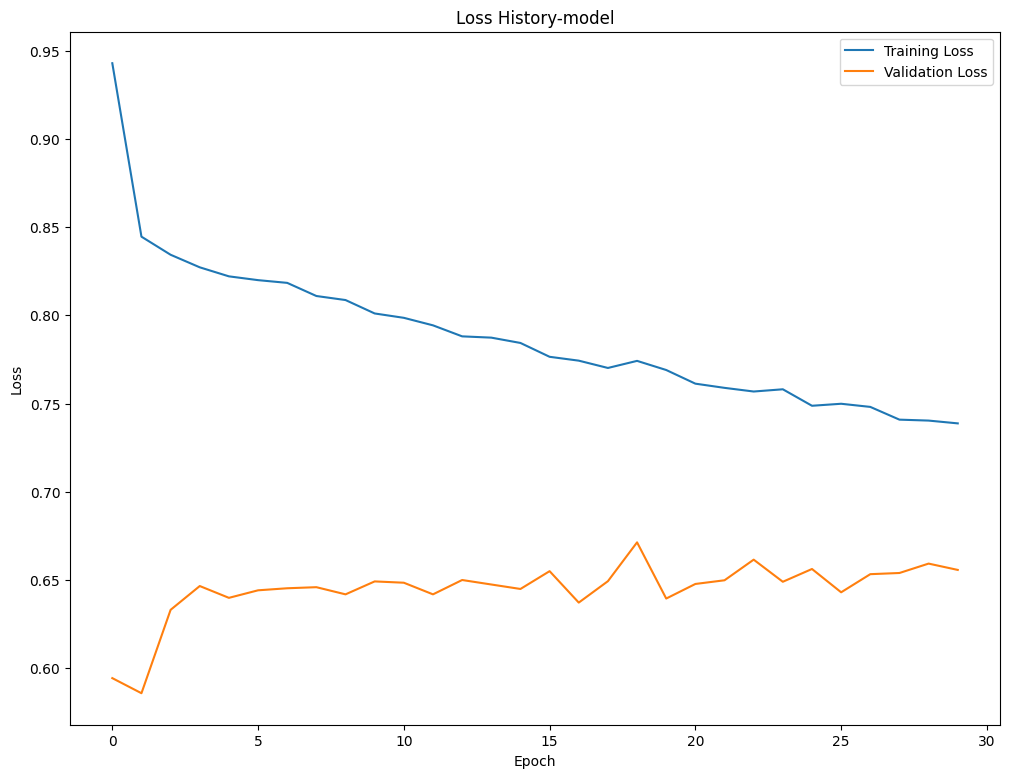

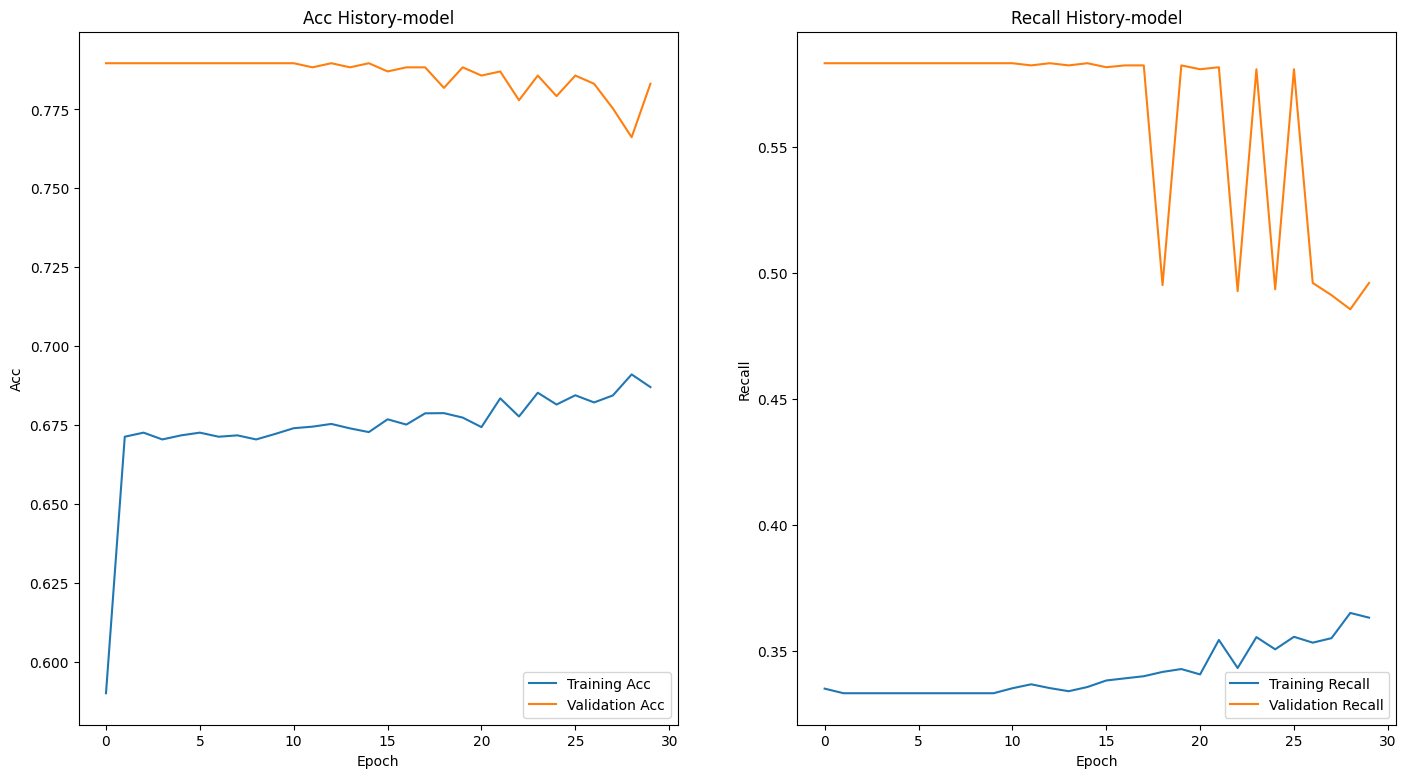

| ID | GPU | MEM |
------------------
|  0 |  5% | 13% |


In [121]:

def criterion(y_pred, y_true):
    loss = nn.CrossEntropyLoss()
    return loss(y_pred, y_true)

def build_model():
    # model = smp.UnetPlusPlus(
    #     encoder_name='tu-'+seg_model ,     # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #     encoder_weights=None,# use `imagenet` pre-trained weights for encoder initialization
    #     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    #     classes=1   ,     # model output channels (number of classes in your dataset)
    #     activation=None,
    # )
    n_classes = 3
    base_model = resnet50(pretrained=True)
    original_conv1_weight = base_model.conv1.weight.data
    original_conv1_weight_mean = original_conv1_weight.mean(dim=1, keepdim=True)
    # Create a new convolutional layer with 1 input channel instead of 3
    base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # Assign the original weights to the new convolutional layerd
    base_model.conv1.weight.data = original_conv1_weight_mean

    # modules = list(base_model.children())[:-2]
    # base_model = nn.Sequential(*modules)
    # custom_base_model = CustomResNet50(base_model, n_classes)



    # base_model.features[0][0] = nn.Conv2d(
    #     in_channels=1,  # Change to 1 for single-channel input
    #     out_channels=base_model.features[0][0].out_channels,
    #     kernel_size=base_model.features[0][0].kernel_size,
    #     stride=base_model.features[0][0].stride,
    #     padding=base_model.features[0][0].padding,
    #     bias=base_model.features[0][0].bias,
    # )
    for param in base_model.parameters():
        param.requires_grad = False
    base_model.fc = nn.Linear(2048, n_classes)

    base_model.to('cuda')
    return base_model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

train_dataset = BuildDatasetGroupR(x_train,y_train, transforms=data_transforms['train'])
val_dataset = BuildDatasetGroupR(x_val,y_val, transforms=data_transforms['valid'])     

train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
for fold in range(1):
    
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='uw-maddison-gi-tract', 
                    config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                    anonymous=anonymous,
                    name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                    group=CFG.comment,
                    )
    train_loader, valid_loader = train_loader,valid_loader
    model     =   build_model()
    unfreeze_last_n_layers(model, 2)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler =  fetch_scheduler(optimizer) 
    # fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                device=CFG.device,
                                num_epochs=CFG.epochs)
    # run.finish()
    # display(ipd.IFrame(run.url, width=1000, height=720))
    plt.figure(figsize=(12,9))

    plt.plot(history['Train Loss'], label=f'Training Loss')
    plt.plot(history['Valid Loss'], label=f'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss History-model')


    plt.figure(figsize=(17,9))
    plt.subplot(1, 2, 1)
    plt.plot(history['Train Acc'], label=f'Training Acc')
    plt.plot(history['Valid Acc'], label=f'Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title(f'Acc History-model')

    plt.subplot(1, 2, 2)
    plt.plot(history['Train Recall'], label=f'Training Recall')
    plt.plot(history['Valid Recall'], label=f'Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.title(f'Recall History-model')
    plt.show()
    torch.save(model.state_dict(), 'UNetPPEffb1_300_bs64_state_dict')
    gpus = GPUtil.getGPUs()
    gpu = gpus[0]
    GPUtil.showUtilization()
    free_memory = gpu.memoryFree
    torch.cuda.empty_cache()
    gc.collect()

torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([68, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([50, 3])


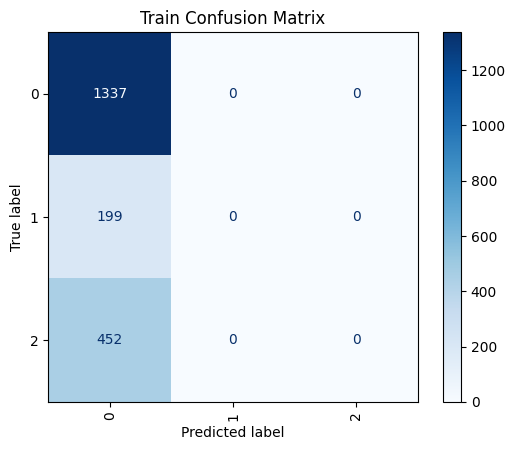

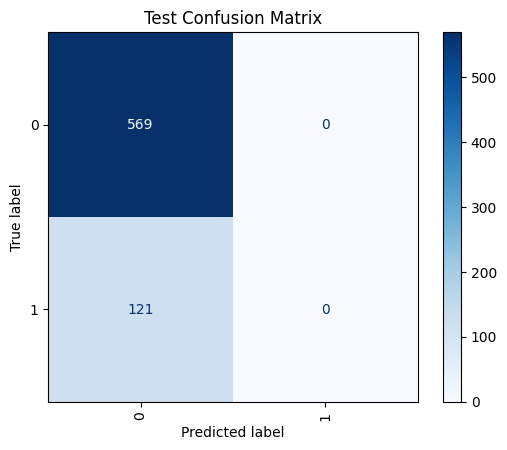

In [128]:
import os
device = 'cuda'

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for (sample) in loader:
            inputs, labels = sample['image'],sample['labelS']  
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            print(outputs.size())
            _,preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Получение предсказаний для тренировочного и тестового наборов
train_preds, train_labels = get_predictions(model, train_loader)
test_preds, test_labels = get_predictions(model, valid_loader)

# Функция для отрисовки матрицы путаницы
def plot_confusion_matrix(preds, labels,filename,title='Confusion Matrix'):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(title)
    plt.savefig(filename)
    plt.show()

# Отрисовка матрицы путаницы для тренировочного и тестового наборов

plot_confusion_matrix(train_preds, train_labels,  title='Train Confusion Matrix',filename=os.path.join('output', 'train_confusion_matrix.png'))
plot_confusion_matrix(test_preds, test_labels, title='Test Confusion Matrix',filename=os.path.join('output', 'val_confusion_matrix.png'))


In [91]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [82]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [144]:
x_train,y_train,x_val,y_val = data_preproc('mask_true','invert','data_29_05_24_cls108_seg72')

In [154]:
for seg_model_name, history in history_all_data_type.items():
        print(f""" MODEL: {seg_model_name} Train ACC MAX:{max(history[0]['Train Acc'])} Train Recall MAX:{max(history[0]['Train Recall'])} Train Loss MIN:{min(history[0]['Train Loss'])} 
        MODEL: {seg_model_name} VAL ACC MAX:{max(history[0]['Valid Acc'])} VAL Recall MAX:{max(history[0]['Valid Recall'])} VAL Loss MIN:{min(history[0]['Valid Loss'])} \n """)

 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.001523709319360784 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r VAL ACC MAX:0.3668087121212121 VAL Recall MAX:0.20032970527530014 VAL Loss MIN:1.903796438852946 
 
 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side Train ACC MAX:0.9986979166666666 Train Recall MAX:0.9990693223358219 Train Loss MIN:0.005561340128032255 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side VAL ACC MAX:0.28794642857142855 VAL Recall MAX:0.27719376593658207 VAL Loss MIN:1.9249997212336614 
 
 MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r Train ACC MAX:0.9984809027777778 Train Recall MAX:0.9988728484479178 Train Loss MIN:0.00854318798611942 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r VAL ACC MAX:0.38859097633136097 VAL Recall MAX:0.1945672744151963 VAL Loss MIN:1.7999732

## Exp with different preprocessing 

###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.51it/s, gpu_mem=7.69 GB, lr=0.00010, train_loss=0.8158]


Train Acc: 0.6654 | Train Recall: 0.4337


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.88it/s, gpu_memory=2.94 GB, lr=0.00010, valid_loss=0.8590]


Valid Acc: 0.7009 | Valid Recall: 0.5289
Valid Score Improved (-inf ---> 0.7009)
Model Saved


Epoch 2/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.08 GB, lr=0.00010, train_loss=0.4848]


Train Acc: 0.8151 | Train Recall: 0.6227


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.30it/s, gpu_memory=2.95 GB, lr=0.00010, valid_loss=1.1411]


Valid Acc: 0.6339 | Valid Recall: 0.4401


Epoch 3/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.68it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.3024]


Train Acc: 0.8899 | Train Recall: 0.7995


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.03it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=1.3842]


Valid Acc: 0.6496 | Valid Recall: 0.3942


Epoch 4/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.1751]


Train Acc: 0.9419 | Train Recall: 0.9024


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.11it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.6916]


Valid Acc: 0.6116 | Valid Recall: 0.3846


Epoch 5/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0945]


Train Acc: 0.9707 | Train Recall: 0.9419


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.98it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=1.7643]


Valid Acc: 0.5787 | Valid Recall: 0.3023


Epoch 6/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0604]


Train Acc: 0.9799 | Train Recall: 0.9725


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.98it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.6590]


Valid Acc: 0.7143 | Valid Recall: 0.4507
Valid Score Improved (0.7009 ---> 0.7143)
Model Saved


Epoch 7/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0455]


Train Acc: 0.9864 | Train Recall: 0.9765


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=2.0643]


Valid Acc: 0.5781 | Valid Recall: 0.3773


Epoch 8/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0405]


Train Acc: 0.9857 | Train Recall: 0.9797


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=2.0284]


Valid Acc: 0.6384 | Valid Recall: 0.3855


Epoch 9/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0267]


Train Acc: 0.9939 | Train Recall: 0.9913


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.99it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=1.8962]


Valid Acc: 0.6663 | Valid Recall: 0.4552


Epoch 10/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0246]


Train Acc: 0.9937 | Train Recall: 0.9909


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.10it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.9169]


Valid Acc: 0.6696 | Valid Recall: 0.4116


Epoch 11/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0211]


Train Acc: 0.9939 | Train Recall: 0.9910


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.09it/s, gpu_memory=3.38 GB, lr=0.00010, valid_loss=2.1405]


Valid Acc: 0.7321 | Valid Recall: 0.4250
Valid Score Improved (0.7143 ---> 0.7321)
Model Saved


Epoch 12/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.35it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0147]


Train Acc: 0.9974 | Train Recall: 0.9976


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.40it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.9384]


Valid Acc: 0.6741 | Valid Recall: 0.4314


Epoch 13/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.36it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0148]


Train Acc: 0.9959 | Train Recall: 0.9960


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.19it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=2.0038]


Valid Acc: 0.6708 | Valid Recall: 0.3949


Epoch 14/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.44it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0157]


Train Acc: 0.9950 | Train Recall: 0.9917


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.57it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.4134]


Valid Acc: 0.5837 | Valid Recall: 0.3601


Epoch 15/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.93it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0146]


Train Acc: 0.9970 | Train Recall: 0.9961


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.72it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.1846]


Valid Acc: 0.6641 | Valid Recall: 0.4336


Epoch 16/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.81it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0106]


Train Acc: 0.9970 | Train Recall: 0.9963


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.98it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.0987]


Valid Acc: 0.6629 | Valid Recall: 0.4724


Epoch 17/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.79it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0071]


Train Acc: 0.9991 | Train Recall: 0.9988


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.41it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.1494]


Valid Acc: 0.6797 | Valid Recall: 0.4078


Epoch 18/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.27it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0126]


Train Acc: 0.9957 | Train Recall: 0.9924


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.93it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.1114]


Valid Acc: 0.6652 | Valid Recall: 0.4101


Epoch 19/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.81it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0138]


Train Acc: 0.9955 | Train Recall: 0.9930


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.17it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.0222]


Valid Acc: 0.6741 | Valid Recall: 0.4574


Epoch 20/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.80it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0093]


Train Acc: 0.9978 | Train Recall: 0.9977


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.98it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.2805]


Valid Acc: 0.6194 | Valid Recall: 0.3760


Epoch 21/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.79it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0176]


Train Acc: 0.9937 | Train Recall: 0.9894


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.12it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.3040]


Valid Acc: 0.6897 | Valid Recall: 0.4122


Epoch 22/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.79it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0122]


Train Acc: 0.9976 | Train Recall: 0.9956


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.88it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.4582]


Valid Acc: 0.6763 | Valid Recall: 0.4235


Epoch 23/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.78it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0144]


Train Acc: 0.9959 | Train Recall: 0.9929


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.57it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.2698]


Valid Acc: 0.6663 | Valid Recall: 0.3958


Epoch 24/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.93it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0119]


Train Acc: 0.9959 | Train Recall: 0.9931


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.54it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.4016]


Valid Acc: 0.6719 | Valid Recall: 0.4447


Epoch 25/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.91it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0171]


Train Acc: 0.9961 | Train Recall: 0.9913


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.59it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.3592]


Valid Acc: 0.7054 | Valid Recall: 0.4387


Epoch 26/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.89it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0097]


Train Acc: 0.9974 | Train Recall: 0.9962


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.50it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.3154]


Valid Acc: 0.7254 | Valid Recall: 0.4782


Epoch 27/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.87it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0086]


Train Acc: 0.9974 | Train Recall: 0.9983


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.51it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.2909]


Valid Acc: 0.6373 | Valid Recall: 0.3857


Epoch 28/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.93it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0105]


Train Acc: 0.9970 | Train Recall: 0.9956


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.30it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.3539]


Valid Acc: 0.6741 | Valid Recall: 0.4055


Epoch 29/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0076]


Train Acc: 0.9965 | Train Recall: 0.9958


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.53it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.8180]


Valid Acc: 0.6027 | Valid Recall: 0.3663


Epoch 30/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.87it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0143]


Train Acc: 0.9957 | Train Recall: 0.9951


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.59it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.7967]


Valid Acc: 0.6719 | Valid Recall: 0.4192


Epoch 31/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0098]


Train Acc: 0.9965 | Train Recall: 0.9946


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.20it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.7524]


Valid Acc: 0.6741 | Valid Recall: 0.4689


Epoch 32/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.88it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0067]


Train Acc: 0.9987 | Train Recall: 0.9985


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.01it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.6925]


Valid Acc: 0.7221 | Valid Recall: 0.4459


Epoch 33/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0116]


Train Acc: 0.9965 | Train Recall: 0.9974


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.98it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.6282]


Valid Acc: 0.7221 | Valid Recall: 0.4733


Epoch 34/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0086]


Train Acc: 0.9983 | Train Recall: 0.9972


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.02it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.5072]


Valid Acc: 0.6384 | Valid Recall: 0.3912


Epoch 35/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0062]


Train Acc: 0.9978 | Train Recall: 0.9985


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.95it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.4271]


Valid Acc: 0.6975 | Valid Recall: 0.4413


Epoch 36/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.65it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0091]


Train Acc: 0.9983 | Train Recall: 0.9972


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.03it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.3816]


Valid Acc: 0.6741 | Valid Recall: 0.4093


Epoch 37/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.68it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0107]


Train Acc: 0.9974 | Train Recall: 0.9958


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.76it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.4786]


Valid Acc: 0.6853 | Valid Recall: 0.4544


Epoch 38/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0078]


Train Acc: 0.9983 | Train Recall: 0.9960


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.04it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.7634]


Valid Acc: 0.5859 | Valid Recall: 0.3778


Epoch 39/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0052]


Train Acc: 0.9987 | Train Recall: 0.9985


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.01it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.6250]


Valid Acc: 0.6217 | Valid Recall: 0.3810


Epoch 40/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0118]


Train Acc: 0.9968 | Train Recall: 0.9976


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.11it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.5652]


Valid Acc: 0.6116 | Valid Recall: 0.3825


Epoch 41/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0105]


Train Acc: 0.9961 | Train Recall: 0.9925


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.12it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.6897]


Valid Acc: 0.7109 | Valid Recall: 0.4187


Epoch 42/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0092]


Train Acc: 0.9970 | Train Recall: 0.9957


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.85it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.5948]


Valid Acc: 0.6908 | Valid Recall: 0.4563


Epoch 43/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.95it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0073]


Train Acc: 0.9987 | Train Recall: 0.9984


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.22it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.3122]


Valid Acc: 0.6763 | Valid Recall: 0.4129


Epoch 44/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.77it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0044]


Train Acc: 0.9987 | Train Recall: 0.9977


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.13it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.4288]


Valid Acc: 0.7087 | Valid Recall: 0.4382


Epoch 45/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.76it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0060]


Train Acc: 0.9981 | Train Recall: 0.9982


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.13it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.4831]


Valid Acc: 0.7031 | Valid Recall: 0.4329


Epoch 46/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.79it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0095]


Train Acc: 0.9959 | Train Recall: 0.9960


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.91it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.3967]


Valid Acc: 0.6853 | Valid Recall: 0.4329


Epoch 47/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.46it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0065]


Train Acc: 0.9987 | Train Recall: 0.9994


Valid : 100%|██████████| 7/7 [00:01<00:00,  5.46it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.8298]


Valid Acc: 0.5859 | Valid Recall: 0.3940


Epoch 48/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.50it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0166]


Train Acc: 0.9944 | Train Recall: 0.9920


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.18it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.7415]


Valid Acc: 0.7221 | Valid Recall: 0.4491


Epoch 49/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.79it/s, gpu_mem=8.09 GB, lr=0.00010, train_loss=0.0150]


Train Acc: 0.9952 | Train Recall: 0.9950


Valid : 100%|██████████| 7/7 [00:00<00:00,  7.06it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.6656]


Valid Acc: 0.7009 | Valid Recall: 0.4558


Epoch 50/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.05it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0165]


Train Acc: 0.9939 | Train Recall: 0.9887


Valid : 100%|██████████| 7/7 [00:01<00:00,  6.14it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.6110]


Valid Acc: 0.7388 | Valid Recall: 0.5342
Valid Score Improved (0.7321 ---> 0.7388)
Model Saved


Training complete in 0h 5m 53s
Best Score: 0.7388


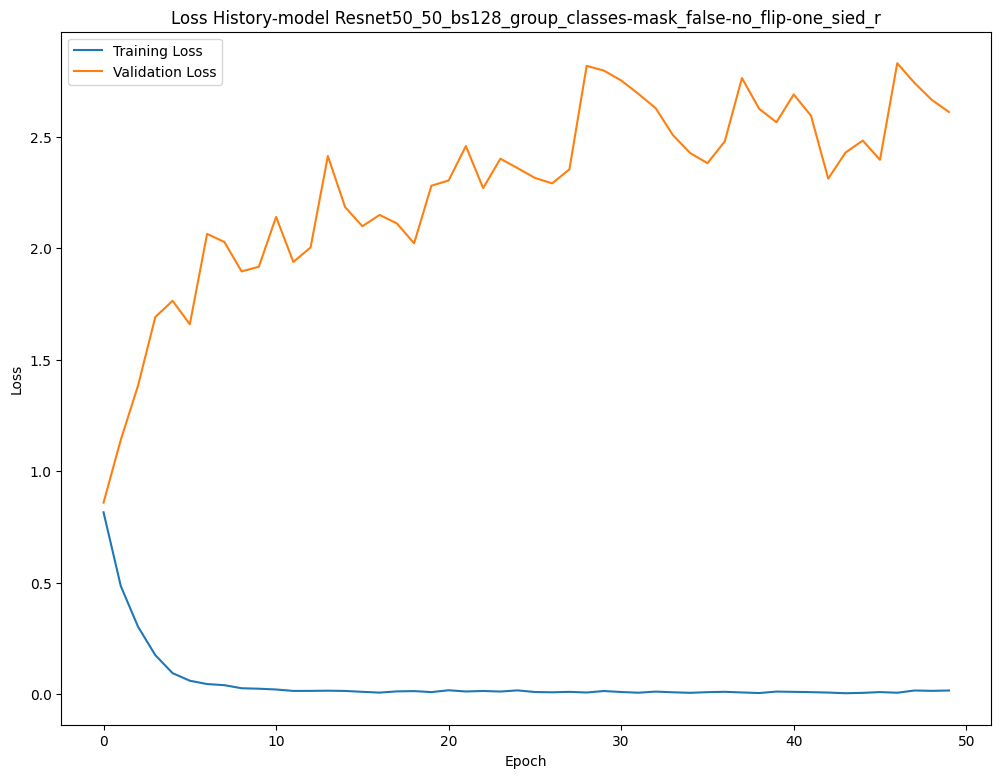

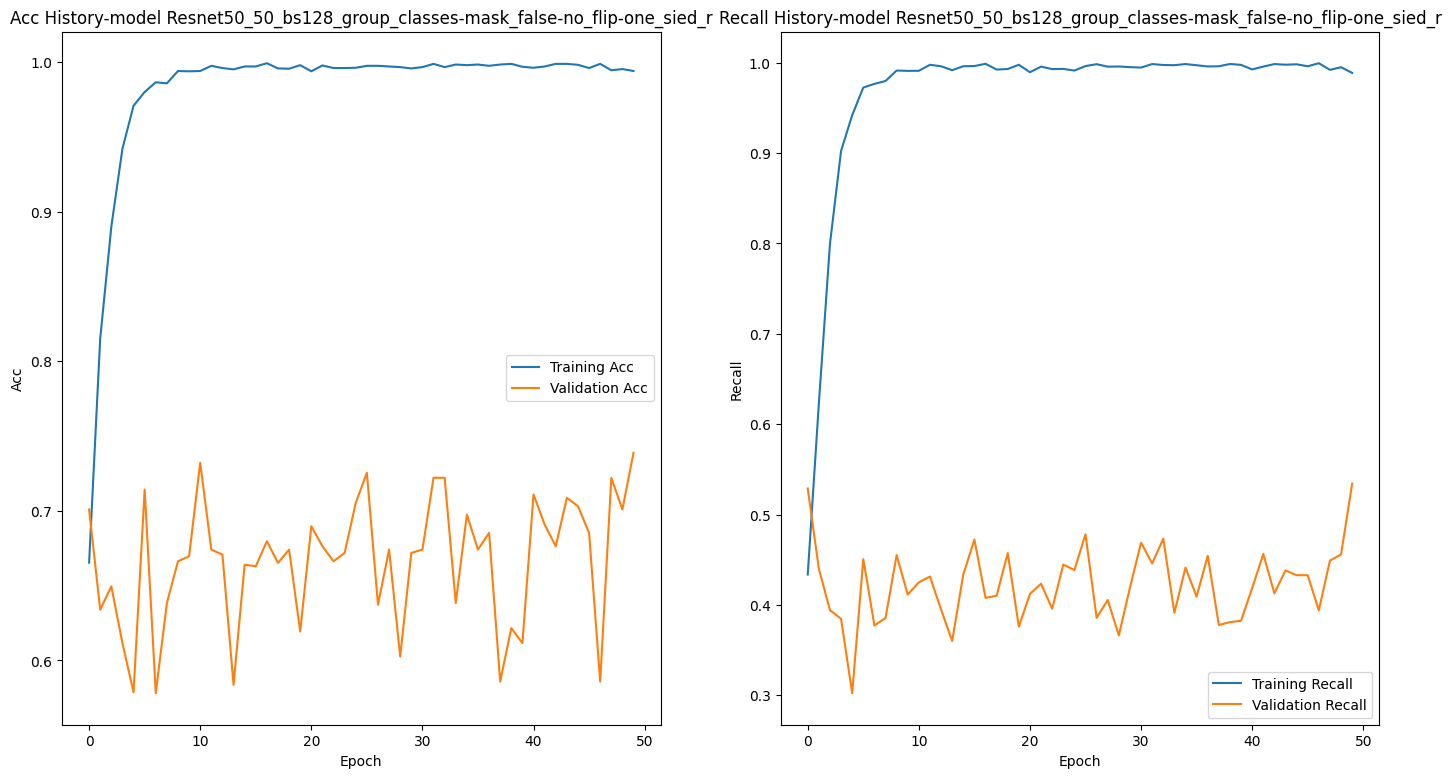

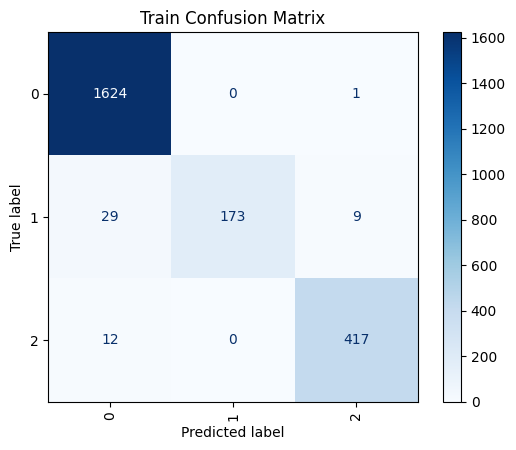

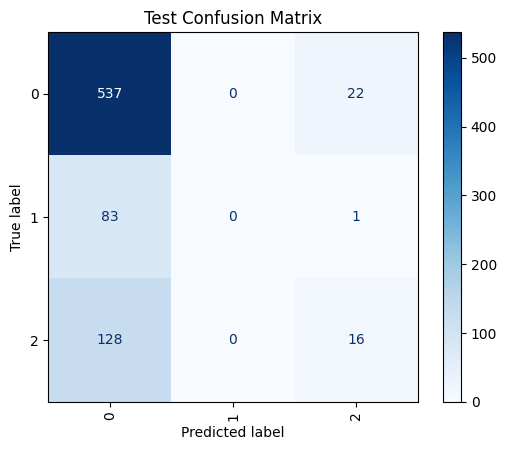

| ID | GPU | MEM |
------------------
|  0 | 11% | 19% |
###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.65it/s, gpu_mem=7.86 GB, lr=0.00010, train_loss=0.9817]


Train Acc: 0.5197 | Train Recall: 0.4376


Valid : 100%|██████████| 6/6 [00:01<00:00,  4.69it/s, gpu_memory=2.93 GB, lr=0.00010, valid_loss=1.0924]


Valid Acc: 0.3985 | Valid Recall: 0.3357
Valid Score Improved (-inf ---> 0.3985)
Model Saved


Epoch 2/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.77it/s, gpu_mem=8.08 GB, lr=0.00010, train_loss=0.7500]


Train Acc: 0.6654 | Train Recall: 0.6245


Valid : 100%|██████████| 6/6 [00:01<00:00,  4.83it/s, gpu_memory=2.97 GB, lr=0.00010, valid_loss=1.2810]


Valid Acc: 0.5053 | Valid Recall: 0.4015
Valid Score Improved (0.3985 ---> 0.5053)
Model Saved


Epoch 3/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.82it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.4968]


Train Acc: 0.7980 | Train Recall: 0.7773


Valid : 100%|██████████| 6/6 [00:01<00:00,  4.97it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=1.4626]


Valid Acc: 0.4780 | Valid Recall: 0.3973


Epoch 4/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.24it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.3052]


Train Acc: 0.8858 | Train Recall: 0.8762


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.37it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=1.8527]


Valid Acc: 0.4560 | Valid Recall: 0.3627


Epoch 5/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.1954]


Train Acc: 0.9317 | Train Recall: 0.9315


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.32it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.1571]


Valid Acc: 0.4311 | Valid Recall: 0.3543


Epoch 6/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.1188]


Train Acc: 0.9617 | Train Recall: 0.9638


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.42it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=2.1758]


Valid Acc: 0.4689 | Valid Recall: 0.3728


Epoch 7/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.67it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0913]


Train Acc: 0.9691 | Train Recall: 0.9679


Valid : 100%|██████████| 6/6 [00:01<00:00,  5.37it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.7397]


Valid Acc: 0.4456 | Valid Recall: 0.3542


Epoch 8/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.81it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0558]


Train Acc: 0.9818 | Train Recall: 0.9811


Valid : 100%|██████████| 6/6 [00:01<00:00,  5.02it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=2.8374]


Valid Acc: 0.4219 | Valid Recall: 0.3423


Epoch 9/50

Train : 100%|██████████| 18/18 [00:06<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0416]


Train Acc: 0.9887 | Train Recall: 0.9891


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.23it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.3202]


Valid Acc: 0.4853 | Valid Recall: 0.3961


Epoch 10/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0237]


Train Acc: 0.9944 | Train Recall: 0.9940


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.41it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=2.5313]


Valid Acc: 0.4225 | Valid Recall: 0.3466


Epoch 11/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0184]


Train Acc: 0.9970 | Train Recall: 0.9974


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.40it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.4471]


Valid Acc: 0.5008 | Valid Recall: 0.3868


Epoch 12/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.64it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0177]


Train Acc: 0.9961 | Train Recall: 0.9961


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.44it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=2.3512]


Valid Acc: 0.4627 | Valid Recall: 0.3680


Epoch 13/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0185]


Train Acc: 0.9952 | Train Recall: 0.9959


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.38it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.0178]


Valid Acc: 0.4164 | Valid Recall: 0.3416


Epoch 14/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.65it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0196]


Train Acc: 0.9956 | Train Recall: 0.9956


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.06it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=3.0205]


Valid Acc: 0.4139 | Valid Recall: 0.3420


Epoch 15/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.67it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0157]


Train Acc: 0.9974 | Train Recall: 0.9973


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.37it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.9023]


Valid Acc: 0.4442 | Valid Recall: 0.3532


Epoch 16/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.67it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0151]


Train Acc: 0.9965 | Train Recall: 0.9968


Valid : 100%|██████████| 6/6 [00:01<00:00,  5.98it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=2.6451]


Valid Acc: 0.4718 | Valid Recall: 0.3802


Epoch 17/50

Train : 100%|██████████| 18/18 [00:05<00:00,  3.54it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0132]


Train Acc: 0.9974 | Train Recall: 0.9977


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.35it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.5918]


Valid Acc: 0.4754 | Valid Recall: 0.3844


Epoch 18/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0115]


Train Acc: 0.9978 | Train Recall: 0.9982


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.36it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=2.7873]


Valid Acc: 0.4668 | Valid Recall: 0.3707


Epoch 19/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0123]


Train Acc: 0.9961 | Train Recall: 0.9962


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.48it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.9048]


Valid Acc: 0.4614 | Valid Recall: 0.3680


Epoch 20/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0199]


Train Acc: 0.9943 | Train Recall: 0.9949


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.48it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=2.9610]


Valid Acc: 0.4827 | Valid Recall: 0.3726


Epoch 21/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.69it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0159]


Train Acc: 0.9961 | Train Recall: 0.9968


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.49it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.8577]


Valid Acc: 0.4597 | Valid Recall: 0.3697


Epoch 22/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0121]


Train Acc: 0.9974 | Train Recall: 0.9973


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.15it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=3.1009]


Valid Acc: 0.4446 | Valid Recall: 0.3605


Epoch 23/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.69it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0121]


Train Acc: 0.9983 | Train Recall: 0.9983


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.57it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.0019]


Valid Acc: 0.4500 | Valid Recall: 0.3567


Epoch 24/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0090]


Train Acc: 0.9978 | Train Recall: 0.9979


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.45it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=3.0819]


Valid Acc: 0.5036 | Valid Recall: 0.3931


Epoch 25/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.75it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0072]


Train Acc: 0.9996 | Train Recall: 0.9995


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.47it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.0238]


Valid Acc: 0.5076 | Valid Recall: 0.4020
Valid Score Improved (0.5053 ---> 0.5076)
Model Saved


Epoch 26/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.69it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0082]


Train Acc: 0.9983 | Train Recall: 0.9984


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.50it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.2123]


Valid Acc: 0.4988 | Valid Recall: 0.3846


Epoch 27/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0073]


Train Acc: 0.9978 | Train Recall: 0.9975


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.48it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=2.8737]


Valid Acc: 0.5063 | Valid Recall: 0.3967


Epoch 28/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0050]


Train Acc: 0.9991 | Train Recall: 0.9987


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.25it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=2.9771]


Valid Acc: 0.4780 | Valid Recall: 0.3792


Epoch 29/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.63it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0066]


Train Acc: 0.9987 | Train Recall: 0.9989


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.51it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.1342]


Valid Acc: 0.4605 | Valid Recall: 0.3698


Epoch 30/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.75it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0067]


Train Acc: 0.9987 | Train Recall: 0.9984


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.39it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.1691]


Valid Acc: 0.5023 | Valid Recall: 0.3893


Epoch 31/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.68it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0060]


Train Acc: 0.9983 | Train Recall: 0.9983


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.31it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.3281]


Valid Acc: 0.4819 | Valid Recall: 0.3816


Epoch 32/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0088]


Train Acc: 0.9978 | Train Recall: 0.9971


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.29it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.3836]


Valid Acc: 0.4634 | Valid Recall: 0.3658


Epoch 33/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0092]


Train Acc: 0.9974 | Train Recall: 0.9971


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.48it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.3375]


Valid Acc: 0.4424 | Valid Recall: 0.3579


Epoch 34/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.67it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0140]


Train Acc: 0.9957 | Train Recall: 0.9967


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.47it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.2134]


Valid Acc: 0.4987 | Valid Recall: 0.3860


Epoch 35/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0077]


Train Acc: 0.9983 | Train Recall: 0.9979


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.41it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.2924]


Valid Acc: 0.4557 | Valid Recall: 0.3558


Epoch 36/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.65it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0083]


Train Acc: 0.9969 | Train Recall: 0.9970


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.38it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.4271]


Valid Acc: 0.4846 | Valid Recall: 0.3734


Epoch 37/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.65it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0073]


Train Acc: 0.9978 | Train Recall: 0.9975


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.39it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.0037]


Valid Acc: 0.4964 | Valid Recall: 0.3894


Epoch 38/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.68it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0054]


Train Acc: 0.9996 | Train Recall: 0.9993


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.40it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.6084]


Valid Acc: 0.4011 | Valid Recall: 0.3401


Epoch 39/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.65it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0101]


Train Acc: 0.9974 | Train Recall: 0.9970


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.40it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.8214]


Valid Acc: 0.3846 | Valid Recall: 0.3291


Epoch 40/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.65it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0135]


Train Acc: 0.9952 | Train Recall: 0.9944


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.50it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.6404]


Valid Acc: 0.4241 | Valid Recall: 0.3602


Epoch 41/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0153]


Train Acc: 0.9939 | Train Recall: 0.9939


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.34it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.0307]


Valid Acc: 0.4978 | Valid Recall: 0.3909


Epoch 42/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.67it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0389]


Train Acc: 0.9883 | Train Recall: 0.9867


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.20it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.8996]


Valid Acc: 0.4472 | Valid Recall: 0.3540


Epoch 43/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0704]


Train Acc: 0.9743 | Train Recall: 0.9743


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.50it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.9713]


Valid Acc: 0.4431 | Valid Recall: 0.3694


Epoch 44/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0592]


Train Acc: 0.9825 | Train Recall: 0.9821


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.49it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.3575]


Valid Acc: 0.4538 | Valid Recall: 0.3579


Epoch 45/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0353]


Train Acc: 0.9883 | Train Recall: 0.9900


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.25it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.3974]


Valid Acc: 0.4146 | Valid Recall: 0.3291


Epoch 46/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.66it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0244]


Train Acc: 0.9913 | Train Recall: 0.9917


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.20it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.5785]


Valid Acc: 0.4248 | Valid Recall: 0.3367


Epoch 47/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.63it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.0238]


Train Acc: 0.9935 | Train Recall: 0.9934


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.33it/s, gpu_memory=3.00 GB, lr=0.00010, valid_loss=3.3344]


Valid Acc: 0.5116 | Valid Recall: 0.3833
Valid Score Improved (0.5076 ---> 0.5116)
Model Saved


Epoch 48/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.67it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0174]


Train Acc: 0.9947 | Train Recall: 0.9942


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.50it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.8412]


Valid Acc: 0.3683 | Valid Recall: 0.3095


Epoch 49/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0149]


Train Acc: 0.9943 | Train Recall: 0.9944


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.51it/s, gpu_memory=3.04 GB, lr=0.00010, valid_loss=3.4034]


Valid Acc: 0.4440 | Valid Recall: 0.3482


Epoch 50/50

Train : 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0165]


Train Acc: 0.9952 | Train Recall: 0.9950


Valid : 100%|██████████| 6/6 [00:00<00:00,  6.47it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=3.3948]


Valid Acc: 0.4728 | Valid Recall: 0.3695


Training complete in 0h 5m 37s
Best Score: 0.5116


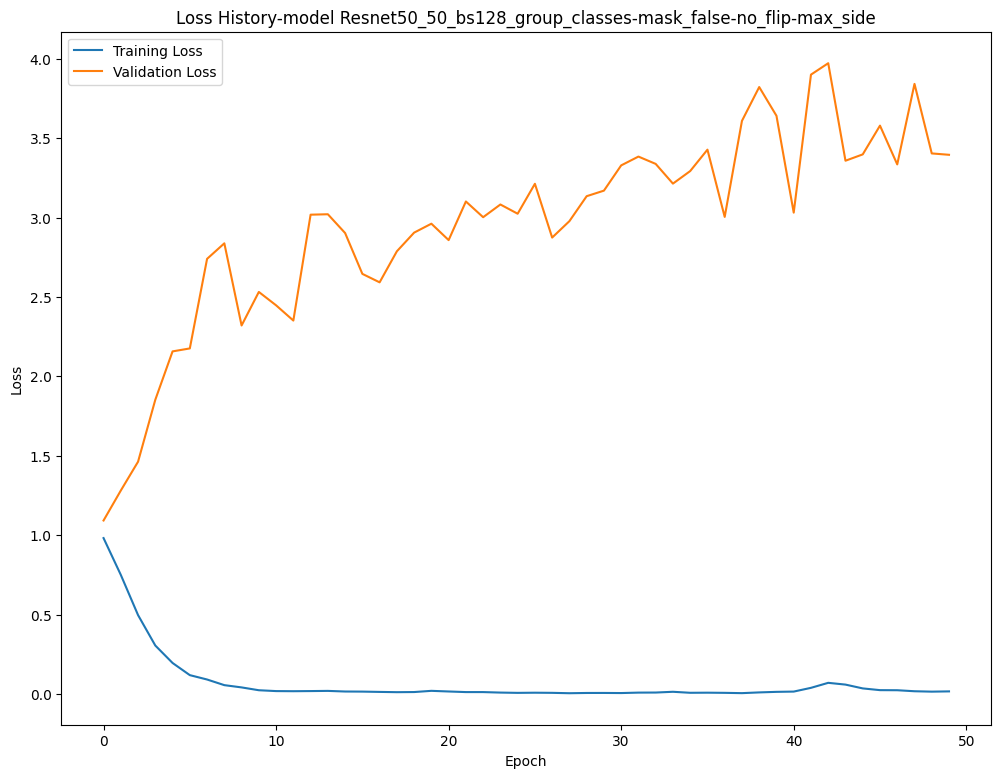

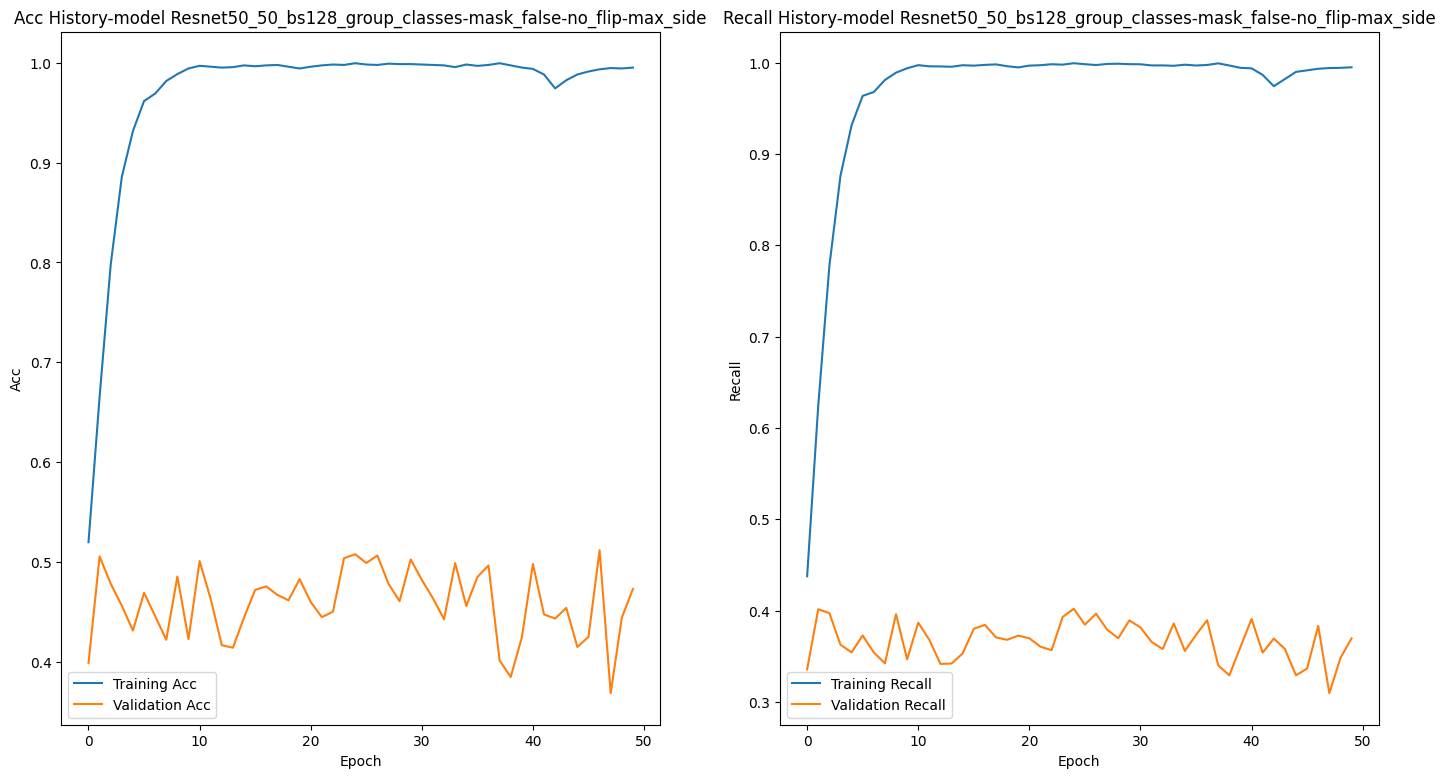

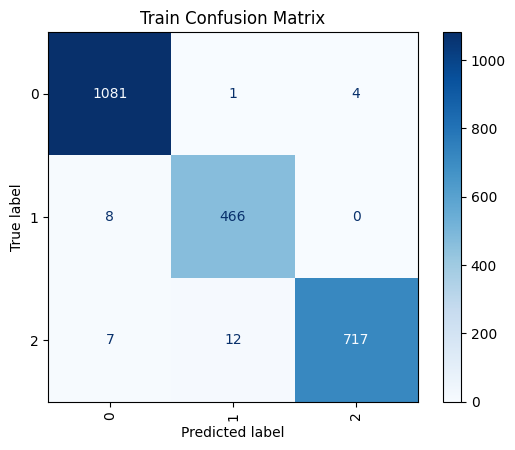

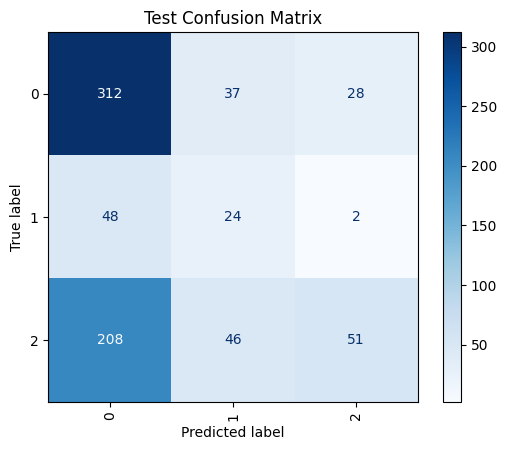

| ID | GPU | MEM |
------------------
|  0 |  6% | 19% |
###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.62it/s, gpu_mem=7.86 GB, lr=0.00010, train_loss=0.7284]


Train Acc: 0.7262 | Train Recall: 0.3812


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.78it/s, gpu_memory=3.21 GB, lr=0.00010, valid_loss=1.3389]


Valid Acc: 0.6695 | Valid Recall: 0.4841
Valid Score Improved (-inf ---> 0.6695)
Model Saved


Epoch 2/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.83it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.5629]


Train Acc: 0.7712 | Train Recall: 0.5380


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.93it/s, gpu_memory=3.27 GB, lr=0.00010, valid_loss=1.5812]


Valid Acc: 0.6581 | Valid Recall: 0.4275


Epoch 3/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.75it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.4364]


Train Acc: 0.8142 | Train Recall: 0.6342


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.82it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=1.1457]


Valid Acc: 0.6642 | Valid Recall: 0.3805


Epoch 4/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.77it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.3039]


Train Acc: 0.8753 | Train Recall: 0.7586


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.60it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.7227]


Valid Acc: 0.6797 | Valid Recall: 0.4798
Valid Score Improved (0.6695 ---> 0.6797)
Model Saved


Epoch 5/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.83it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.2333]


Train Acc: 0.9044 | Train Recall: 0.8344


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.94it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.8006]


Valid Acc: 0.6761 | Valid Recall: 0.4539


Epoch 6/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.79it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.1619]


Train Acc: 0.9401 | Train Recall: 0.9000


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.83it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=1.7459]


Valid Acc: 0.6827 | Valid Recall: 0.3969
Valid Score Improved (0.6797 ---> 0.6827)
Model Saved


Epoch 7/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.81it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.1228]


Train Acc: 0.9547 | Train Recall: 0.9293


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.89it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.8982]


Valid Acc: 0.6460 | Valid Recall: 0.4148


Epoch 8/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.83it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0861]


Train Acc: 0.9703 | Train Recall: 0.9549


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.94it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.0249]


Valid Acc: 0.6797 | Valid Recall: 0.4243


Epoch 9/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.85it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0706]


Train Acc: 0.9748 | Train Recall: 0.9631


Valid : 100%|██████████| 13/13 [00:01<00:00,  7.03it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=2.0725]


Valid Acc: 0.6749 | Valid Recall: 0.4317


Epoch 10/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.84it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0555]


Train Acc: 0.9801 | Train Recall: 0.9662


Valid : 100%|██████████| 13/13 [00:01<00:00,  7.01it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=1.5291]


Valid Acc: 0.6366 | Valid Recall: 0.3680


Epoch 11/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.87it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0562]


Train Acc: 0.9826 | Train Recall: 0.9774


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.99it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=2.0779]


Valid Acc: 0.6672 | Valid Recall: 0.3675


Epoch 12/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.84it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0401]


Train Acc: 0.9848 | Train Recall: 0.9753


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.98it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.1977]


Valid Acc: 0.6743 | Valid Recall: 0.4306


Epoch 13/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.87it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0367]


Train Acc: 0.9874 | Train Recall: 0.9813


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.89it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=2.2044]


Valid Acc: 0.6929 | Valid Recall: 0.4229
Valid Score Improved (0.6827 ---> 0.6929)
Model Saved


Epoch 14/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.83it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0331]


Train Acc: 0.9889 | Train Recall: 0.9841


Valid : 100%|██████████| 13/13 [00:01<00:00,  7.10it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.6308]


Valid Acc: 0.6779 | Valid Recall: 0.4281


Epoch 15/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.85it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0321]


Train Acc: 0.9900 | Train Recall: 0.9854


Valid : 100%|██████████| 13/13 [00:01<00:00,  7.09it/s, gpu_memory=3.30 GB, lr=0.00010, valid_loss=2.4714]


Valid Acc: 0.6809 | Valid Recall: 0.4222


Epoch 16/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.77it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0357]


Train Acc: 0.9891 | Train Recall: 0.9817


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.99it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2120]


Valid Acc: 0.6893 | Valid Recall: 0.4205


Epoch 17/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.79it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0342]


Train Acc: 0.9881 | Train Recall: 0.9842


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.85it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.3063]


Valid Acc: 0.6873 | Valid Recall: 0.3860


Epoch 18/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.77it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0251]


Train Acc: 0.9907 | Train Recall: 0.9841


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.98it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.1601]


Valid Acc: 0.6758 | Valid Recall: 0.3557


Epoch 19/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.83it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0155]


Train Acc: 0.9952 | Train Recall: 0.9928


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.88it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.1248]


Valid Acc: 0.6828 | Valid Recall: 0.4040


Epoch 20/50

Train : 100%|██████████| 36/36 [00:11<00:00,  3.18it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0163]


Train Acc: 0.9948 | Train Recall: 0.9905


Valid : 100%|██████████| 13/13 [00:01<00:00,  7.06it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2077]


Valid Acc: 0.6923 | Valid Recall: 0.4487


Epoch 21/50

Train : 100%|██████████| 36/36 [00:11<00:00,  3.26it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0175]


Train Acc: 0.9935 | Train Recall: 0.9895


Valid : 100%|██████████| 13/13 [00:01<00:00,  6.97it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.8915]


Valid Acc: 0.6881 | Valid Recall: 0.4147


Epoch 22/50

Train : 100%|██████████| 36/36 [00:09<00:00,  3.87it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0248]


Train Acc: 0.9915 | Train Recall: 0.9875


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.82it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2762]


Valid Acc: 0.6577 | Valid Recall: 0.3595


Epoch 23/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0273]


Train Acc: 0.9915 | Train Recall: 0.9869


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.2968]


Valid Acc: 0.6656 | Valid Recall: 0.3491


Epoch 24/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0161]


Train Acc: 0.9957 | Train Recall: 0.9925


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.35it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=3.0178]


Valid Acc: 0.6863 | Valid Recall: 0.4521


Epoch 25/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0266]


Train Acc: 0.9926 | Train Recall: 0.9874


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.39it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.3277]


Valid Acc: 0.6823 | Valid Recall: 0.3969


Epoch 26/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0154]


Train Acc: 0.9952 | Train Recall: 0.9921


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.38it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.4287]


Valid Acc: 0.6875 | Valid Recall: 0.4175


Epoch 27/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0185]


Train Acc: 0.9944 | Train Recall: 0.9924


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.20it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.1189]


Valid Acc: 0.6787 | Valid Recall: 0.4064


Epoch 28/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0228]


Train Acc: 0.9924 | Train Recall: 0.9872


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3174]


Valid Acc: 0.6466 | Valid Recall: 0.3898


Epoch 29/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.89it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0295]


Train Acc: 0.9909 | Train Recall: 0.9844


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.27it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.0606]


Valid Acc: 0.6858 | Valid Recall: 0.4206


Epoch 30/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.90it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0298]


Train Acc: 0.9887 | Train Recall: 0.9824


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2973]


Valid Acc: 0.6919 | Valid Recall: 0.3816


Epoch 31/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0341]


Train Acc: 0.9870 | Train Recall: 0.9821


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.35it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.3636]


Valid Acc: 0.6740 | Valid Recall: 0.3552


Epoch 32/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0302]


Train Acc: 0.9907 | Train Recall: 0.9850


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.9332]


Valid Acc: 0.6839 | Valid Recall: 0.4504


Epoch 33/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0241]


Train Acc: 0.9931 | Train Recall: 0.9898


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.34it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.5385]


Valid Acc: 0.6834 | Valid Recall: 0.3825


Epoch 34/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.90it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0121]


Train Acc: 0.9965 | Train Recall: 0.9944


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.23it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2931]


Valid Acc: 0.6894 | Valid Recall: 0.3862


Epoch 35/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0106]


Train Acc: 0.9970 | Train Recall: 0.9948


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.10it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.5652]


Valid Acc: 0.6672 | Valid Recall: 0.3714


Epoch 36/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0127]


Train Acc: 0.9959 | Train Recall: 0.9941


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3320]


Valid Acc: 0.6757 | Valid Recall: 0.3786


Epoch 37/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0137]


Train Acc: 0.9946 | Train Recall: 0.9917


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.2739]


Valid Acc: 0.6912 | Valid Recall: 0.4084


Epoch 38/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.88it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0113]


Train Acc: 0.9967 | Train Recall: 0.9953


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.5122]


Valid Acc: 0.6853 | Valid Recall: 0.3871


Epoch 39/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.90it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0097]


Train Acc: 0.9967 | Train Recall: 0.9964


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.31it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.6683]


Valid Acc: 0.6906 | Valid Recall: 0.4091


Epoch 40/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.91it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0117]


Train Acc: 0.9967 | Train Recall: 0.9950


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.12it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.5953]


Valid Acc: 0.6846 | Valid Recall: 0.3880


Epoch 41/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.83it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0115]


Train Acc: 0.9963 | Train Recall: 0.9954


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.6927]


Valid Acc: 0.6803 | Valid Recall: 0.3822


Epoch 42/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0112]


Train Acc: 0.9976 | Train Recall: 0.9982


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.32it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=3.4172]


Valid Acc: 0.6900 | Valid Recall: 0.4426


Epoch 43/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.91it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0079]


Train Acc: 0.9983 | Train Recall: 0.9976


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.04it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.7971]


Valid Acc: 0.6876 | Valid Recall: 0.4046


Epoch 44/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.90it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0068]


Train Acc: 0.9980 | Train Recall: 0.9975


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.34it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.7819]


Valid Acc: 0.6918 | Valid Recall: 0.4091


Epoch 45/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0095]


Train Acc: 0.9976 | Train Recall: 0.9965


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.6085]


Valid Acc: 0.6924 | Valid Recall: 0.3999


Epoch 46/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.88it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0070]


Train Acc: 0.9974 | Train Recall: 0.9967


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.35it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.5652]


Valid Acc: 0.6846 | Valid Recall: 0.3955


Epoch 47/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0153]


Train Acc: 0.9950 | Train Recall: 0.9932


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=2.9017]


Valid Acc: 0.6749 | Valid Recall: 0.4364


Epoch 48/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.12 GB, lr=0.00009, train_loss=0.0126]


Train Acc: 0.9959 | Train Recall: 0.9934


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.16it/s, gpu_memory=3.32 GB, lr=0.00009, valid_loss=2.5693]


Valid Acc: 0.6858 | Valid Recall: 0.3842


Epoch 49/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.91it/s, gpu_mem=8.13 GB, lr=0.00009, train_loss=0.0083]


Train Acc: 0.9965 | Train Recall: 0.9953


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.27it/s, gpu_memory=3.31 GB, lr=0.00009, valid_loss=2.5335]


Valid Acc: 0.6930 | Valid Recall: 0.3828
Valid Score Improved (0.6929 ---> 0.6930)
Model Saved


Epoch 50/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, gpu_mem=8.12 GB, lr=0.00009, train_loss=0.0066]


Train Acc: 0.9983 | Train Recall: 0.9977


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, gpu_memory=3.32 GB, lr=0.00009, valid_loss=2.9762]


Valid Acc: 0.6858 | Valid Recall: 0.4387


Training complete in 0h 11m 57s
Best Score: 0.6930


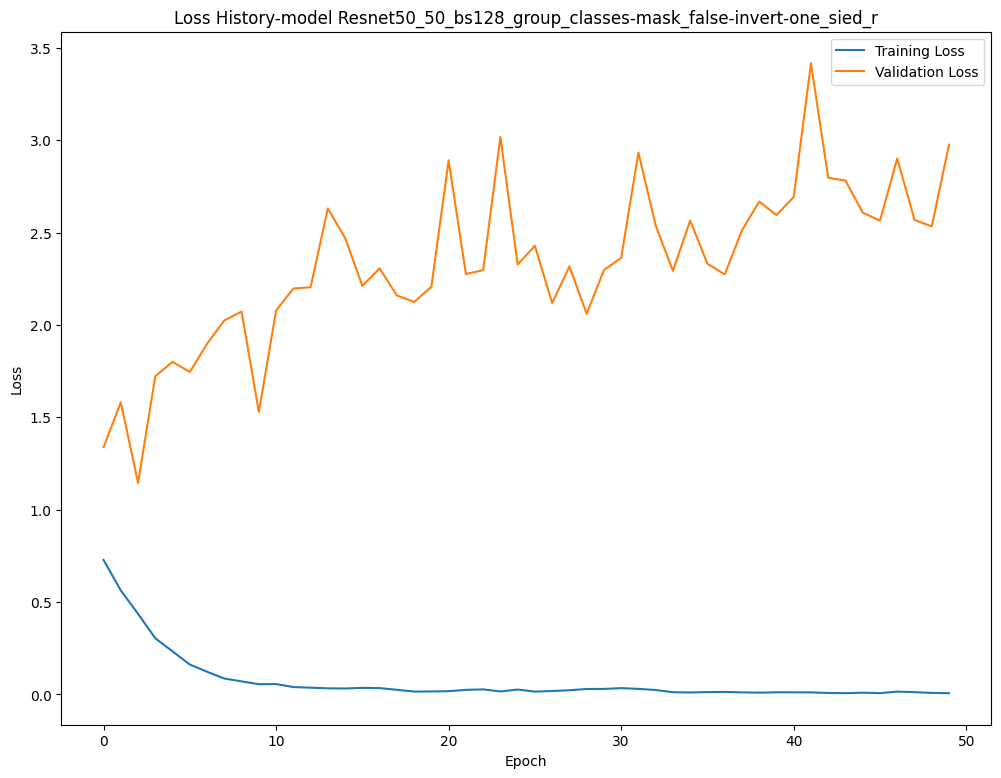

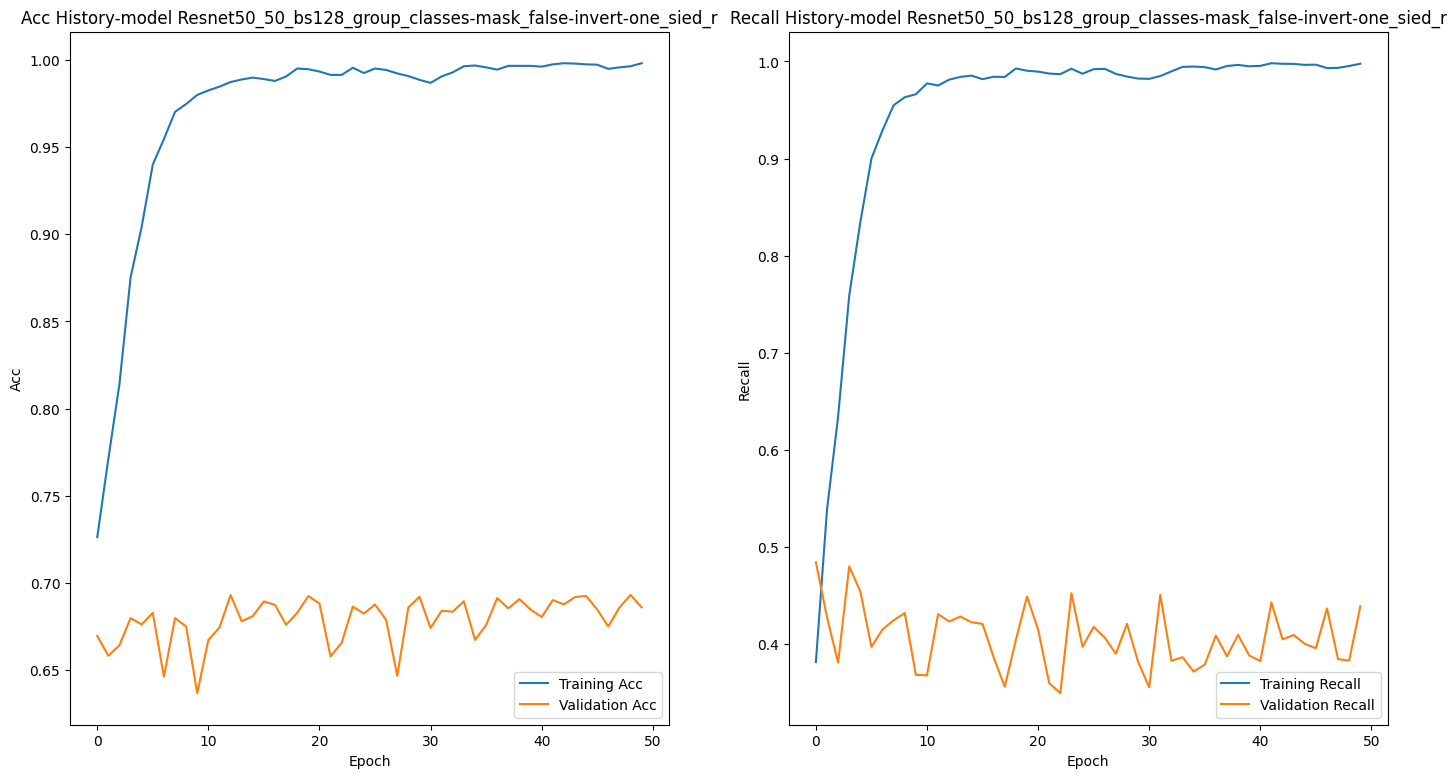

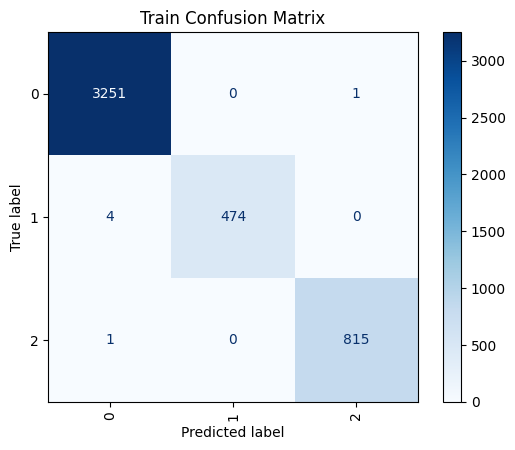

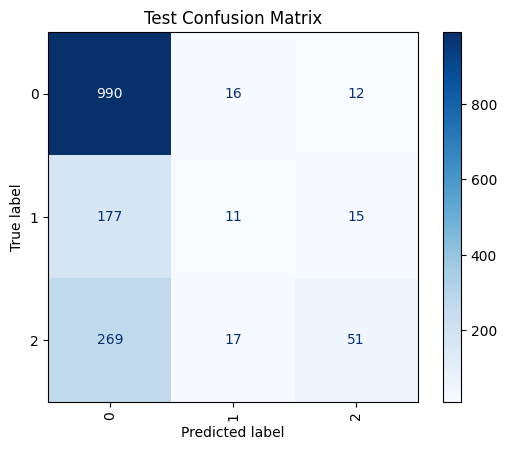

| ID | GPU | MEM |
------------------
|  0 |  3% | 20% |
###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.86it/s, gpu_mem=7.89 GB, lr=0.00010, train_loss=0.8668]


Train Acc: 0.5913 | Train Recall: 0.5307


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.28it/s, gpu_memory=2.93 GB, lr=0.00010, valid_loss=1.4398]


Valid Acc: 0.4760 | Valid Recall: 0.3642
Valid Score Improved (-inf ---> 0.4760)
Model Saved


Epoch 2/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.4363]


Train Acc: 0.8292 | Train Recall: 0.8007


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.0809]


Valid Acc: 0.4231 | Valid Recall: 0.3011


Epoch 3/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.91it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.1866]


Train Acc: 0.9353 | Train Recall: 0.9244


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=2.5212]


Valid Acc: 0.4417 | Valid Recall: 0.3146


Epoch 4/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0841]


Train Acc: 0.9740 | Train Recall: 0.9707


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.35it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.9901]


Valid Acc: 0.3618 | Valid Recall: 0.2665


Epoch 5/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.87it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0611]


Train Acc: 0.9767 | Train Recall: 0.9771


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=2.8303]


Valid Acc: 0.4363 | Valid Recall: 0.2920


Epoch 6/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0428]


Train Acc: 0.9858 | Train Recall: 0.9855


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.9399]


Valid Acc: 0.4387 | Valid Recall: 0.3124


Epoch 7/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0350]


Train Acc: 0.9882 | Train Recall: 0.9877


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.32it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.0291]


Valid Acc: 0.4159 | Valid Recall: 0.2870


Epoch 8/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0187]


Train Acc: 0.9951 | Train Recall: 0.9946


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.38it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.9724]


Valid Acc: 0.4273 | Valid Recall: 0.2913


Epoch 9/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0138]


Train Acc: 0.9970 | Train Recall: 0.9966


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.2578]


Valid Acc: 0.4117 | Valid Recall: 0.2831


Epoch 10/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0161]


Train Acc: 0.9959 | Train Recall: 0.9961


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.15it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=2.9622]


Valid Acc: 0.4441 | Valid Recall: 0.3016


Epoch 11/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0169]


Train Acc: 0.9946 | Train Recall: 0.9942


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.1872]


Valid Acc: 0.4195 | Valid Recall: 0.2933


Epoch 12/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0173]


Train Acc: 0.9946 | Train Recall: 0.9936


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.31it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.2588]


Valid Acc: 0.4405 | Valid Recall: 0.2997


Epoch 13/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0141]


Train Acc: 0.9959 | Train Recall: 0.9960


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.44it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.0999]


Valid Acc: 0.4363 | Valid Recall: 0.3042


Epoch 14/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0069]


Train Acc: 0.9983 | Train Recall: 0.9977


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.47it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.4030]


Valid Acc: 0.4062 | Valid Recall: 0.2861


Epoch 15/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0087]


Train Acc: 0.9977 | Train Recall: 0.9969


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.39it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.5449]


Valid Acc: 0.4333 | Valid Recall: 0.2994


Epoch 16/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0077]


Train Acc: 0.9974 | Train Recall: 0.9975


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.42it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.6346]


Valid Acc: 0.4387 | Valid Recall: 0.3033


Epoch 17/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0054]


Train Acc: 0.9985 | Train Recall: 0.9987


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.3041]


Valid Acc: 0.4471 | Valid Recall: 0.3007


Epoch 18/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.99it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0052]


Train Acc: 0.9991 | Train Recall: 0.9993


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.05it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.3724]


Valid Acc: 0.4429 | Valid Recall: 0.3078


Epoch 19/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.99it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0054]


Train Acc: 0.9983 | Train Recall: 0.9986


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.32it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.4710]


Valid Acc: 0.4387 | Valid Recall: 0.3124


Epoch 20/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.99it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0103]


Train Acc: 0.9976 | Train Recall: 0.9973


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.5542]


Valid Acc: 0.4285 | Valid Recall: 0.2994


Epoch 21/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0093]


Train Acc: 0.9965 | Train Recall: 0.9965


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.22it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.6007]


Valid Acc: 0.4339 | Valid Recall: 0.2842


Epoch 22/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.88it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0119]


Train Acc: 0.9950 | Train Recall: 0.9949


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.36it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.6269]


Valid Acc: 0.3798 | Valid Recall: 0.2728


Epoch 23/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.88it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0177]


Train Acc: 0.9935 | Train Recall: 0.9935


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.28it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.6339]


Valid Acc: 0.4513 | Valid Recall: 0.3035


Epoch 24/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.89it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0421]


Train Acc: 0.9844 | Train Recall: 0.9846


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.5845]


Valid Acc: 0.4357 | Valid Recall: 0.3062


Epoch 25/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.90it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0249]


Train Acc: 0.9913 | Train Recall: 0.9919


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.24it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.6118]


Valid Acc: 0.4603 | Valid Recall: 0.3099


Epoch 26/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.85it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0112]


Train Acc: 0.9970 | Train Recall: 0.9968


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.00it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.1154]


Valid Acc: 0.4585 | Valid Recall: 0.3288


Epoch 27/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0077]


Train Acc: 0.9972 | Train Recall: 0.9971


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.29it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.4138]


Valid Acc: 0.4447 | Valid Recall: 0.2947


Epoch 28/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0056]


Train Acc: 0.9985 | Train Recall: 0.9988


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.35it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.7703]


Valid Acc: 0.4675 | Valid Recall: 0.3209


Epoch 29/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.90it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0100]


Train Acc: 0.9972 | Train Recall: 0.9977


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.8027]


Valid Acc: 0.4399 | Valid Recall: 0.3083


Epoch 30/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0151]


Train Acc: 0.9952 | Train Recall: 0.9958


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.8332]


Valid Acc: 0.4700 | Valid Recall: 0.3256


Epoch 31/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0118]


Train Acc: 0.9965 | Train Recall: 0.9967


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.08it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.7444]


Valid Acc: 0.4255 | Valid Recall: 0.2982


Epoch 32/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0077]


Train Acc: 0.9977 | Train Recall: 0.9979


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.22it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.5888]


Valid Acc: 0.4531 | Valid Recall: 0.3099


Epoch 33/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.87it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0060]


Train Acc: 0.9974 | Train Recall: 0.9973


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.19it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.8425]


Valid Acc: 0.4579 | Valid Recall: 0.3056


Epoch 34/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0077]


Train Acc: 0.9978 | Train Recall: 0.9979


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.8066]


Valid Acc: 0.4435 | Valid Recall: 0.2946


Epoch 35/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0039]


Train Acc: 0.9989 | Train Recall: 0.9989


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.34it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.9764]


Valid Acc: 0.4135 | Valid Recall: 0.2757


Epoch 36/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0063]


Train Acc: 0.9978 | Train Recall: 0.9979


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.31it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=3.9031]


Valid Acc: 0.4171 | Valid Recall: 0.2806


Epoch 37/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.92it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0054]


Train Acc: 0.9985 | Train Recall: 0.9990


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.34it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.6789]


Valid Acc: 0.4417 | Valid Recall: 0.2970


Epoch 38/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0028]


Train Acc: 0.9996 | Train Recall: 0.9995


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=4.0580]


Valid Acc: 0.4147 | Valid Recall: 0.2741


Epoch 39/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0031]


Train Acc: 0.9991 | Train Recall: 0.9991


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.02it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.8124]


Valid Acc: 0.4309 | Valid Recall: 0.2919


Epoch 40/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.93it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0047]


Train Acc: 0.9987 | Train Recall: 0.9986


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=4.1000]


Valid Acc: 0.4213 | Valid Recall: 0.2876


Epoch 41/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.96it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0043]


Train Acc: 0.9983 | Train Recall: 0.9982


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.23it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.9117]


Valid Acc: 0.4177 | Valid Recall: 0.2899


Epoch 42/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.94it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0066]


Train Acc: 0.9976 | Train Recall: 0.9979


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.47it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=4.5425]


Valid Acc: 0.4700 | Valid Recall: 0.3269


Epoch 43/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0104]


Train Acc: 0.9972 | Train Recall: 0.9971


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.41it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=3.9817]


Valid Acc: 0.4165 | Valid Recall: 0.2947


Epoch 44/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0127]


Train Acc: 0.9970 | Train Recall: 0.9968


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.48it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=4.2019]


Valid Acc: 0.4315 | Valid Recall: 0.3024


Epoch 45/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.95it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0070]


Train Acc: 0.9983 | Train Recall: 0.9979


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.44it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=4.1619]


Valid Acc: 0.4129 | Valid Recall: 0.2765


Epoch 46/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0030]


Train Acc: 0.9996 | Train Recall: 0.9995


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.44it/s, gpu_memory=3.35 GB, lr=0.00010, valid_loss=4.2377]


Valid Acc: 0.4237 | Valid Recall: 0.2802


Epoch 47/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0026]


Train Acc: 0.9990 | Train Recall: 0.9991


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.18it/s, gpu_memory=3.36 GB, lr=0.00010, valid_loss=4.2254]


Valid Acc: 0.4243 | Valid Recall: 0.2899


Epoch 48/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, gpu_mem=8.12 GB, lr=0.00009, train_loss=0.0062]


Train Acc: 0.9980 | Train Recall: 0.9977


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.41it/s, gpu_memory=3.35 GB, lr=0.00009, valid_loss=4.4213]


Valid Acc: 0.4339 | Valid Recall: 0.2884


Epoch 49/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.98it/s, gpu_mem=8.15 GB, lr=0.00009, train_loss=0.0119]


Train Acc: 0.9961 | Train Recall: 0.9960


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.44it/s, gpu_memory=3.36 GB, lr=0.00009, valid_loss=4.3310]


Valid Acc: 0.4423 | Valid Recall: 0.2937


Epoch 50/50

Train : 100%|██████████| 36/36 [00:12<00:00,  2.97it/s, gpu_mem=8.12 GB, lr=0.00009, train_loss=0.0094]


Train Acc: 0.9972 | Train Recall: 0.9968


Valid : 100%|██████████| 13/13 [00:02<00:00,  5.40it/s, gpu_memory=3.35 GB, lr=0.00009, valid_loss=4.3313]


Valid Acc: 0.4117 | Valid Recall: 0.2796


Training complete in 0h 13m 14s
Best Score: 0.4760


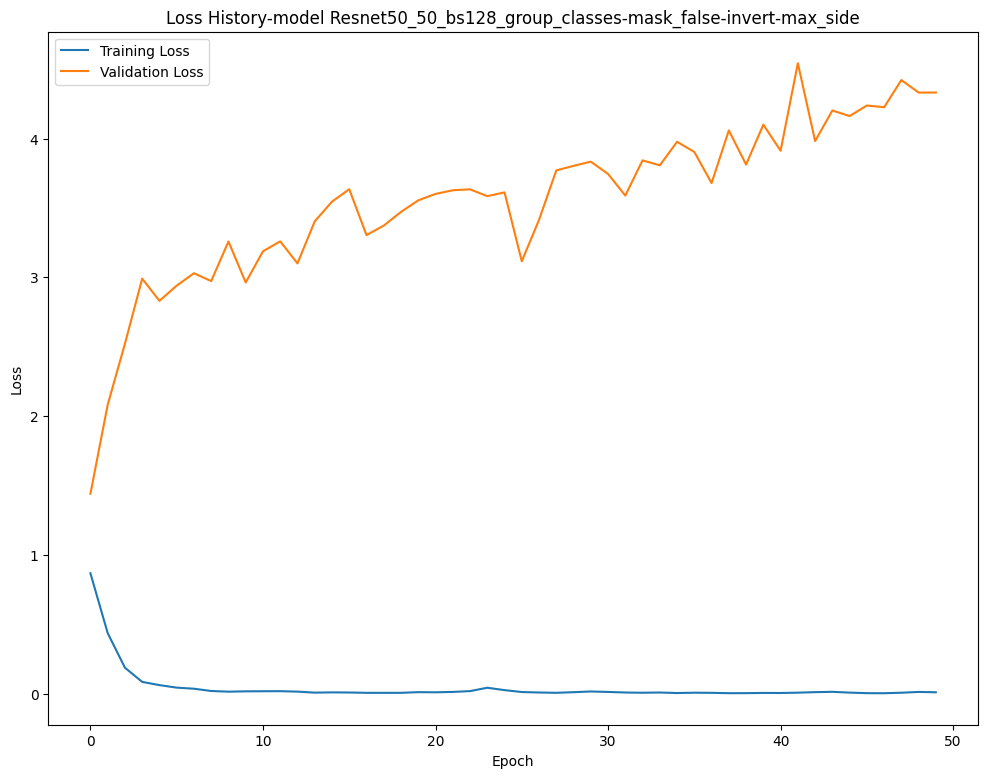

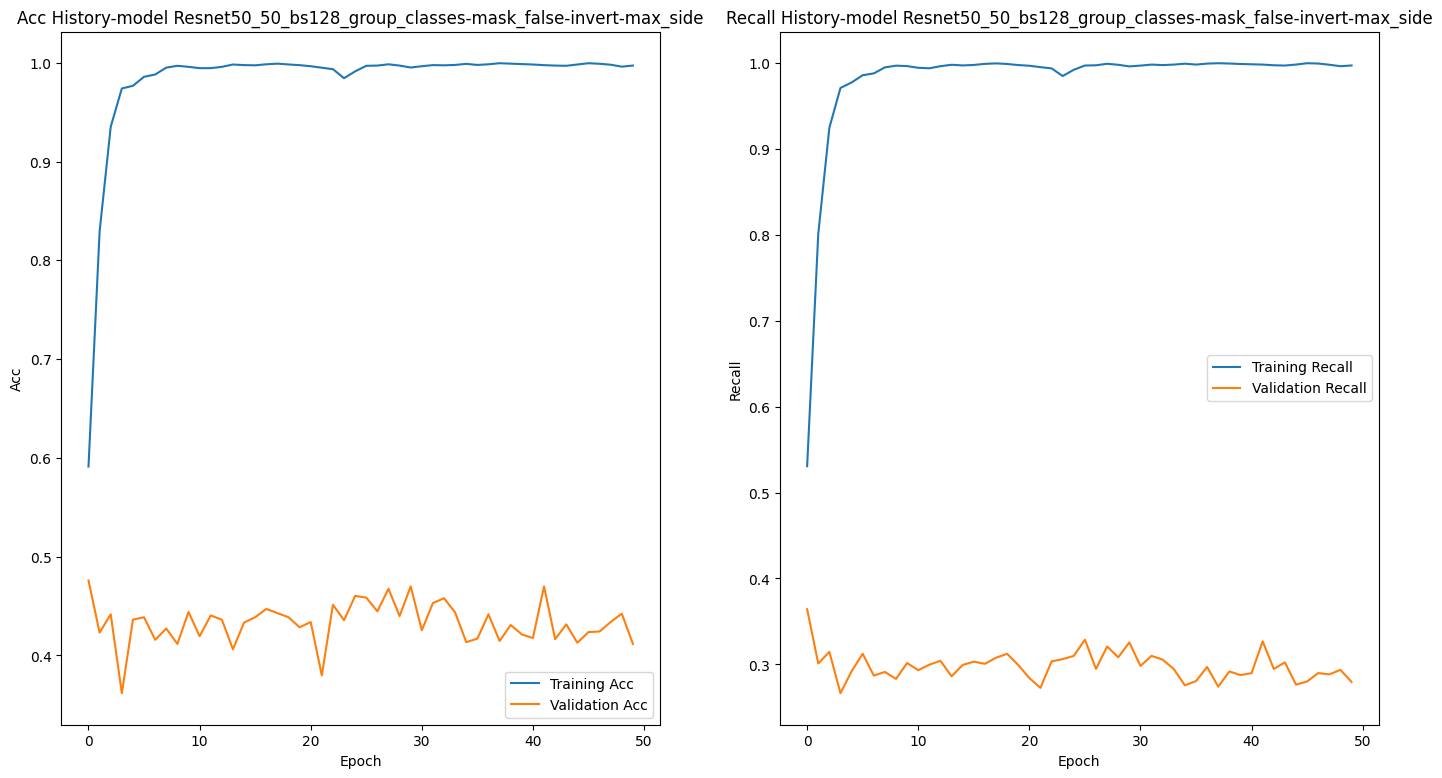

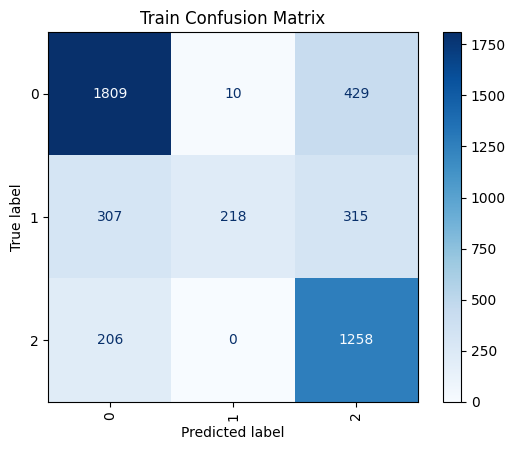

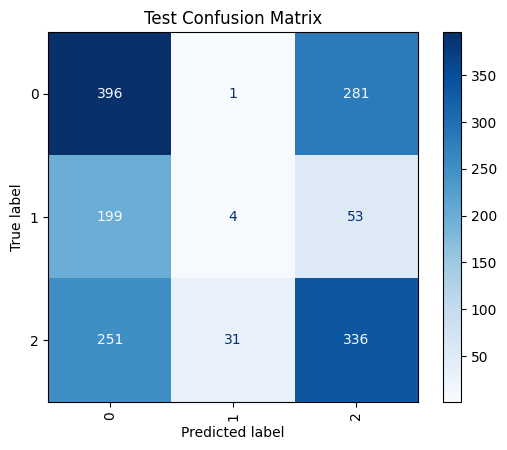

| ID | GPU | MEM |
------------------
|  0 |  6% | 18% |
###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.33it/s, gpu_mem=7.87 GB, lr=0.00010, train_loss=0.9604]


Train Acc: 0.5552 | Train Recall: 0.3832


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.43it/s, gpu_memory=3.22 GB, lr=0.00010, valid_loss=0.9894]


Valid Acc: 0.5875 | Valid Recall: 0.3405
Valid Score Improved (-inf ---> 0.5875)
Model Saved


Epoch 2/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.84it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.6574]


Train Acc: 0.7498 | Train Recall: 0.4655


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.23it/s, gpu_memory=3.26 GB, lr=0.00010, valid_loss=1.0885]


Valid Acc: 0.5156 | Valid Recall: 0.3462


Epoch 3/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.81it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.4503]


Train Acc: 0.8221 | Train Recall: 0.5443


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.35it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.3369]


Valid Acc: 0.4359 | Valid Recall: 0.3762


Epoch 4/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.84it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.2872]


Train Acc: 0.9051 | Train Recall: 0.7148


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.27it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=1.7284]


Valid Acc: 0.4242 | Valid Recall: 0.3799


Epoch 5/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.84it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.2116]


Train Acc: 0.9283 | Train Recall: 0.7803


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.41it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.8671]


Valid Acc: 0.4555 | Valid Recall: 0.4113


Epoch 6/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.85it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.1205]


Train Acc: 0.9609 | Train Recall: 0.8974


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.28it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=1.8673]


Valid Acc: 0.4977 | Valid Recall: 0.3994


Epoch 7/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0851]


Train Acc: 0.9760 | Train Recall: 0.9440


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.44it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.6344]


Valid Acc: 0.5766 | Valid Recall: 0.3792


Epoch 8/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.85it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0347]


Train Acc: 0.9924 | Train Recall: 0.9900


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.23it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=1.6931]


Valid Acc: 0.5711 | Valid Recall: 0.4034


Epoch 9/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.86it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0395]


Train Acc: 0.9909 | Train Recall: 0.9851


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.39it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.8829]


Valid Acc: 0.6000 | Valid Recall: 0.3787
Valid Score Improved (0.5875 ---> 0.6000)
Model Saved


Epoch 10/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0203]


Train Acc: 0.9961 | Train Recall: 0.9965


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.38it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.7684]


Valid Acc: 0.5672 | Valid Recall: 0.4022


Epoch 11/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0163]


Train Acc: 0.9974 | Train Recall: 0.9925


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.22it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.8088]


Valid Acc: 0.5773 | Valid Recall: 0.4010


Epoch 12/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0134]


Train Acc: 0.9961 | Train Recall: 0.9953


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.9703]


Valid Acc: 0.6133 | Valid Recall: 0.4148
Valid Score Improved (0.6000 ---> 0.6133)
Model Saved


Epoch 13/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.69it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0109]


Train Acc: 0.9974 | Train Recall: 0.9978


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.37it/s, gpu_memory=3.31 GB, lr=0.00010, valid_loss=1.9707]


Valid Acc: 0.5453 | Valid Recall: 0.4006


Epoch 14/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0173]


Train Acc: 0.9948 | Train Recall: 0.9941


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.48it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2012]


Valid Acc: 0.6188 | Valid Recall: 0.4008
Valid Score Improved (0.6133 ---> 0.6188)
Model Saved


Epoch 15/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.84it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0141]


Train Acc: 0.9961 | Train Recall: 0.9972


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.23it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.8943]


Valid Acc: 0.5945 | Valid Recall: 0.4058


Epoch 16/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0083]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.34it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.9642]


Valid Acc: 0.6273 | Valid Recall: 0.4054
Valid Score Improved (0.6188 ---> 0.6273)
Model Saved


Epoch 17/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.86it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0155]


Train Acc: 0.9930 | Train Recall: 0.9892


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.4173]


Valid Acc: 0.6164 | Valid Recall: 0.3938


Epoch 18/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0214]


Train Acc: 0.9948 | Train Recall: 0.9966


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.35it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.0900]


Valid Acc: 0.6219 | Valid Recall: 0.4103


Epoch 19/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.77it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0129]


Train Acc: 0.9937 | Train Recall: 0.9936


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.37it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.1344]


Valid Acc: 0.5898 | Valid Recall: 0.3921


Epoch 20/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.85it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0092]


Train Acc: 0.9969 | Train Recall: 0.9977


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.27it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2301]


Valid Acc: 0.5875 | Valid Recall: 0.3745


Epoch 21/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0059]


Train Acc: 0.9982 | Train Recall: 0.9985


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.1550]


Valid Acc: 0.5977 | Valid Recall: 0.3826


Epoch 22/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.84it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0062]


Train Acc: 0.9969 | Train Recall: 0.9968


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.37it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.1521]


Valid Acc: 0.5977 | Valid Recall: 0.3860


Epoch 23/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.84it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0038]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.35it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.1640]


Valid Acc: 0.5828 | Valid Recall: 0.3895


Epoch 24/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0046]


Train Acc: 0.9987 | Train Recall: 0.9994


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.42it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2449]


Valid Acc: 0.5375 | Valid Recall: 0.3855


Epoch 25/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.71it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0046]


Train Acc: 0.9974 | Train Recall: 0.9968


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.0123]


Valid Acc: 0.5648 | Valid Recall: 0.3840


Epoch 26/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.86it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0103]


Train Acc: 0.9982 | Train Recall: 0.9992


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.39it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.0434]


Valid Acc: 0.6344 | Valid Recall: 0.4240
Valid Score Improved (0.6273 ---> 0.6344)
Model Saved


Epoch 27/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0021]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.41it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.0050]


Valid Acc: 0.5633 | Valid Recall: 0.4017


Epoch 28/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0022]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.37it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.0994]


Valid Acc: 0.5469 | Valid Recall: 0.4020


Epoch 29/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0035]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.38it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.1733]


Valid Acc: 0.5570 | Valid Recall: 0.3713


Epoch 30/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.81it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0038]


Train Acc: 0.9982 | Train Recall: 0.9982


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.35it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.4182]


Valid Acc: 0.5867 | Valid Recall: 0.3743


Epoch 31/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.68it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0033]


Train Acc: 0.9987 | Train Recall: 0.9994


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3995]


Valid Acc: 0.5836 | Valid Recall: 0.3556


Epoch 32/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.84it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0029]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.25it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3648]


Valid Acc: 0.6148 | Valid Recall: 0.3903


Epoch 33/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0019]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.4390]


Valid Acc: 0.6211 | Valid Recall: 0.3938


Epoch 34/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0054]


Train Acc: 0.9982 | Train Recall: 0.9983


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2637]


Valid Acc: 0.6172 | Valid Recall: 0.3915


Epoch 35/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0014]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.39it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2968]


Valid Acc: 0.6062 | Valid Recall: 0.3799


Epoch 36/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0028]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.1243]


Valid Acc: 0.5930 | Valid Recall: 0.3756


Epoch 37/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.67it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0025]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.43it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.0135]


Valid Acc: 0.5539 | Valid Recall: 0.3735


Epoch 38/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.85it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0027]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.35it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3263]


Valid Acc: 0.5938 | Valid Recall: 0.3812


Epoch 39/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0035]


Train Acc: 0.9987 | Train Recall: 0.9983


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.42it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3223]


Valid Acc: 0.6008 | Valid Recall: 0.4057


Epoch 40/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.78it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0033]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.40it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3777]


Valid Acc: 0.5867 | Valid Recall: 0.3896


Epoch 41/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0013]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.32it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.4931]


Valid Acc: 0.5703 | Valid Recall: 0.3478


Epoch 42/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0009]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.26it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.5428]


Valid Acc: 0.5703 | Valid Recall: 0.3466


Epoch 43/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.64it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0017]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.33it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.6701]


Valid Acc: 0.5703 | Valid Recall: 0.3396


Epoch 44/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.81it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0011]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.25it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.5999]


Valid Acc: 0.5586 | Valid Recall: 0.3329


Epoch 45/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0041]


Train Acc: 0.9982 | Train Recall: 0.9992


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.30it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.3516]


Valid Acc: 0.5727 | Valid Recall: 0.3769


Epoch 46/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0058]


Train Acc: 0.9982 | Train Recall: 0.9978


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.40it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.2834]


Valid Acc: 0.5664 | Valid Recall: 0.3816


Epoch 47/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0033]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.37it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.5943]


Valid Acc: 0.6102 | Valid Recall: 0.3903


Epoch 48/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0018]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.38it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.6906]


Valid Acc: 0.6000 | Valid Recall: 0.3660


Epoch 49/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.66it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0068]


Train Acc: 0.9987 | Train Recall: 0.9994


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.30it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.0512]


Valid Acc: 0.5305 | Valid Recall: 0.3995


Epoch 50/50

Train : 100%|██████████| 6/6 [00:02<00:00,  2.83it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.0022]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 2/2 [00:00<00:00,  5.40it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=1.9167]


Valid Acc: 0.5844 | Valid Recall: 0.3990


Training complete in 0h 3m 5s
Best Score: 0.6344


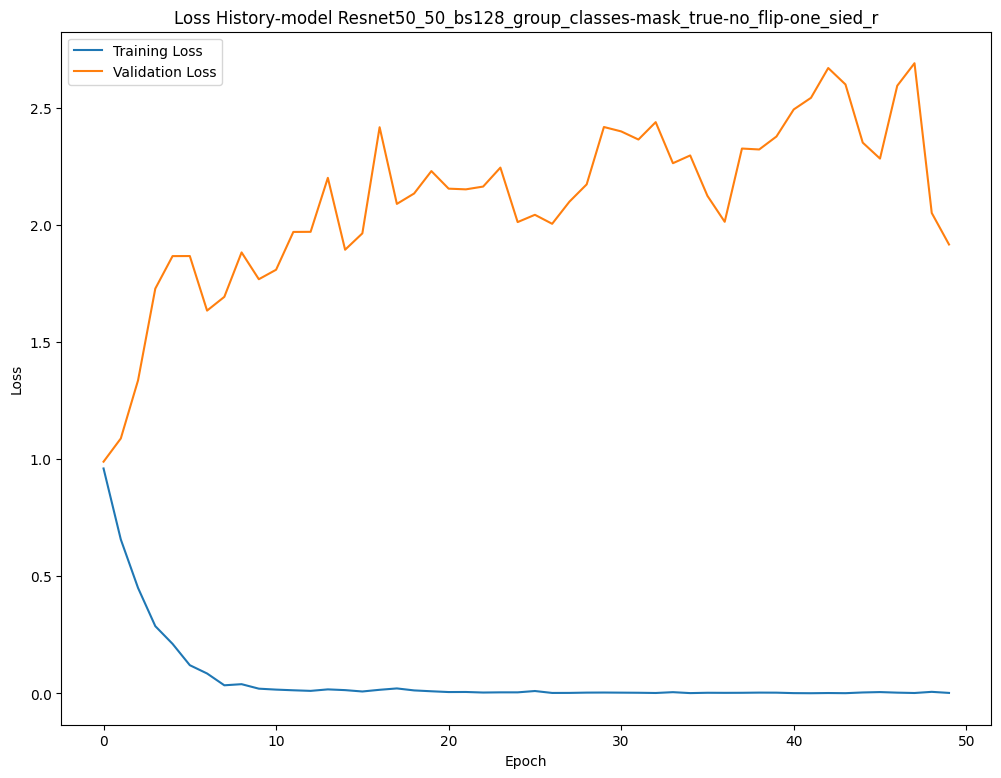

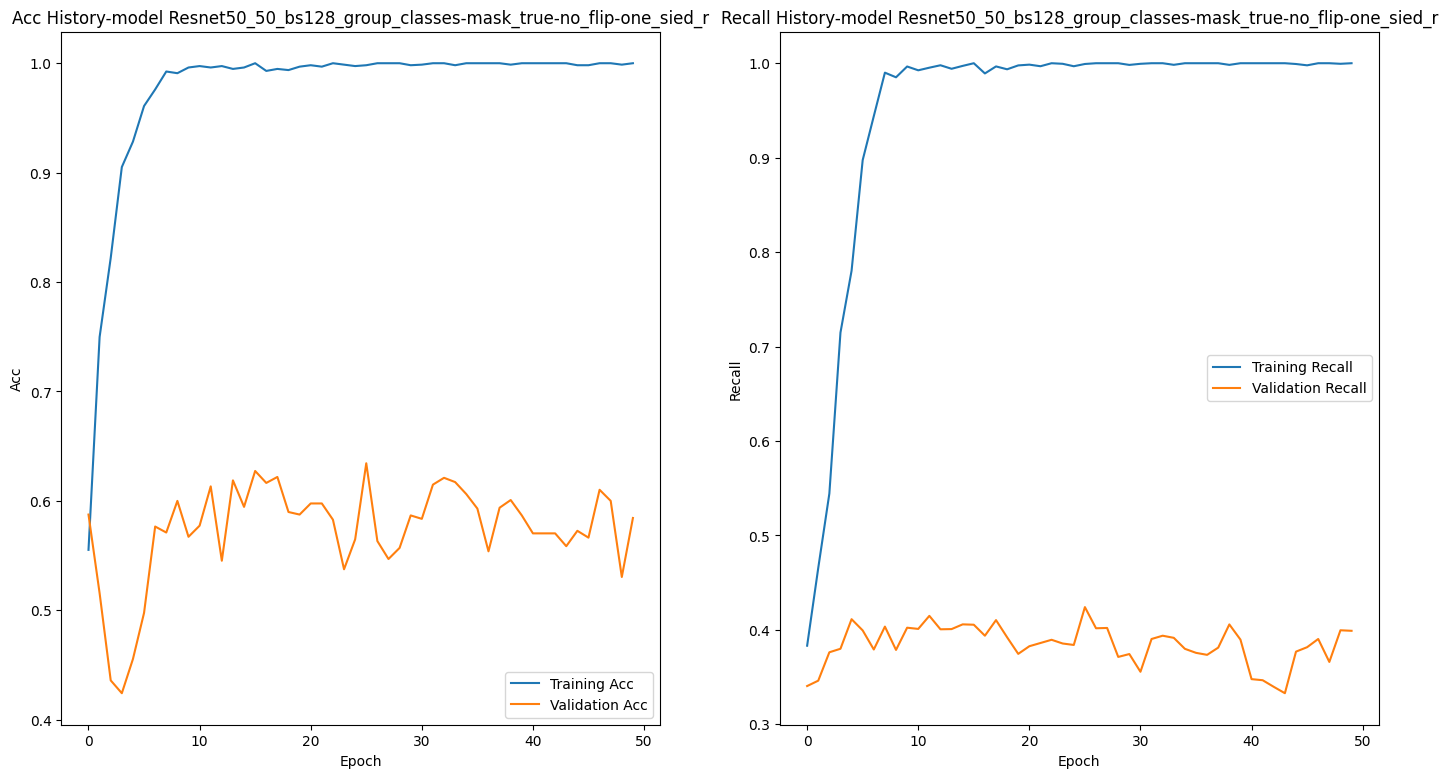

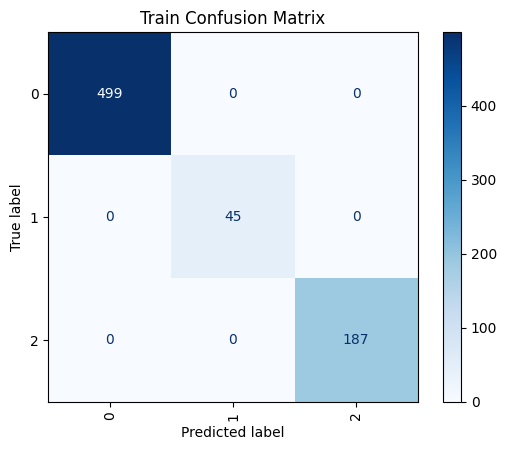

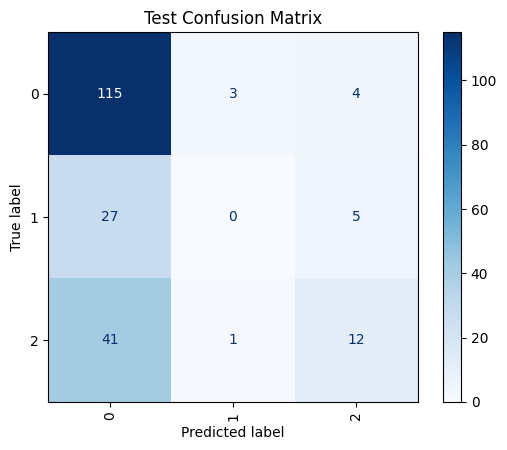

| ID | GPU | MEM |
------------------
|  0 |  2% | 20% |
###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 5/5 [00:02<00:00,  2.29it/s, gpu_mem=7.88 GB, lr=0.00010, train_loss=1.0539]


Train Acc: 0.4269 | Train Recall: 0.4237


Valid : 100%|██████████| 3/3 [00:00<00:00,  4.92it/s, gpu_memory=3.25 GB, lr=0.00010, valid_loss=1.4746]


Valid Acc: 0.2396 | Valid Recall: 0.1807
Valid Score Improved (-inf ---> 0.2396)
Model Saved


Epoch 2/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.8368]


Train Acc: 0.6265 | Train Recall: 0.5485


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.45it/s, gpu_memory=3.26 GB, lr=0.00010, valid_loss=1.5410]


Valid Acc: 0.2396 | Valid Recall: 0.2071


Epoch 3/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.6828]


Train Acc: 0.7251 | Train Recall: 0.6441


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.53it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=1.8779]


Valid Acc: 0.2708 | Valid Recall: 0.2311
Valid Score Improved (0.2396 ---> 0.2708)
Model Saved


Epoch 4/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.75it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.4734]


Train Acc: 0.8279 | Train Recall: 0.7649


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.39it/s, gpu_memory=3.28 GB, lr=0.00010, valid_loss=1.9411]


Valid Acc: 0.3099 | Valid Recall: 0.2503
Valid Score Improved (0.2708 ---> 0.3099)
Model Saved


Epoch 5/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.3276]


Train Acc: 0.8860 | Train Recall: 0.8440


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.5728]


Valid Acc: 0.2682 | Valid Recall: 0.2356


Epoch 6/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.58it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.2133]


Train Acc: 0.9372 | Train Recall: 0.9177


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=2.2287]


Valid Acc: 0.3281 | Valid Recall: 0.2501
Valid Score Improved (0.3099 ---> 0.3281)
Model Saved


Epoch 7/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.75it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.1222]


Train Acc: 0.9775 | Train Recall: 0.9714


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.6439]


Valid Acc: 0.2760 | Valid Recall: 0.2192


Epoch 8/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0727]


Train Acc: 0.9838 | Train Recall: 0.9808


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.27it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.1260]


Valid Acc: 0.2656 | Valid Recall: 0.2219


Epoch 9/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0456]


Train Acc: 0.9922 | Train Recall: 0.9903


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.44it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=3.0327]


Valid Acc: 0.2865 | Valid Recall: 0.2413


Epoch 10/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0222]


Train Acc: 0.9984 | Train Recall: 0.9987


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.7378]


Valid Acc: 0.2630 | Valid Recall: 0.2178


Epoch 11/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0209]


Train Acc: 0.9950 | Train Recall: 0.9963


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.42it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=3.5884]


Valid Acc: 0.2526 | Valid Recall: 0.1996


Epoch 12/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.57it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0148]


Train Acc: 0.9984 | Train Recall: 0.9983


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.5731]


Valid Acc: 0.2656 | Valid Recall: 0.2353


Epoch 13/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0097]


Train Acc: 0.9984 | Train Recall: 0.9987


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.50it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.3124]


Valid Acc: 0.2370 | Valid Recall: 0.2125


Epoch 14/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0110]


Train Acc: 0.9981 | Train Recall: 0.9987


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.38it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.5614]


Valid Acc: 0.2500 | Valid Recall: 0.2152


Epoch 15/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.69it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0092]


Train Acc: 0.9984 | Train Recall: 0.9988


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.1342]


Valid Acc: 0.2448 | Valid Recall: 0.1943


Epoch 16/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.75it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0067]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.46it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.3219]


Valid Acc: 0.2448 | Valid Recall: 0.2038


Epoch 17/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0055]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.55it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.4895]


Valid Acc: 0.2552 | Valid Recall: 0.2134


Epoch 18/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.57it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0031]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.45it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.5809]


Valid Acc: 0.2500 | Valid Recall: 0.2097


Epoch 19/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0035]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.4406]


Valid Acc: 0.2578 | Valid Recall: 0.2200


Epoch 20/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0072]


Train Acc: 0.9953 | Train Recall: 0.9934


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.34it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.2230]


Valid Acc: 0.2760 | Valid Recall: 0.2137


Epoch 21/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0032]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.45it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.2046]


Valid Acc: 0.2656 | Valid Recall: 0.1941


Epoch 22/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0036]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.37it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.7566]


Valid Acc: 0.2500 | Valid Recall: 0.1923


Epoch 23/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0040]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.35it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.8162]


Valid Acc: 0.2604 | Valid Recall: 0.2043


Epoch 24/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0048]


Train Acc: 0.9981 | Train Recall: 0.9986


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.5124]


Valid Acc: 0.2630 | Valid Recall: 0.2066


Epoch 25/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0117]


Train Acc: 0.9944 | Train Recall: 0.9926


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.53it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.1450]


Valid Acc: 0.2474 | Valid Recall: 0.1908


Epoch 26/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0063]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.52it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.9141]


Valid Acc: 0.2448 | Valid Recall: 0.1997


Epoch 27/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.70it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0064]


Train Acc: 0.9981 | Train Recall: 0.9988


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.54it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=5.5087]


Valid Acc: 0.2057 | Valid Recall: 0.1705


Epoch 28/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0056]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.40it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=5.3877]


Valid Acc: 0.2318 | Valid Recall: 0.1898


Epoch 29/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0048]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.47it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.3641]


Valid Acc: 0.2214 | Valid Recall: 0.1675


Epoch 30/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.56it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0023]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.4039]


Valid Acc: 0.2240 | Valid Recall: 0.1710


Epoch 31/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.75it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0059]


Train Acc: 0.9984 | Train Recall: 0.9978


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.45it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.7341]


Valid Acc: 0.2500 | Valid Recall: 0.1967


Epoch 32/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0017]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.46it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=5.2875]


Valid Acc: 0.2865 | Valid Recall: 0.2376


Epoch 33/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0030]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.55it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.8675]


Valid Acc: 0.2839 | Valid Recall: 0.2293


Epoch 34/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0025]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.3594]


Valid Acc: 0.2604 | Valid Recall: 0.1889


Epoch 35/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0038]


Train Acc: 0.9984 | Train Recall: 0.9988


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.49it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.3971]


Valid Acc: 0.2422 | Valid Recall: 0.1818


Epoch 36/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.56it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0014]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.42it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.6368]


Valid Acc: 0.2630 | Valid Recall: 0.2151


Epoch 37/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0013]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.46it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.7152]


Valid Acc: 0.2839 | Valid Recall: 0.2358


Epoch 38/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0011]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.49it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.6443]


Valid Acc: 0.2917 | Valid Recall: 0.2478


Epoch 39/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0011]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.42it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.6046]


Valid Acc: 0.2891 | Valid Recall: 0.2467


Epoch 40/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0020]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.44it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.8026]


Valid Acc: 0.2812 | Valid Recall: 0.2361


Epoch 41/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0008]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.8418]


Valid Acc: 0.2812 | Valid Recall: 0.2361


Epoch 42/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.54it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0009]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.50it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.7696]


Valid Acc: 0.2786 | Valid Recall: 0.2360


Epoch 43/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0009]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.6708]


Valid Acc: 0.2865 | Valid Recall: 0.2436


Epoch 44/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0007]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.47it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.6310]


Valid Acc: 0.2786 | Valid Recall: 0.2251


Epoch 45/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.74it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0005]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.54it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.6003]


Valid Acc: 0.2812 | Valid Recall: 0.2284


Epoch 46/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0007]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.51it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.5192]


Valid Acc: 0.2839 | Valid Recall: 0.2341


Epoch 47/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0015]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.50it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.5515]


Valid Acc: 0.2812 | Valid Recall: 0.2330


Epoch 48/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.53it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0004]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.52it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.6622]


Valid Acc: 0.2760 | Valid Recall: 0.2422


Epoch 49/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0008]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, gpu_memory=3.34 GB, lr=0.00010, valid_loss=4.8177]


Valid Acc: 0.2839 | Valid Recall: 0.2525


Epoch 50/50

Train : 100%|██████████| 5/5 [00:01<00:00,  2.70it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0007]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 3/3 [00:00<00:00,  5.45it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.7776]


Valid Acc: 0.2734 | Valid Recall: 0.2355


Training complete in 0h 2m 60s
Best Score: 0.3281


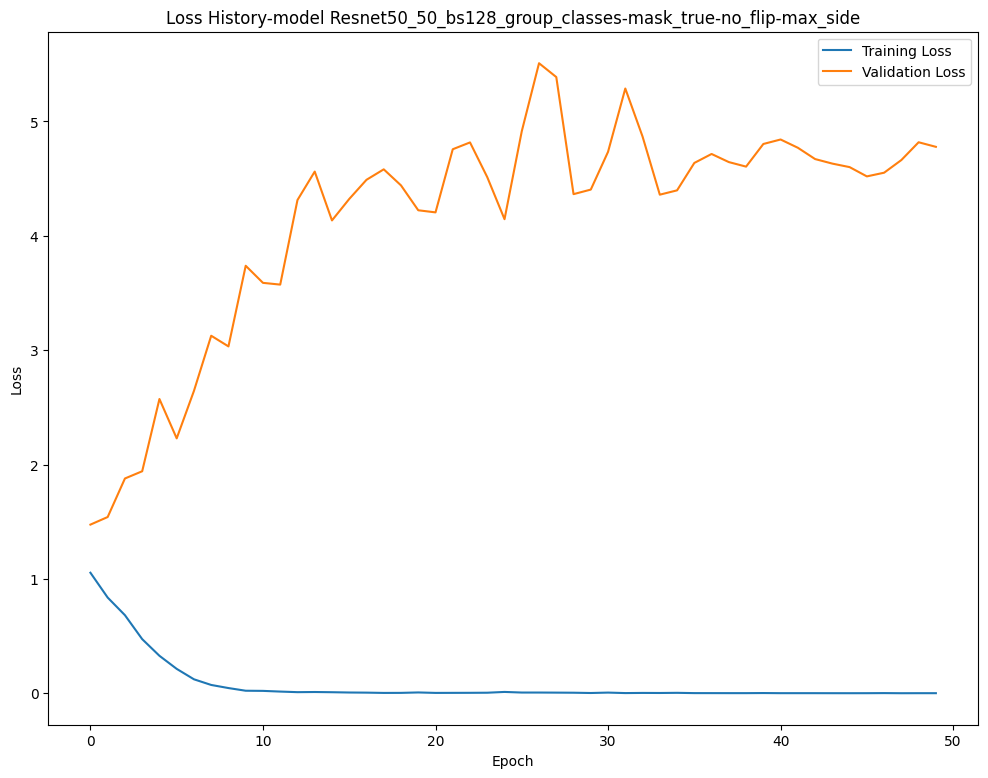

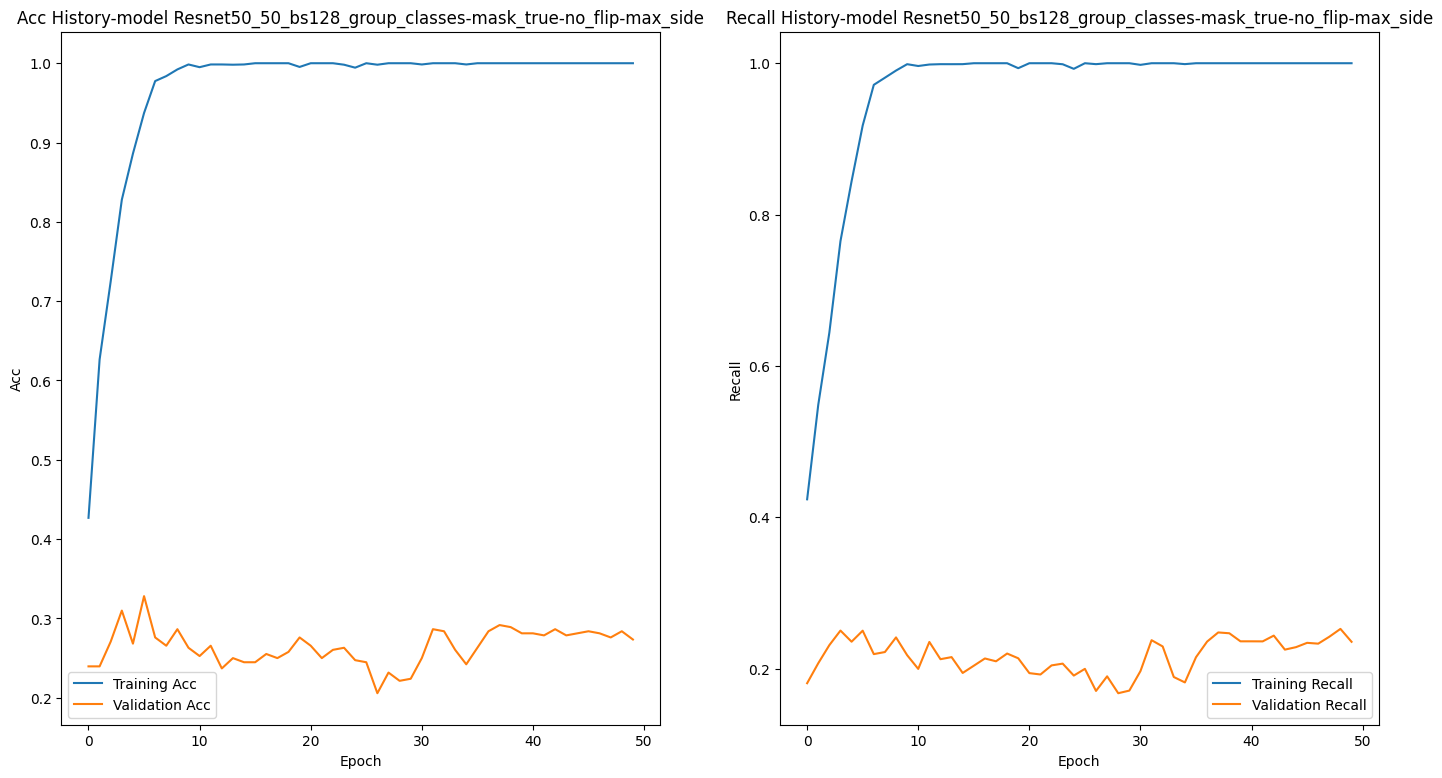

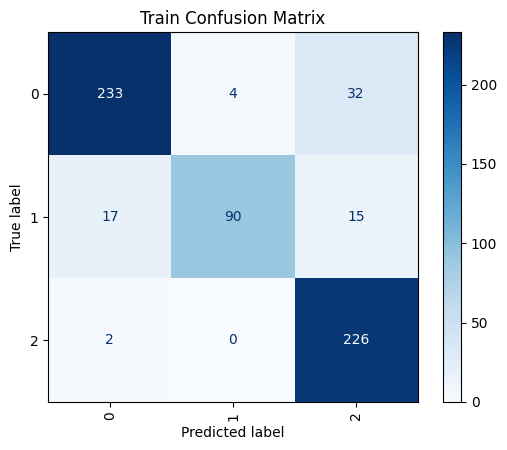

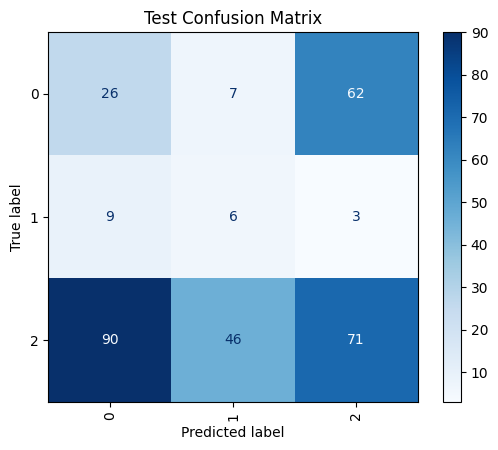

| ID | GPU | MEM |
------------------
|  0 |  2% | 20% |
###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 11/11 [00:04<00:00,  2.60it/s, gpu_mem=7.86 GB, lr=0.00010, train_loss=0.8846]


Train Acc: 0.6315 | Train Recall: 0.3515


Valid : 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, gpu_memory=2.98 GB, lr=0.00010, valid_loss=1.0017]


Valid Acc: 0.4916 | Valid Recall: 0.3815
Valid Score Improved (-inf ---> 0.4916)
Model Saved


Epoch 2/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.90it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.7029]


Train Acc: 0.6994 | Train Recall: 0.4444


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, gpu_memory=3.01 GB, lr=0.00010, valid_loss=1.1328]


Valid Acc: 0.5054 | Valid Recall: 0.3866
Valid Score Improved (0.4916 ---> 0.5054)
Model Saved


Epoch 3/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.5597]


Train Acc: 0.7506 | Train Recall: 0.5260


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.28it/s, gpu_memory=3.03 GB, lr=0.00010, valid_loss=1.2118]


Valid Acc: 0.5614 | Valid Recall: 0.4047
Valid Score Improved (0.5054 ---> 0.5614)
Model Saved


Epoch 4/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.79it/s, gpu_mem=8.11 GB, lr=0.00010, train_loss=0.4011]


Train Acc: 0.8261 | Train Recall: 0.6843


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, gpu_memory=3.05 GB, lr=0.00010, valid_loss=1.0417]


Valid Acc: 0.6661 | Valid Recall: 0.3720
Valid Score Improved (0.5614 ---> 0.6661)
Model Saved


Epoch 5/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.2981]


Train Acc: 0.8687 | Train Recall: 0.7746


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, gpu_memory=3.05 GB, lr=0.00010, valid_loss=1.0497]


Valid Acc: 0.6741 | Valid Recall: 0.4770
Valid Score Improved (0.6661 ---> 0.6741)
Model Saved


Epoch 6/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.2056]


Train Acc: 0.9250 | Train Recall: 0.8834


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, gpu_memory=3.06 GB, lr=0.00010, valid_loss=1.3373]


Valid Acc: 0.6543 | Valid Recall: 0.4626


Epoch 7/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.1300]


Train Acc: 0.9627 | Train Recall: 0.9488


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.25it/s, gpu_memory=3.05 GB, lr=0.00010, valid_loss=1.2050]


Valid Acc: 0.6786 | Valid Recall: 0.4984
Valid Score Improved (0.6741 ---> 0.6786)
Model Saved


Epoch 8/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0898]


Train Acc: 0.9692 | Train Recall: 0.9445


Valid : 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, gpu_memory=3.06 GB, lr=0.00010, valid_loss=1.2049]


Valid Acc: 0.6941 | Valid Recall: 0.4544
Valid Score Improved (0.6786 ---> 0.6941)
Model Saved


Epoch 9/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.13 GB, lr=0.00010, train_loss=0.0721]


Train Acc: 0.9762 | Train Recall: 0.9678


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, gpu_memory=3.05 GB, lr=0.00010, valid_loss=1.2200]


Valid Acc: 0.6802 | Valid Recall: 0.4885


Epoch 10/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0576]


Train Acc: 0.9814 | Train Recall: 0.9736


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.2251]


Valid Acc: 0.6866 | Valid Recall: 0.4382


Epoch 11/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.0431]


Train Acc: 0.9862 | Train Recall: 0.9822


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.0575]


Valid Acc: 0.7056 | Valid Recall: 0.4901
Valid Score Improved (0.6941 ---> 0.7056)
Model Saved


Epoch 12/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0279]


Train Acc: 0.9936 | Train Recall: 0.9908


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.1139]


Valid Acc: 0.7020 | Valid Recall: 0.5135


Epoch 13/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.80it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0213]


Train Acc: 0.9950 | Train Recall: 0.9964


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.1207]


Valid Acc: 0.6948 | Valid Recall: 0.4969


Epoch 14/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0202]


Train Acc: 0.9957 | Train Recall: 0.9948


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.2096]


Valid Acc: 0.7143 | Valid Recall: 0.4721
Valid Score Improved (0.7056 ---> 0.7143)
Model Saved


Epoch 15/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0156]


Train Acc: 0.9957 | Train Recall: 0.9964


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.19it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.2298]


Valid Acc: 0.7034 | Valid Recall: 0.4603


Epoch 16/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.16 GB, lr=0.00010, train_loss=0.0142]


Train Acc: 0.9971 | Train Recall: 0.9981


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.3149]


Valid Acc: 0.7229 | Valid Recall: 0.4684
Valid Score Improved (0.7143 ---> 0.7229)
Model Saved


Epoch 17/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0117]


Train Acc: 0.9972 | Train Recall: 0.9957


Valid : 100%|██████████| 4/4 [00:00<00:00,  4.57it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4718]


Valid Acc: 0.6844 | Valid Recall: 0.4755


Epoch 18/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.0277]


Train Acc: 0.9907 | Train Recall: 0.9918


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.6093]


Valid Acc: 0.6990 | Valid Recall: 0.4823


Epoch 19/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0430]


Train Acc: 0.9871 | Train Recall: 0.9818


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.21it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5151]


Valid Acc: 0.6912 | Valid Recall: 0.4739


Epoch 20/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0369]


Train Acc: 0.9921 | Train Recall: 0.9851


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5016]


Valid Acc: 0.6824 | Valid Recall: 0.5398


Epoch 21/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0183]


Train Acc: 0.9927 | Train Recall: 0.9932


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5492]


Valid Acc: 0.6713 | Valid Recall: 0.5720


Epoch 22/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.81it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0210]


Train Acc: 0.9950 | Train Recall: 0.9917


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4053]


Valid Acc: 0.6668 | Valid Recall: 0.5600


Epoch 23/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.90it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0236]


Train Acc: 0.9899 | Train Recall: 0.9885


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4561]


Valid Acc: 0.7012 | Valid Recall: 0.5062


Epoch 24/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0130]


Train Acc: 0.9955 | Train Recall: 0.9944


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.26it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.2866]


Valid Acc: 0.6899 | Valid Recall: 0.5628


Epoch 25/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0127]


Train Acc: 0.9972 | Train Recall: 0.9962


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.3789]


Valid Acc: 0.6860 | Valid Recall: 0.5314


Epoch 26/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.79it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0086]


Train Acc: 0.9986 | Train Recall: 0.9972


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.3299]


Valid Acc: 0.7162 | Valid Recall: 0.4917


Epoch 27/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0074]


Train Acc: 0.9986 | Train Recall: 0.9989


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4139]


Valid Acc: 0.7214 | Valid Recall: 0.4918


Epoch 28/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0068]


Train Acc: 0.9979 | Train Recall: 0.9946


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.22it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.3819]


Valid Acc: 0.7159 | Valid Recall: 0.4864


Epoch 29/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0071]


Train Acc: 0.9986 | Train Recall: 0.9992


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4179]


Valid Acc: 0.6995 | Valid Recall: 0.4881


Epoch 30/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.78it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0038]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.21it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4025]


Valid Acc: 0.7237 | Valid Recall: 0.5168
Valid Score Improved (0.7229 ---> 0.7237)
Model Saved


Epoch 31/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0075]


Train Acc: 0.9979 | Train Recall: 0.9982


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5677]


Valid Acc: 0.6629 | Valid Recall: 0.4737


Epoch 32/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.90it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0070]


Train Acc: 0.9986 | Train Recall: 0.9984


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.34it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5322]


Valid Acc: 0.7048 | Valid Recall: 0.4921


Epoch 33/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0052]


Train Acc: 0.9986 | Train Recall: 0.9975


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5591]


Valid Acc: 0.7072 | Valid Recall: 0.5722


Epoch 34/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0022]


Train Acc: 0.9993 | Train Recall: 0.9991


Valid : 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5191]


Valid Acc: 0.7066 | Valid Recall: 0.4895


Epoch 35/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0015]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5130]


Valid Acc: 0.7036 | Valid Recall: 0.4816


Epoch 36/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0021]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5643]


Valid Acc: 0.6983 | Valid Recall: 0.5462


Epoch 37/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0018]


Train Acc: 0.9993 | Train Recall: 0.9992


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.14it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5119]


Valid Acc: 0.7022 | Valid Recall: 0.5023


Epoch 38/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0039]


Train Acc: 0.9992 | Train Recall: 0.9995


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.31it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4692]


Valid Acc: 0.7248 | Valid Recall: 0.5064
Valid Score Improved (0.7237 ---> 0.7248)
Model Saved


Epoch 39/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0073]


Train Acc: 0.9986 | Train Recall: 0.9968


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.33it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.7579]


Valid Acc: 0.7170 | Valid Recall: 0.5696


Epoch 40/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0084]


Train Acc: 0.9986 | Train Recall: 0.9990


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.29it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.6478]


Valid Acc: 0.6989 | Valid Recall: 0.5132


Epoch 41/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0057]


Train Acc: 0.9986 | Train Recall: 0.9992


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.27it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5861]


Valid Acc: 0.7027 | Valid Recall: 0.5035


Epoch 42/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0159]


Train Acc: 0.9942 | Train Recall: 0.9910


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.25it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.7523]


Valid Acc: 0.6866 | Valid Recall: 0.4315


Epoch 43/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.79it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0078]


Train Acc: 0.9986 | Train Recall: 0.9977


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.24it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.6923]


Valid Acc: 0.6941 | Valid Recall: 0.4403


Epoch 44/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.90it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0093]


Train Acc: 0.9964 | Train Recall: 0.9897


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.28it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.6316]


Valid Acc: 0.7055 | Valid Recall: 0.4744


Epoch 45/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0114]


Train Acc: 0.9964 | Train Recall: 0.9945


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.18it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=2.0058]


Valid Acc: 0.6580 | Valid Recall: 0.5841


Epoch 46/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0100]


Train Acc: 0.9972 | Train Recall: 0.9966


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.23it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.6981]


Valid Acc: 0.6938 | Valid Recall: 0.5017


Epoch 47/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.80it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0080]


Train Acc: 0.9964 | Train Recall: 0.9924


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5248]


Valid Acc: 0.6716 | Valid Recall: 0.5330


Epoch 48/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.89it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0169]


Train Acc: 0.9957 | Train Recall: 0.9940


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.5625]


Valid Acc: 0.6966 | Valid Recall: 0.4948


Epoch 49/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0220]


Train Acc: 0.9936 | Train Recall: 0.9900


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.26it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4333]


Valid Acc: 0.7346 | Valid Recall: 0.4832
Valid Score Improved (0.7248 ---> 0.7346)
Model Saved


Epoch 50/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0264]


Train Acc: 0.9914 | Train Recall: 0.9943


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, gpu_memory=3.08 GB, lr=0.00010, valid_loss=1.4687]


Valid Acc: 0.6869 | Valid Recall: 0.5004


Training complete in 0h 4m 51s
Best Score: 0.7346


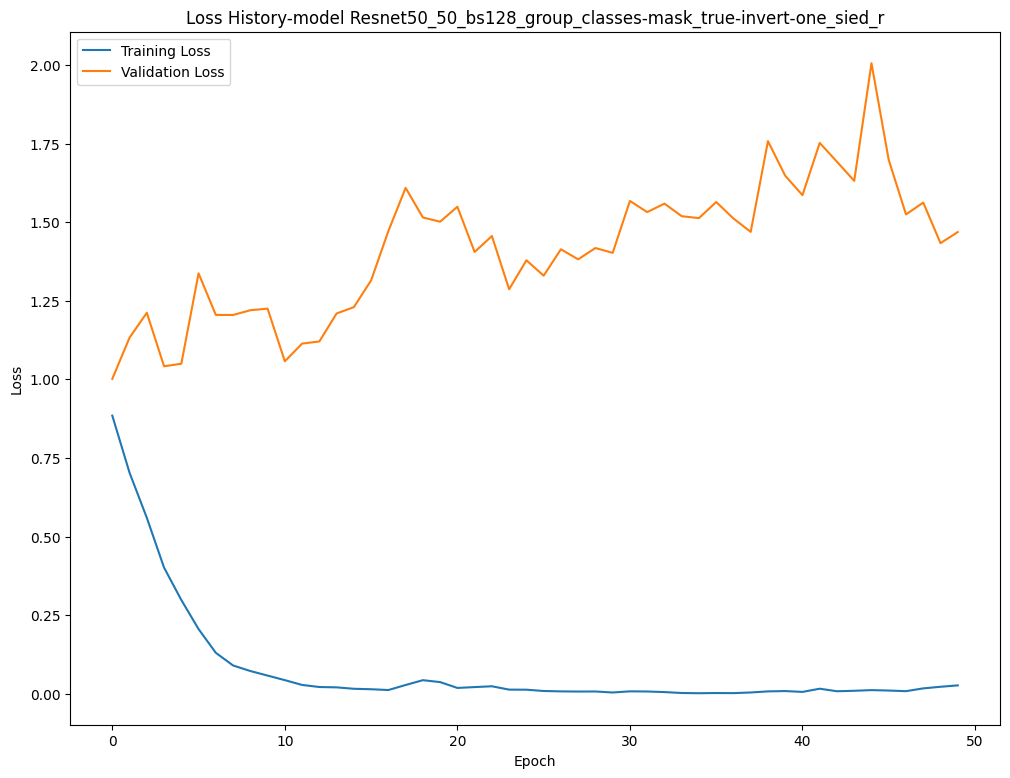

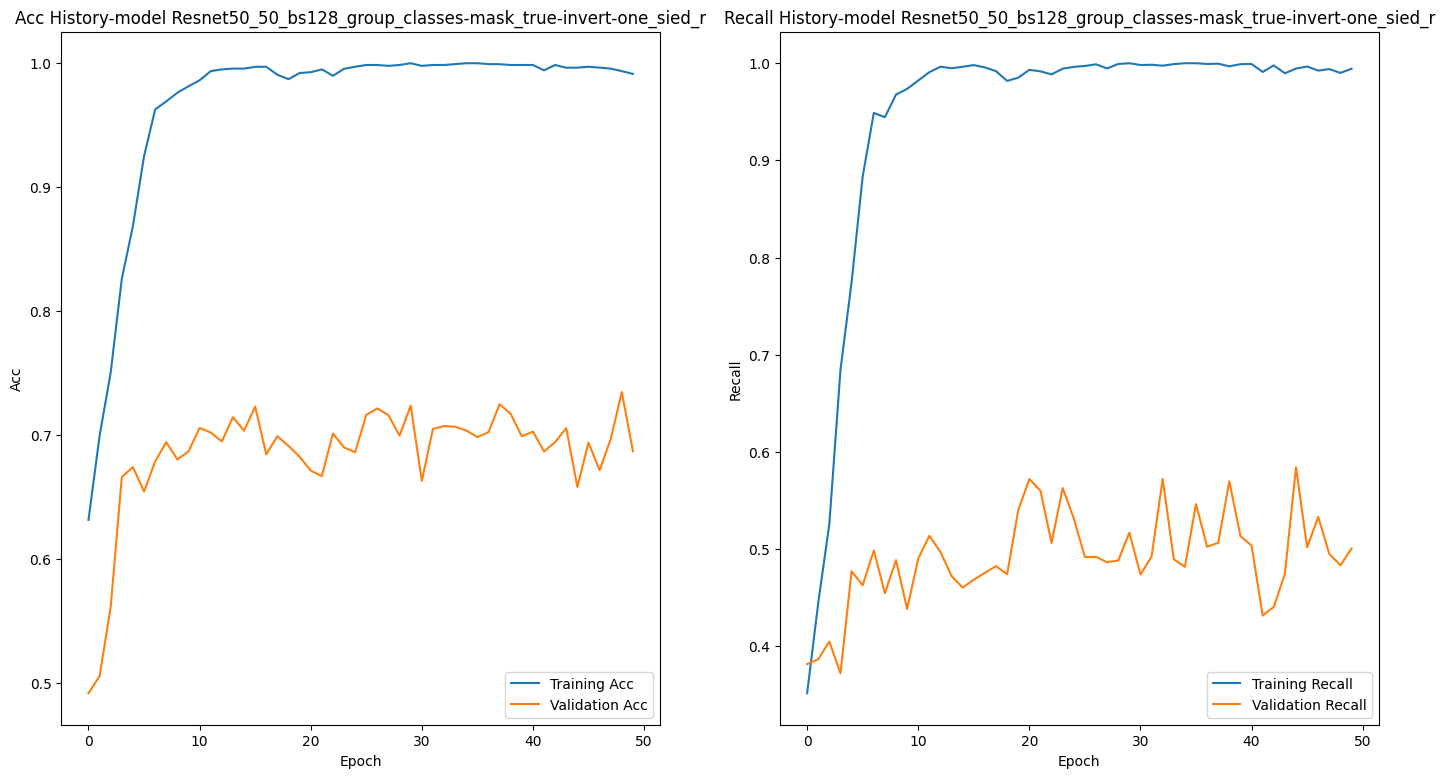

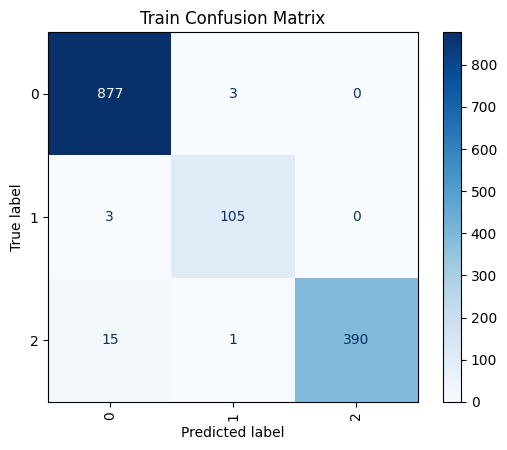

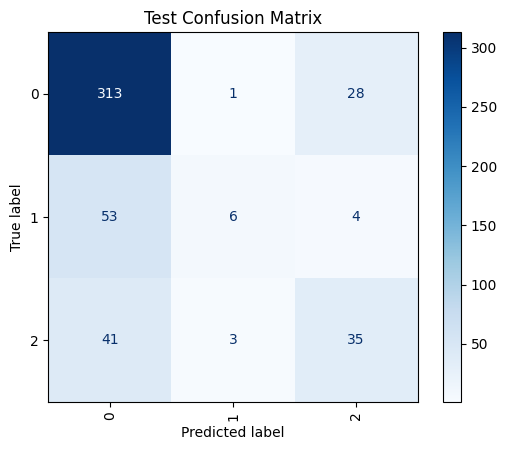

| ID | GPU | MEM |
------------------
|  0 |  5% | 19% |
###############
### Fold: 0
###############


cuda: NVIDIA GeForce RTX 3090

Epoch 1/50

Train : 100%|██████████| 11/11 [00:04<00:00,  2.73it/s, gpu_mem=7.88 GB, lr=0.00010, train_loss=0.9057]


Train Acc: 0.5447 | Train Recall: 0.4123


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, gpu_memory=3.21 GB, lr=0.00010, valid_loss=1.2764]


Valid Acc: 0.3027 | Valid Recall: 0.3143
Valid Score Improved (-inf ---> 0.3027)
Model Saved


Epoch 2/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.10 GB, lr=0.00010, train_loss=0.5474]


Train Acc: 0.7918 | Train Recall: 0.7173


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, gpu_memory=3.25 GB, lr=0.00010, valid_loss=1.6508]


Valid Acc: 0.3559 | Valid Recall: 0.3171
Valid Score Improved (0.3027 ---> 0.3559)
Model Saved


Epoch 3/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.2297]


Train Acc: 0.9390 | Train Recall: 0.9357


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.3429]


Valid Acc: 0.3656 | Valid Recall: 0.2942
Valid Score Improved (0.3559 ---> 0.3656)
Model Saved


Epoch 4/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.80it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.0961]


Train Acc: 0.9735 | Train Recall: 0.9702


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.8037]


Valid Acc: 0.3793 | Valid Recall: 0.3077
Valid Score Improved (0.3656 ---> 0.3793)
Model Saved


Epoch 5/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0396]


Train Acc: 0.9934 | Train Recall: 0.9927


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, gpu_memory=3.32 GB, lr=0.00010, valid_loss=2.6391]


Valid Acc: 0.3804 | Valid Recall: 0.3141
Valid Score Improved (0.3793 ---> 0.3804)
Model Saved


Epoch 6/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0212]


Train Acc: 0.9948 | Train Recall: 0.9966


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.4678]


Valid Acc: 0.3957 | Valid Recall: 0.3237
Valid Score Improved (0.3804 ---> 0.3957)
Model Saved


Epoch 7/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.0144]


Train Acc: 0.9979 | Train Recall: 0.9962


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.5365]


Valid Acc: 0.3530 | Valid Recall: 0.2913


Epoch 8/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.77it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.0109]


Train Acc: 0.9986 | Train Recall: 0.9989


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.6150]


Valid Acc: 0.3739 | Valid Recall: 0.2920


Epoch 9/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.0077]


Train Acc: 0.9993 | Train Recall: 0.9994


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.5434]


Valid Acc: 0.3931 | Valid Recall: 0.3029


Epoch 10/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.14 GB, lr=0.00010, train_loss=0.0046]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.7483]


Valid Acc: 0.3798 | Valid Recall: 0.3070


Epoch 11/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0043]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.9533]


Valid Acc: 0.3736 | Valid Recall: 0.2790


Epoch 12/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.78it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0040]


Train Acc: 0.9993 | Train Recall: 0.9996


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.7480]


Valid Acc: 0.3962 | Valid Recall: 0.2972
Valid Score Improved (0.3957 ---> 0.3962)
Model Saved


Epoch 13/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0042]


Train Acc: 0.9986 | Train Recall: 0.9979


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.9085]


Valid Acc: 0.3823 | Valid Recall: 0.3011


Epoch 14/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0027]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.8782]


Valid Acc: 0.3738 | Valid Recall: 0.2671


Epoch 15/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0023]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.6863]


Valid Acc: 0.3866 | Valid Recall: 0.2849


Epoch 16/50

Train : 100%|██████████| 11/11 [00:04<00:00,  2.75it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0034]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.8614]


Valid Acc: 0.3580 | Valid Recall: 0.2706


Epoch 17/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.83it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0039]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.0106]


Valid Acc: 0.3435 | Valid Recall: 0.2713


Epoch 18/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.83it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0048]


Train Acc: 0.9986 | Train Recall: 0.9988


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.9303]


Valid Acc: 0.3772 | Valid Recall: 0.2867


Epoch 19/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.82it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0025]


Train Acc: 0.9993 | Train Recall: 0.9996


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.2051]


Valid Acc: 0.3940 | Valid Recall: 0.3097


Epoch 20/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.75it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0041]


Train Acc: 0.9985 | Train Recall: 0.9983


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.7297]


Valid Acc: 0.3873 | Valid Recall: 0.3109


Epoch 21/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.84it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0034]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.6848]


Valid Acc: 0.4184 | Valid Recall: 0.3156
Valid Score Improved (0.3962 ---> 0.4184)
Model Saved


Epoch 22/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.82it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0085]


Train Acc: 0.9979 | Train Recall: 0.9984


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.0001]


Valid Acc: 0.3987 | Valid Recall: 0.3072


Epoch 23/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0093]


Train Acc: 0.9979 | Train Recall: 0.9982


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.5749]


Valid Acc: 0.3884 | Valid Recall: 0.2869


Epoch 24/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.77it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0137]


Train Acc: 0.9949 | Train Recall: 0.9962


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.5030]


Valid Acc: 0.4053 | Valid Recall: 0.3067


Epoch 25/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0117]


Train Acc: 0.9949 | Train Recall: 0.9961


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.15it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.8262]


Valid Acc: 0.3948 | Valid Recall: 0.2975


Epoch 26/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.88it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0080]


Train Acc: 0.9979 | Train Recall: 0.9986


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.7700]


Valid Acc: 0.4326 | Valid Recall: 0.3052
Valid Score Improved (0.4184 ---> 0.4326)
Model Saved


Epoch 27/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0122]


Train Acc: 0.9971 | Train Recall: 0.9980


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.0450]


Valid Acc: 0.3288 | Valid Recall: 0.2810


Epoch 28/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.83it/s, gpu_mem=8.12 GB, lr=0.00010, train_loss=0.0139]


Train Acc: 0.9957 | Train Recall: 0.9957


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.2126]


Valid Acc: 0.3991 | Valid Recall: 0.3466


Epoch 29/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0103]


Train Acc: 0.9963 | Train Recall: 0.9966


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.8649]


Valid Acc: 0.3865 | Valid Recall: 0.3440


Epoch 30/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0105]


Train Acc: 0.9972 | Train Recall: 0.9961


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.05it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.5827]


Valid Acc: 0.3500 | Valid Recall: 0.2886


Epoch 31/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0042]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.0722]


Valid Acc: 0.3942 | Valid Recall: 0.3007


Epoch 32/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.77it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0032]


Train Acc: 0.9993 | Train Recall: 0.9996


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.0959]


Valid Acc: 0.3881 | Valid Recall: 0.3152


Epoch 33/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0018]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.4947]


Valid Acc: 0.3692 | Valid Recall: 0.3022


Epoch 34/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0012]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.06it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.2945]


Valid Acc: 0.3876 | Valid Recall: 0.3062


Epoch 35/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.84it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0013]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.3233]


Valid Acc: 0.3845 | Valid Recall: 0.3210


Epoch 36/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.75it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0014]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.3262]


Valid Acc: 0.3915 | Valid Recall: 0.3152


Epoch 37/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.84it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0018]


Train Acc: 0.9993 | Train Recall: 0.9993


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.13it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.1950]


Valid Acc: 0.4113 | Valid Recall: 0.3212


Epoch 38/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.84it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0025]


Train Acc: 0.9993 | Train Recall: 0.9996


Valid : 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.3903]


Valid Acc: 0.3823 | Valid Recall: 0.3002


Epoch 39/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.87it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0005]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.3937]


Valid Acc: 0.3711 | Valid Recall: 0.2903


Epoch 40/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.76it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0006]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.07it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.4008]


Valid Acc: 0.3700 | Valid Recall: 0.2936


Epoch 41/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.83it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0006]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.09it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.3954]


Valid Acc: 0.3639 | Valid Recall: 0.2898


Epoch 42/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.82it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0006]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.5798]


Valid Acc: 0.3659 | Valid Recall: 0.2930


Epoch 43/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0005]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.04it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.7054]


Valid Acc: 0.3664 | Valid Recall: 0.2900


Epoch 44/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.77it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0003]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.10it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.5945]


Valid Acc: 0.3684 | Valid Recall: 0.2986


Epoch 45/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0005]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.08it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.3895]


Valid Acc: 0.3734 | Valid Recall: 0.2994


Epoch 46/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0013]


Train Acc: 0.9993 | Train Recall: 0.9996


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.3699]


Valid Acc: 0.3678 | Valid Recall: 0.2979


Epoch 47/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0027]


Train Acc: 0.9986 | Train Recall: 0.9988


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=3.2285]


Valid Acc: 0.4020 | Valid Recall: 0.3030


Epoch 48/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.78it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0019]


Train Acc: 0.9993 | Train Recall: 0.9996


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.12it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.1825]


Valid Acc: 0.3372 | Valid Recall: 0.2739


Epoch 49/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.86it/s, gpu_mem=8.17 GB, lr=0.00010, train_loss=0.0029]


Train Acc: 1.0000 | Train Recall: 1.0000


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=2.7344]


Valid Acc: 0.4487 | Valid Recall: 0.3220
Valid Score Improved (0.4326 ---> 0.4487)
Model Saved


Epoch 50/50

Train : 100%|██████████| 11/11 [00:03<00:00,  2.85it/s, gpu_mem=8.15 GB, lr=0.00010, train_loss=0.0029]


Train Acc: 0.9986 | Train Recall: 0.9990


Valid : 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, gpu_memory=3.33 GB, lr=0.00010, valid_loss=4.0063]


Valid Acc: 0.3244 | Valid Recall: 0.2687


Training complete in 0h 4m 54s
Best Score: 0.4487


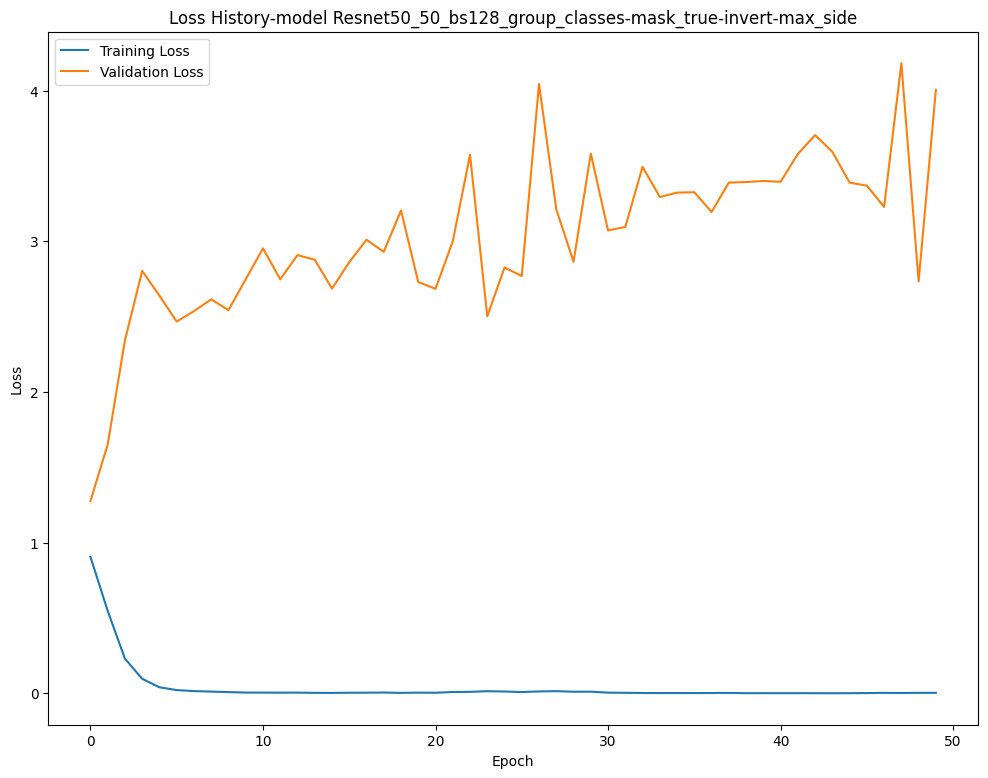

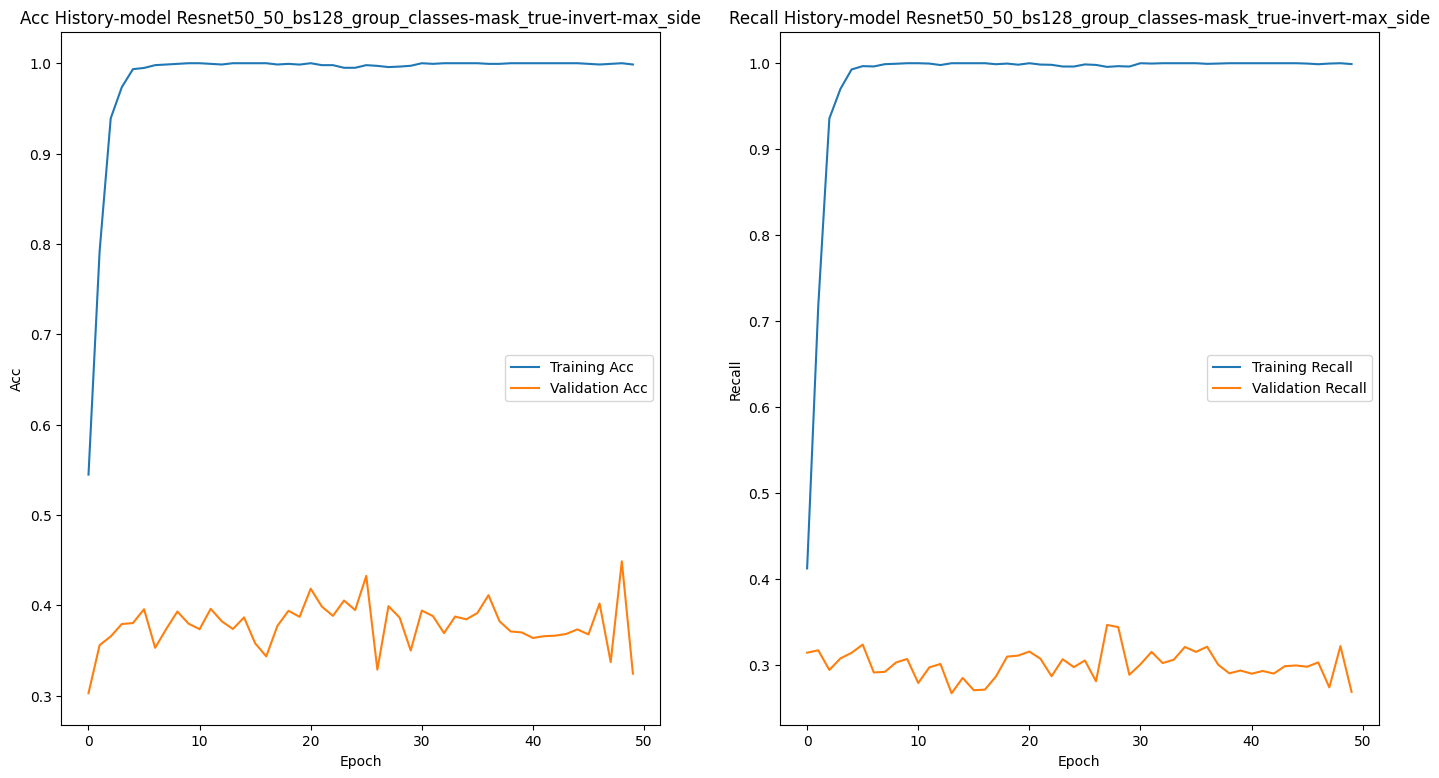

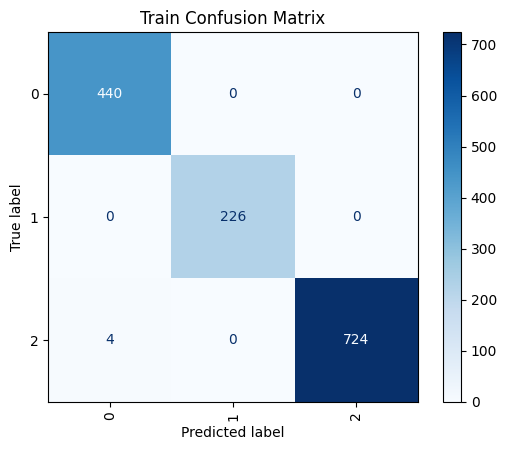

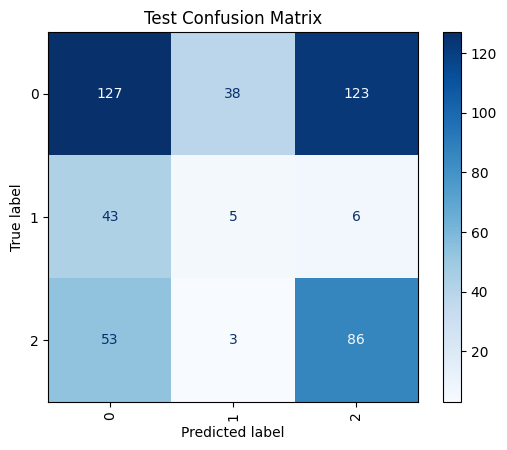

| ID | GPU | MEM |
------------------
|  0 |  2% | 20% |
 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.001523709319360784 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r VAL ACC MAX:0.3668087121212121 VAL Recall MAX:0.20032970527530014 VAL Loss MIN:1.903796438852946 
 
 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side Train ACC MAX:0.9986979166666666 Train Recall MAX:0.9990693223358219 Train Loss MIN:0.005561340128032255 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side VAL ACC MAX:0.28794642857142855 VAL Recall MAX:0.27719376593658207 VAL Loss MIN:1.9249997212336614 
 
 MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r Train ACC MAX:0.9984809027777778 Train Recall MAX:0.9988728484479178 Train Loss MIN:0.00854318798611942 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r VAL ACC MAX:0.38859097633136097

In [152]:

for class_type in ['all_classes','group_classes']:
    for is_mask in ['mask_false','mask_true']:
        for flip in  ['no_flip','invert']:
            for side in ['one_sied_r','max_side']:
                if class_type!='all_classes' :
                    def criterion(y_pred, y_true):
                        loss = nn.CrossEntropyLoss()
                        return loss(y_pred, y_true)
                    
                    def build_model():
                        # model = smp.UnetPlusPlus(
                        #     encoder_name='tu-'+seg_model ,     # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                        #     encoder_weights=None,# use `imagenet` pre-trained weights for encoder initialization
                        #     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                        #     classes=1   ,     # model output channels (number of classes in your dataset)
                        #     activation=None,
                        # )
                        if class_type =='all_classes':
                            n_classes = 6
                        elif class_type == 'group_classes':
                            n_classes = 3
                        base_model = resnet50(pretrained=True)
                        original_conv1_weight = base_model.conv1.weight.data
                        original_conv1_weight_mean = original_conv1_weight.mean(dim=1, keepdim=True)
                        # Create a new convolutional layer with 1 input channel instead of 3
                        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                        # Assign the original weights to the new convolutional layerd
                        base_model.conv1.weight.data = original_conv1_weight_mean

                        # modules = list(base_model.children())[:-2]
                        # base_model = nn.Sequential(*modules)
                        # custom_base_model = CustomResNet50(base_model, n_classes)



                        # base_model.features[0][0] = nn.Conv2d(
                        #     in_channels=1,  # Change to 1 for single-channel input
                        #     out_channels=base_model.features[0][0].out_channels,
                        #     kernel_size=base_model.features[0][0].kernel_size,
                        #     stride=base_model.features[0][0].stride,
                        #     padding=base_model.features[0][0].padding,
                        #     bias=base_model.features[0][0].bias,
                        # )
                        base_model.fc = nn.Linear(2048, n_classes)
                        base_model.to('cuda')
                        return base_model

                    def load_model(path):
                        model = build_model()
                        model.load_state_dict(torch.load(path))
                        model.eval()
                        return model
                    x_train,y_train,x_val,y_val = data_preproc(is_mask,flip,'data_29_05_24_cls108_seg72')
                    if class_type =='all_classes' and side == 'one_sied_r':
                        train_dataset = BuildDatasetR(x_train,y_train, transforms=data_transforms['train'])
                        val_dataset = BuildDatasetR(x_val,y_val, transforms=data_transforms['valid'])
                    elif class_type == 'group_classes' and side == 'one_sied_r':
                        train_dataset = BuildDatasetGroupR(x_train,y_train, transforms=data_transforms['train'])
                        val_dataset = BuildDatasetGroupR(x_val,y_val, transforms=data_transforms['valid'])                       
                    elif class_type == 'all_classes' and side == 'max_side':
                        train_dataset = BuildDatasetMax(x_train,y_train, transforms=data_transforms['train'])
                        val_dataset = BuildDatasetMax(x_val,y_val, transforms=data_transforms['valid']) 
                    elif class_type == 'group_classes' and side == 'max_side':
                        train_dataset = BuildDatasetMaxGroup(x_train,y_train, transforms=data_transforms['train'])
                        val_dataset = BuildDatasetMaxGroup(x_val,y_val, transforms=data_transforms['valid'])

                    train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True)
                    valid_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
                    for fold in range(1):
                        
                        print(f'#'*15)
                        print(f'### Fold: {fold}')
                        print(f'#'*15)
                        run = wandb.init(project='uw-maddison-gi-tract', 
                                        config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                                        anonymous=anonymous,
                                        name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                                        group=CFG.comment,
                                        )
                        train_loader, valid_loader = train_loader,valid_loader
                        model     =   build_model()
                        # UNet(1,1).to('cuda')
                        optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
                        scheduler =  fetch_scheduler(optimizer) 
                        # fetch_scheduler(optimizer)
                        
                        model, history = run_training(model, optimizer, scheduler,
                                                    device=CFG.device,
                                                    num_epochs=CFG.epochs)
                        # run.finish()
                        # display(ipd.IFrame(run.url, width=1000, height=720))
                        plt.figure(figsize=(12,9))

                        plt.plot(history['Train Loss'], label=f'Training Loss')
                        plt.plot(history['Valid Loss'], label=f'Validation Loss')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss')
                        plt.legend()
                        plt.title(f'Loss History-model Resnet50_50_bs128_{class_type}-{is_mask}-{flip}-{side}')


                        plt.figure(figsize=(17,9))
                        plt.subplot(1, 2, 1)
                        plt.plot(history['Train Acc'], label=f'Training Acc')
                        plt.plot(history['Valid Acc'], label=f'Validation Acc')
                        plt.xlabel('Epoch')
                        plt.ylabel('Acc')
                        plt.legend()
                        plt.title(f'Acc History-model Resnet50_50_bs128_{class_type}-{is_mask}-{flip}-{side}')

                        plt.subplot(1, 2, 2)
                        plt.plot(history['Train Recall'], label=f'Training Recall')
                        plt.plot(history['Valid Recall'], label=f'Validation Recall')
                        plt.xlabel('Epoch')
                        plt.ylabel('Recall')
                        plt.legend()
                        plt.title(f'Recall History-model Resnet50_50_bs128_{class_type}-{is_mask}-{flip}-{side}')
                        plt.show()
                        def get_predictions(model, loader):
                            model.eval()
                            all_preds = []
                            all_labels = []
                            with torch.no_grad():
                                for (sample) in loader:
                                    inputs, labels = sample['image'],sample['labelS']  
                                    inputs, labels = inputs.to(device), labels.to(device)
                                    outputs = model(inputs)
                                    _,preds = torch.max(outputs, 1)
                                    all_preds.extend(preds.cpu().numpy())
                                    all_labels.extend(labels.cpu().numpy())
                            return all_preds, all_labels

                        # Получение предсказаний для тренировочного и тестового наборов
                        train_preds, train_labels = get_predictions(model, train_loader)
                        test_preds, test_labels = get_predictions(model, valid_loader)

                        # Функция для отрисовки матрицы путаницы
                        def plot_confusion_matrix(preds, labels,filename,title='Confusion Matrix'):
                            cm = confusion_matrix(labels, preds)
                            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                            disp.plot(cmap='Blues', xticks_rotation='vertical')
                            plt.title(title)
                            plt.savefig(filename)
                            plt.show()

                        # Отрисовка матрицы путаницы для тренировочного и тестового наборов

                        plot_confusion_matrix(train_preds, train_labels,  title='Train Confusion Matrix',filename=os.path.join('output', f'train_{class_type}-{is_mask}-{flip}-{side}_confusion_matrix.png'))
                        plot_confusion_matrix(test_preds, test_labels, title='Test Confusion Matrix',filename=os.path.join('output', f'val_{class_type}-{is_mask}-{flip}-{side}_confusion_matrix.png'))
                        torch.save(model.state_dict(), f'Resnet50_50_bs128_{class_type}-{is_mask}-{flip}-{side}_dict')
                        history_all_data_type[f'Resnet50_50_bs128_{class_type}-{is_mask}-{flip}-{side}'].append(history)
                        gpus = GPUtil.getGPUs()
                        gpu = gpus[0]
                        GPUtil.showUtilization()
                        free_memory = gpu.memoryFree
                        torch.cuda.empty_cache()
                        gc.collect()
                        
for seg_model_name, history in history_all_data_type.items():
        print(f""" MODEL: {seg_model_name} Train ACC MAX:{max(history[0]['Train Acc'])} Train Recall MAX:{max(history[0]['Train Recall'])} Train Loss MIN:{min(history[0]['Train Loss'])} 
        MODEL: {seg_model_name} VAL ACC MAX:{max(history[0]['Valid Acc'])} VAL Recall MAX:{max(history[0]['Valid Recall'])} VAL Loss MIN:{min(history[0]['Valid Loss'])} \n """)

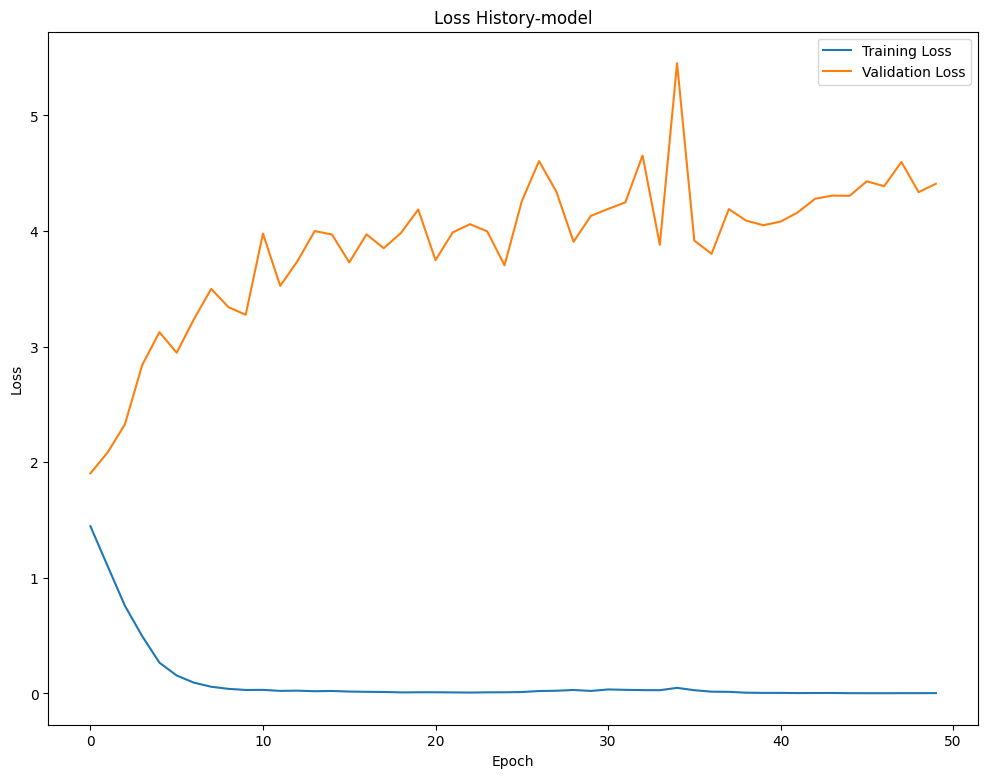

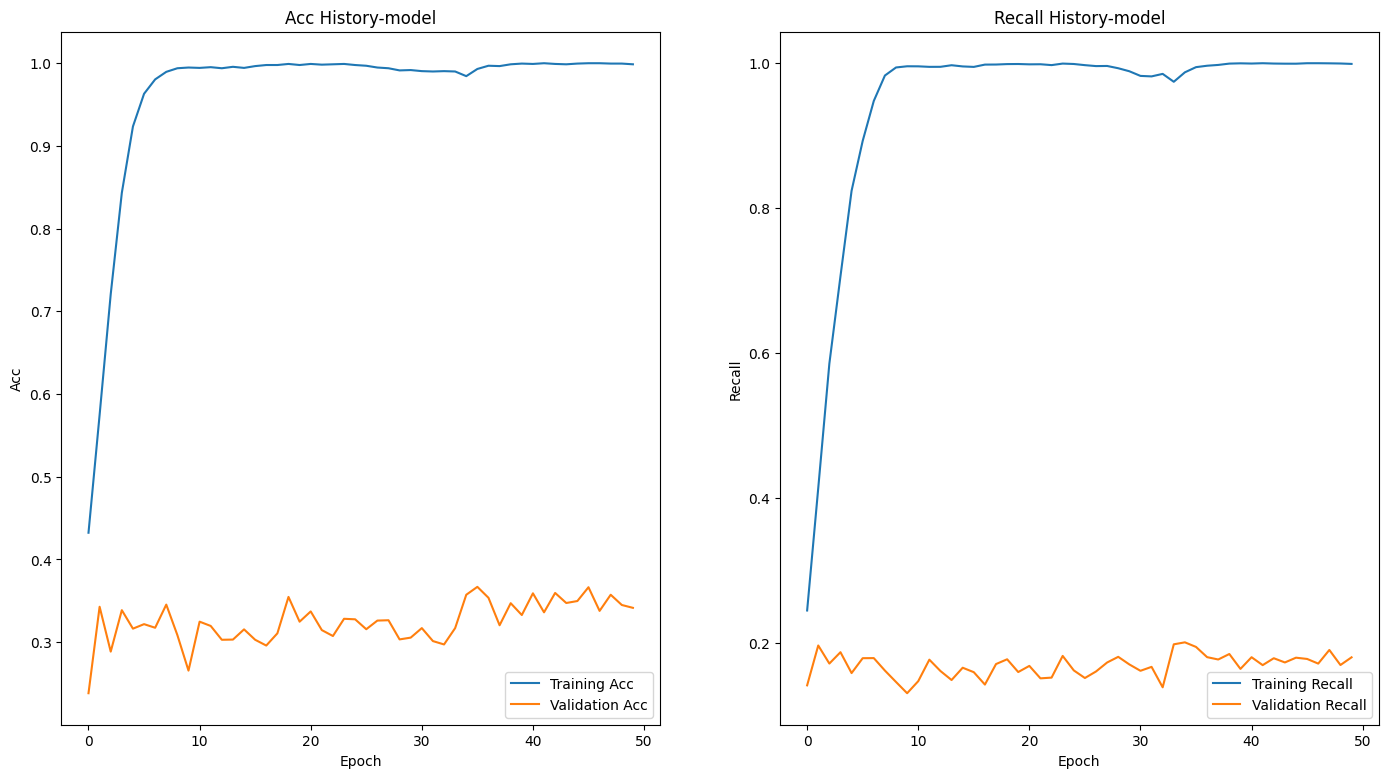

 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.001523709319360784 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r VAL ACC MAX:0.3668087121212121 VAL Recall MAX:0.20032970527530014 VAL Loss MIN:1.903796438852946 
 


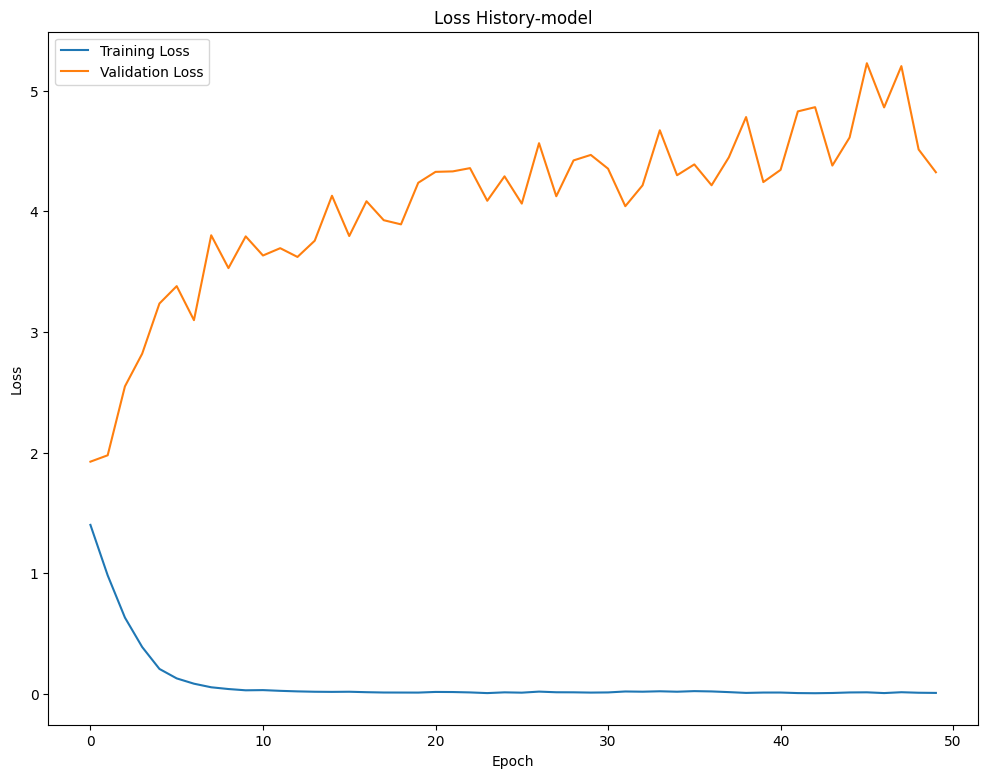

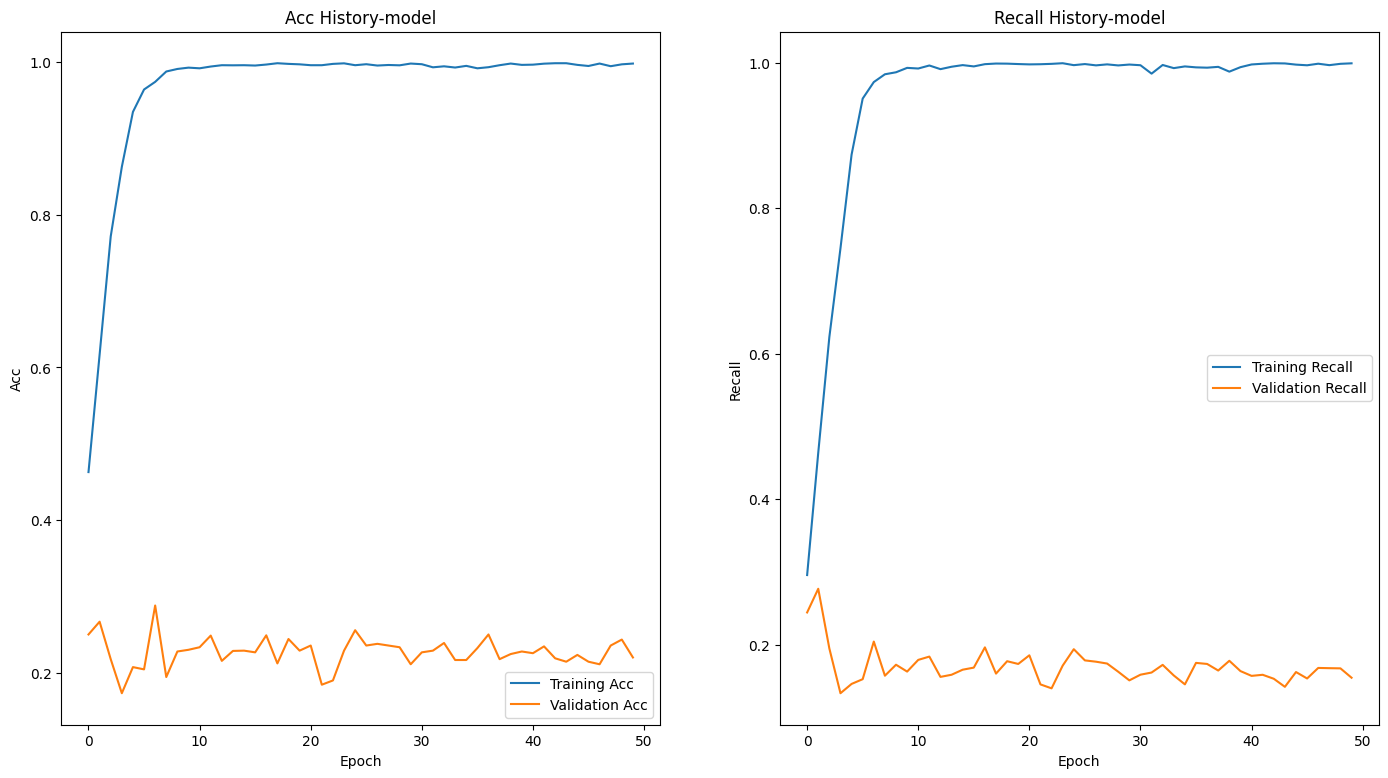

 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side Train ACC MAX:0.9986979166666666 Train Recall MAX:0.9990693223358219 Train Loss MIN:0.005561340128032255 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side VAL ACC MAX:0.28794642857142855 VAL Recall MAX:0.27719376593658207 VAL Loss MIN:1.9249997212336614 
 


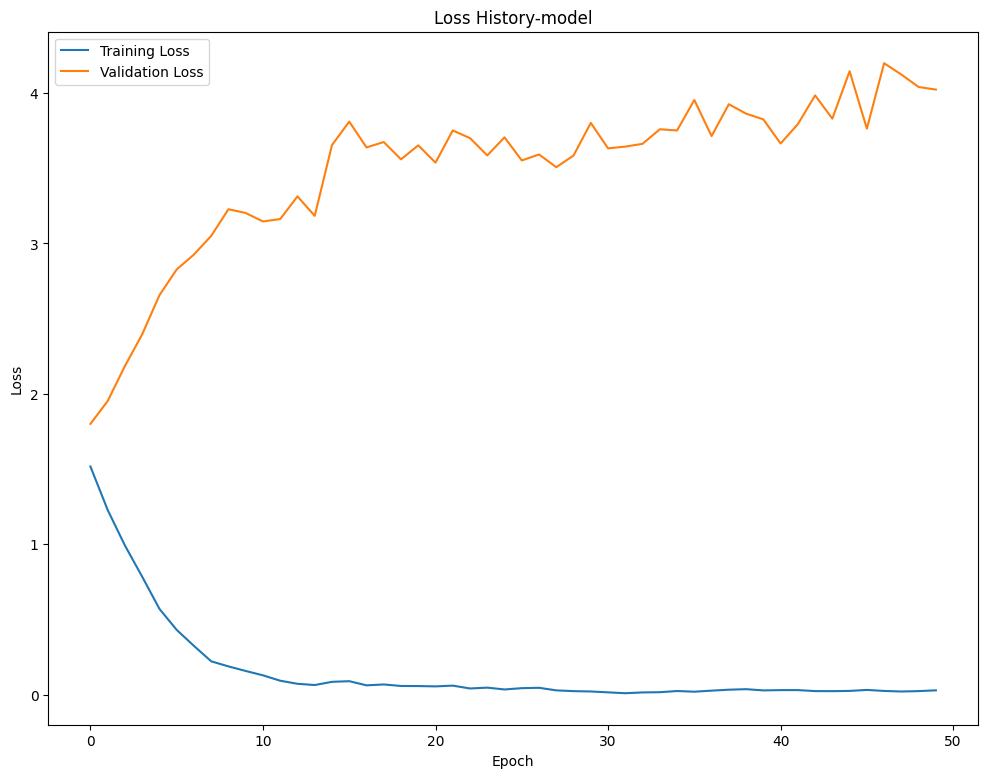

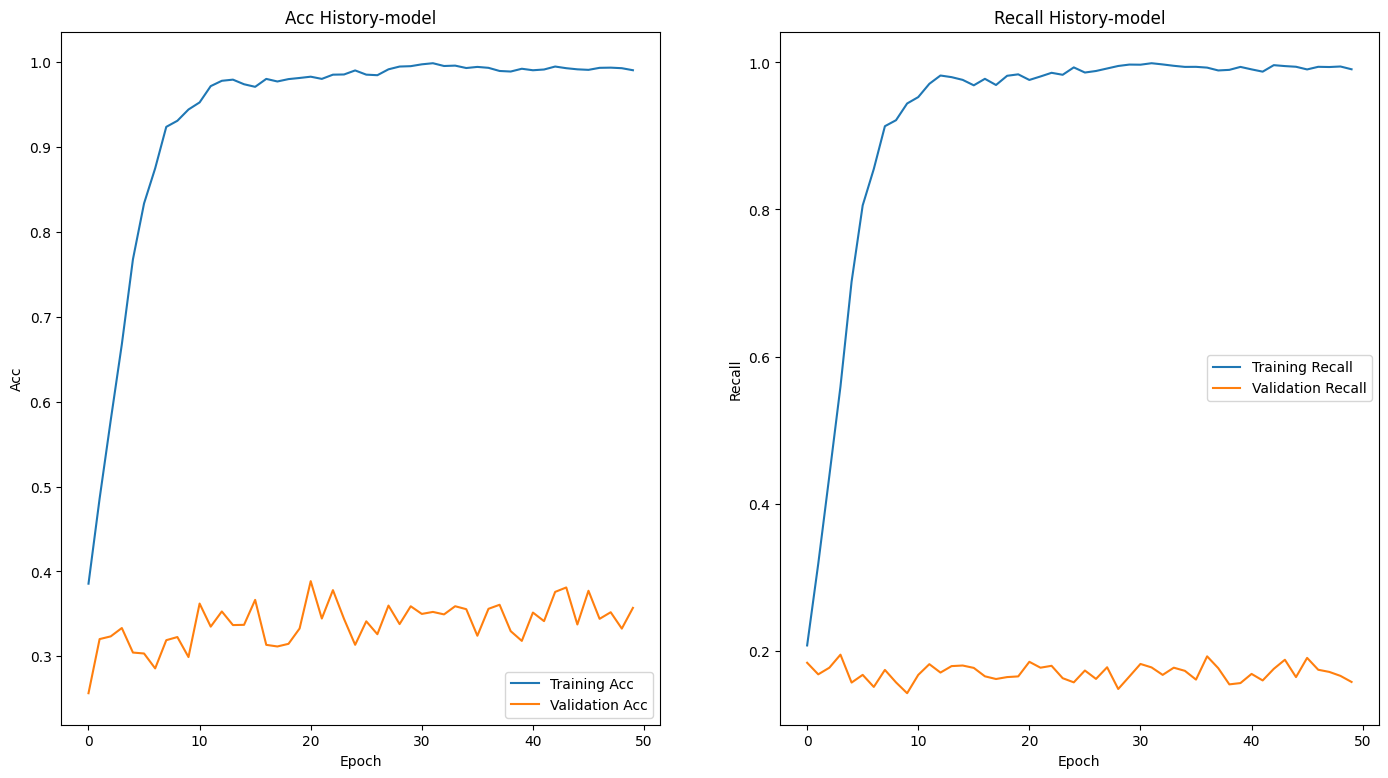

 MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r Train ACC MAX:0.9984809027777778 Train Recall MAX:0.9988728484479178 Train Loss MIN:0.00854318798611942 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r VAL ACC MAX:0.38859097633136097 VAL Recall MAX:0.1945672744151963 VAL Loss MIN:1.799973240735131 
 


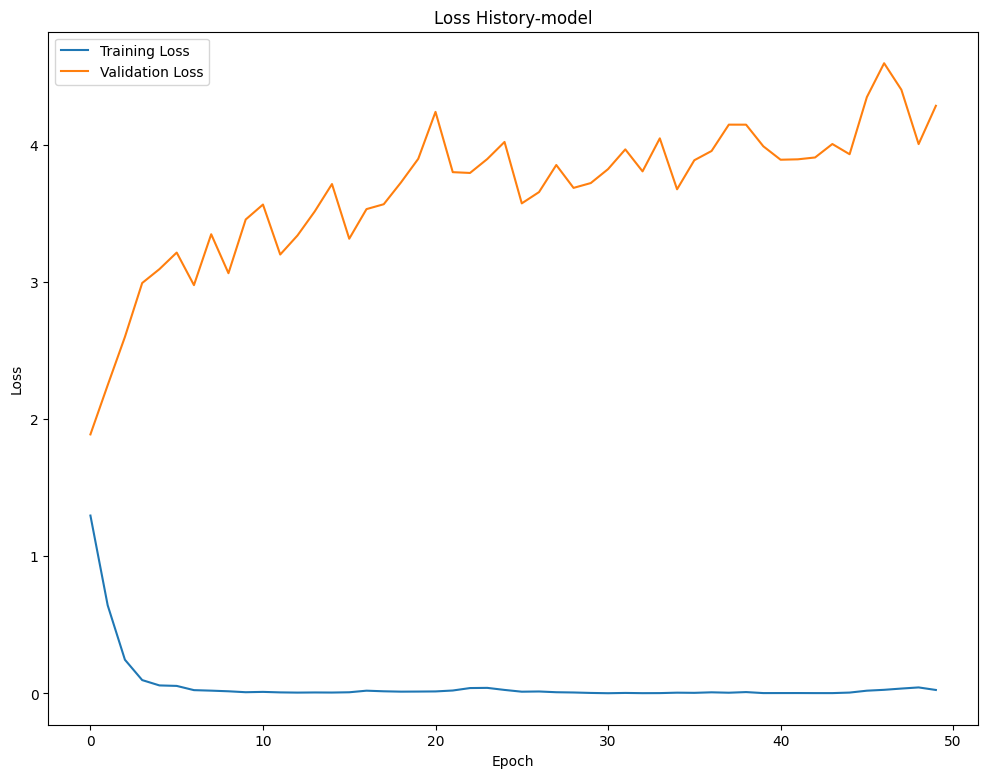

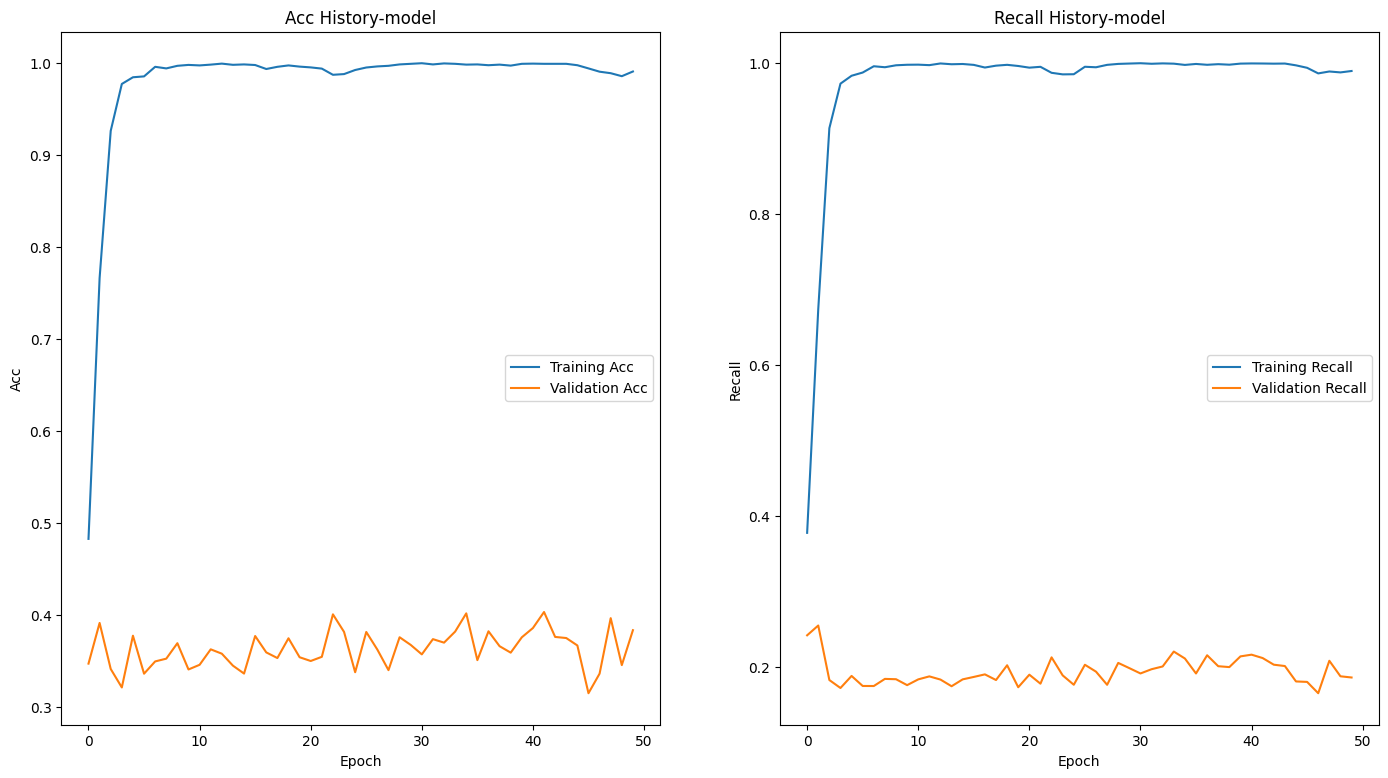

 MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-max_side Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.0016208955489854441 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-max_side VAL ACC MAX:0.40304487179487175 VAL Recall MAX:0.25534684149948206 VAL Loss MIN:1.888585079717272 
 


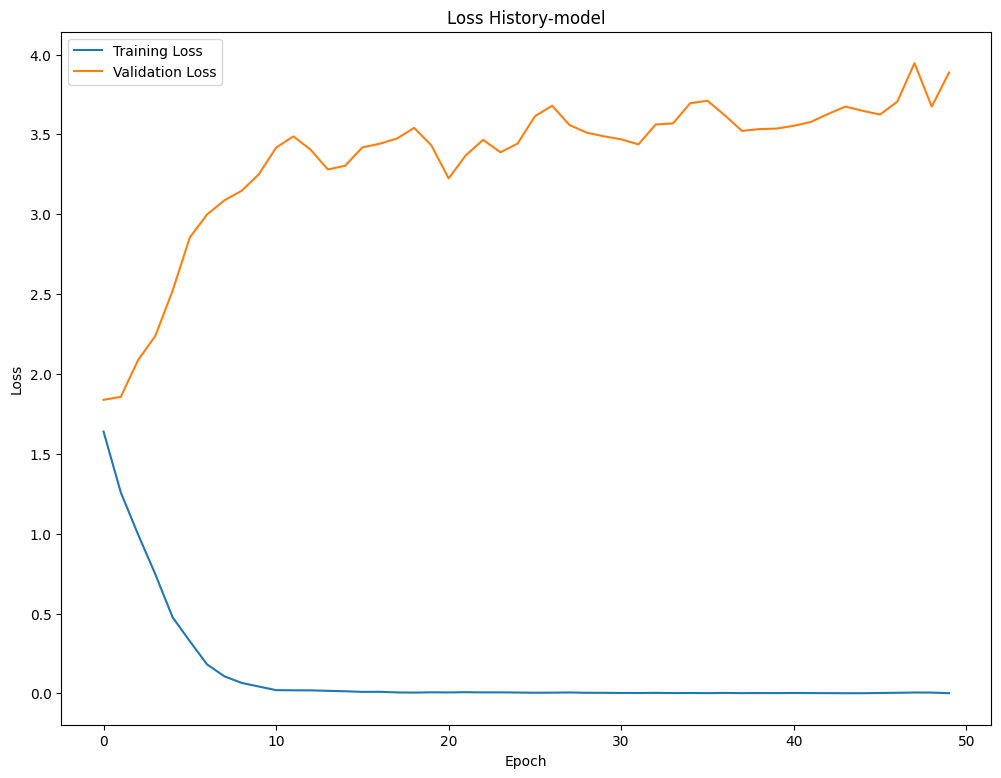

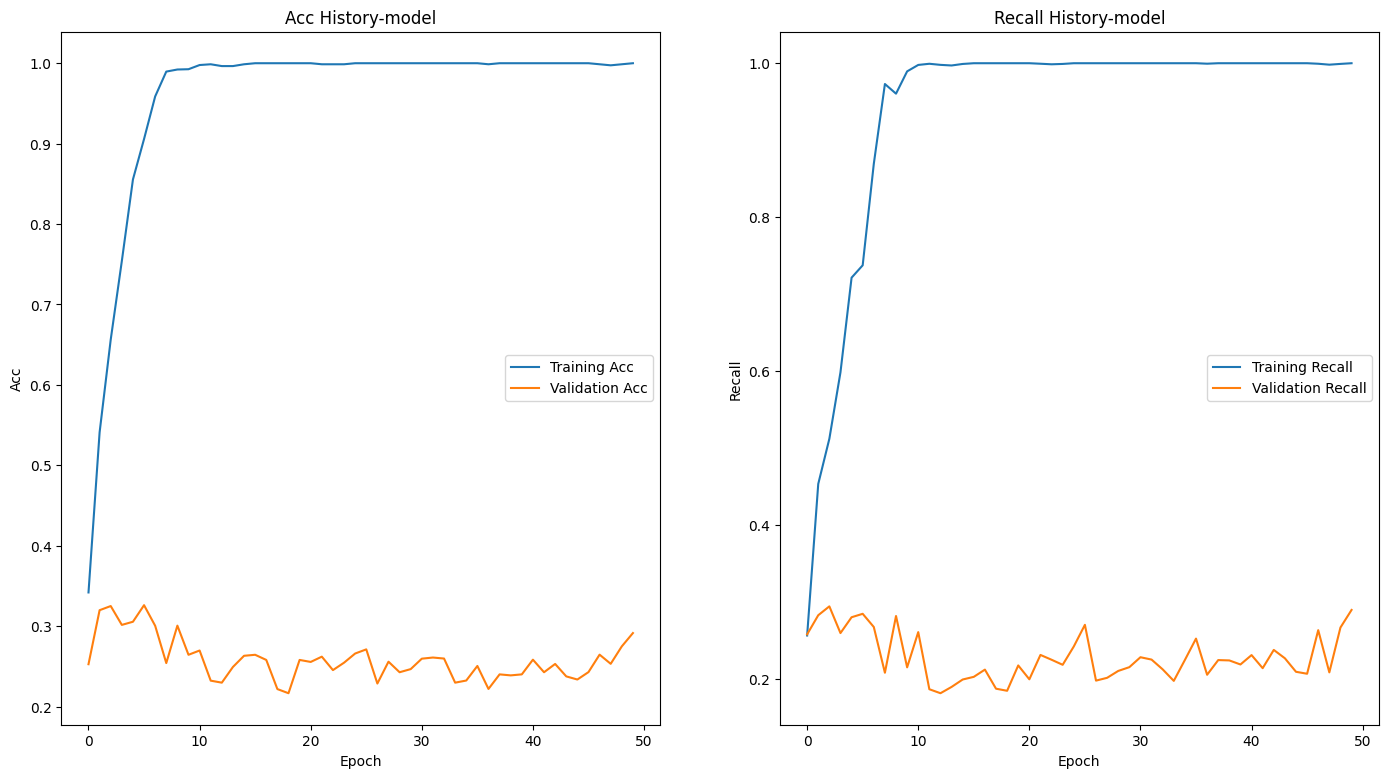

 MODEL: Resnet50_50_bs128_all_classes-mask_true-no_flip-one_sied_r Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.0009773760942379613 
        MODEL: Resnet50_50_bs128_all_classes-mask_true-no_flip-one_sied_r VAL ACC MAX:0.32603092783505155 VAL Recall MAX:0.29389064021139494 VAL Loss MIN:1.8380719561047023 
 


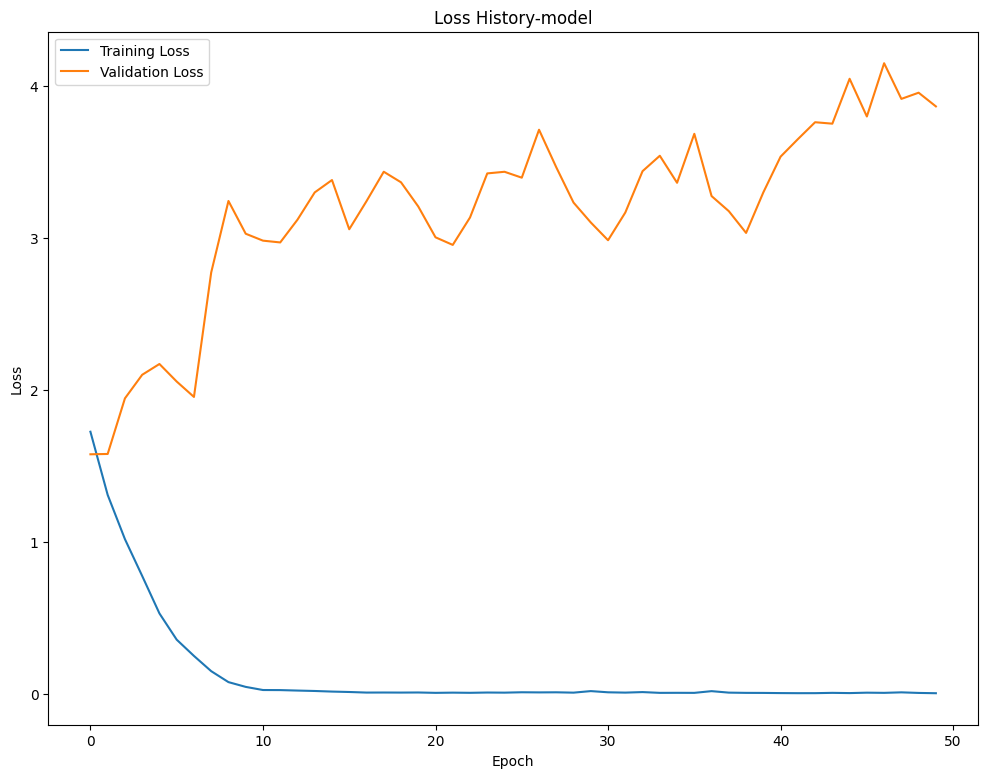

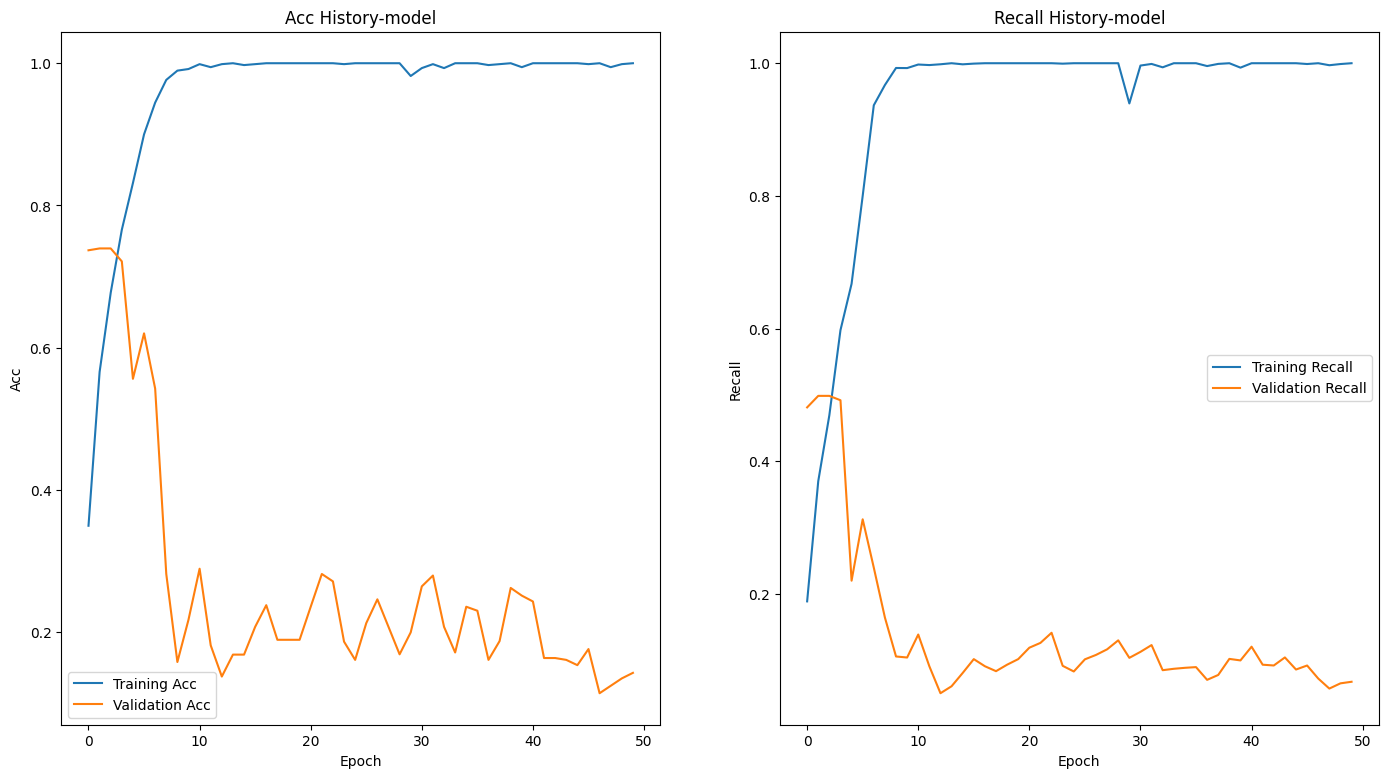

 MODEL: Resnet50_50_bs128_all_classes-mask_true-no_flip-max_side Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.0018907324647280707 
        MODEL: Resnet50_50_bs128_all_classes-mask_true-no_flip-max_side VAL ACC MAX:0.7395833333333334 VAL Recall MAX:0.4986559139784947 VAL Loss MIN:1.5756582179034067 
 


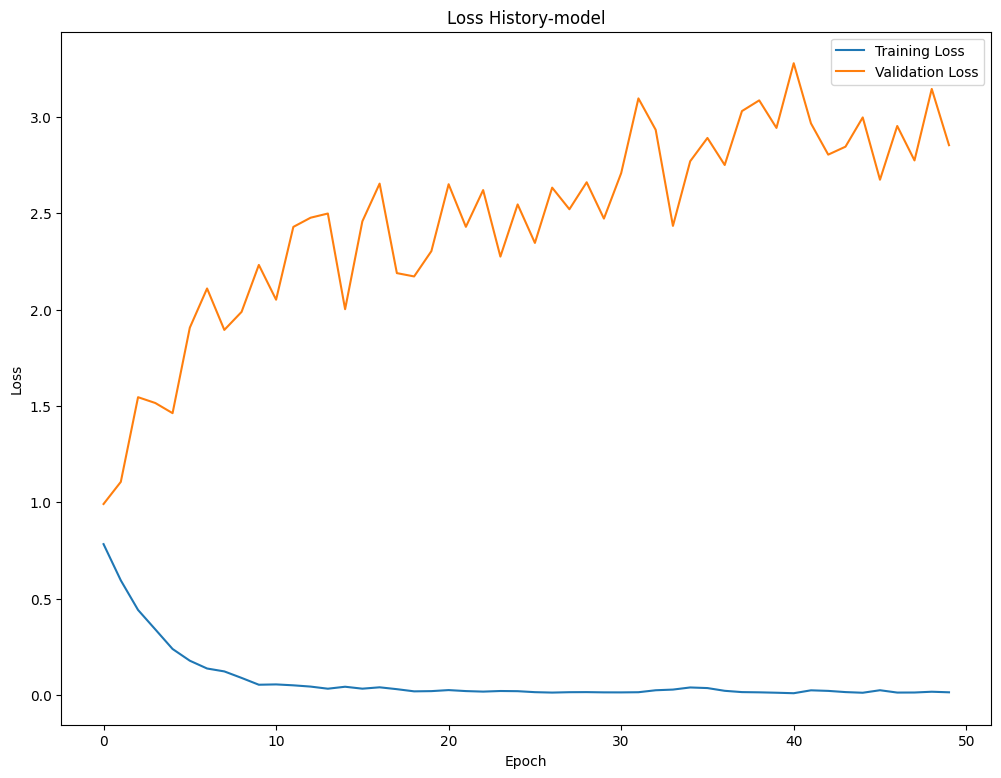

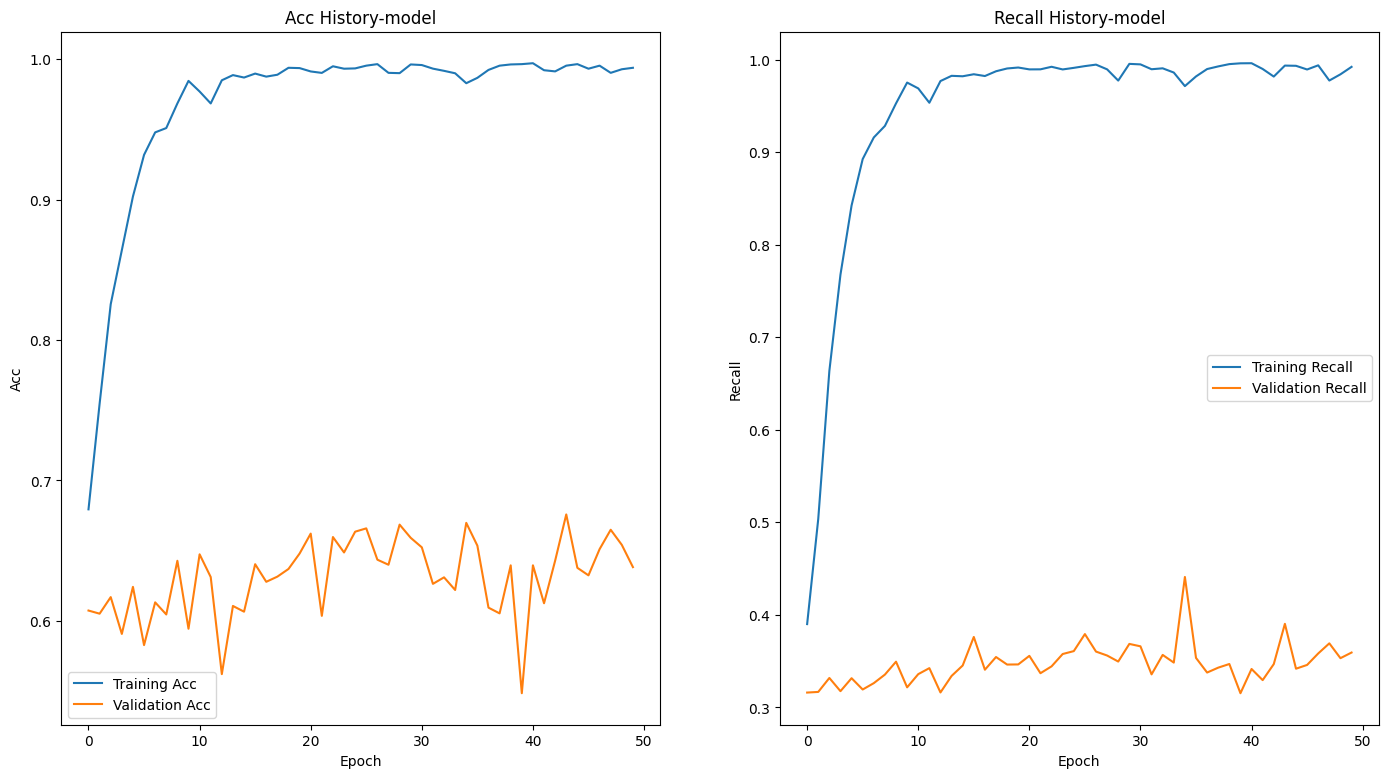

 MODEL: Resnet50_50_bs128_group_classes-mask_false-invert-one_sied_r Train ACC MAX:0.9971788194444444 Train Recall MAX:0.996163160629176 Train Loss MIN:0.008755191450395139 
        MODEL: Resnet50_50_bs128_group_classes-mask_false-invert-one_sied_r VAL ACC MAX:0.6757581360946746 VAL Recall MAX:0.4409576077783272 VAL Loss MIN:0.9911103973896825 
 


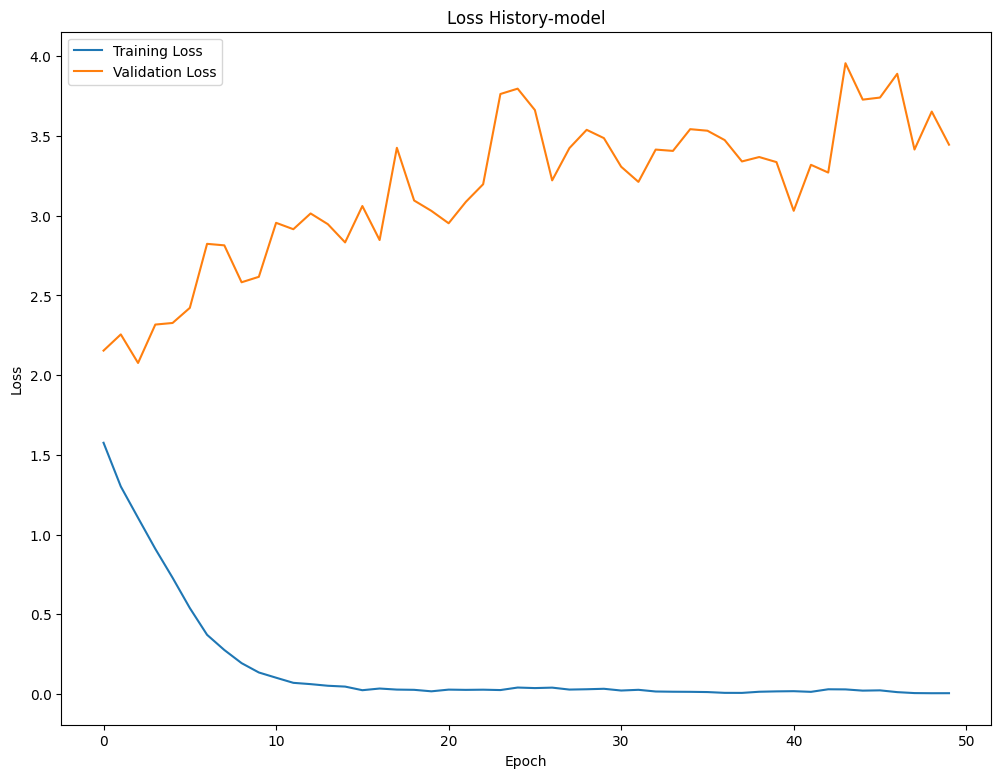

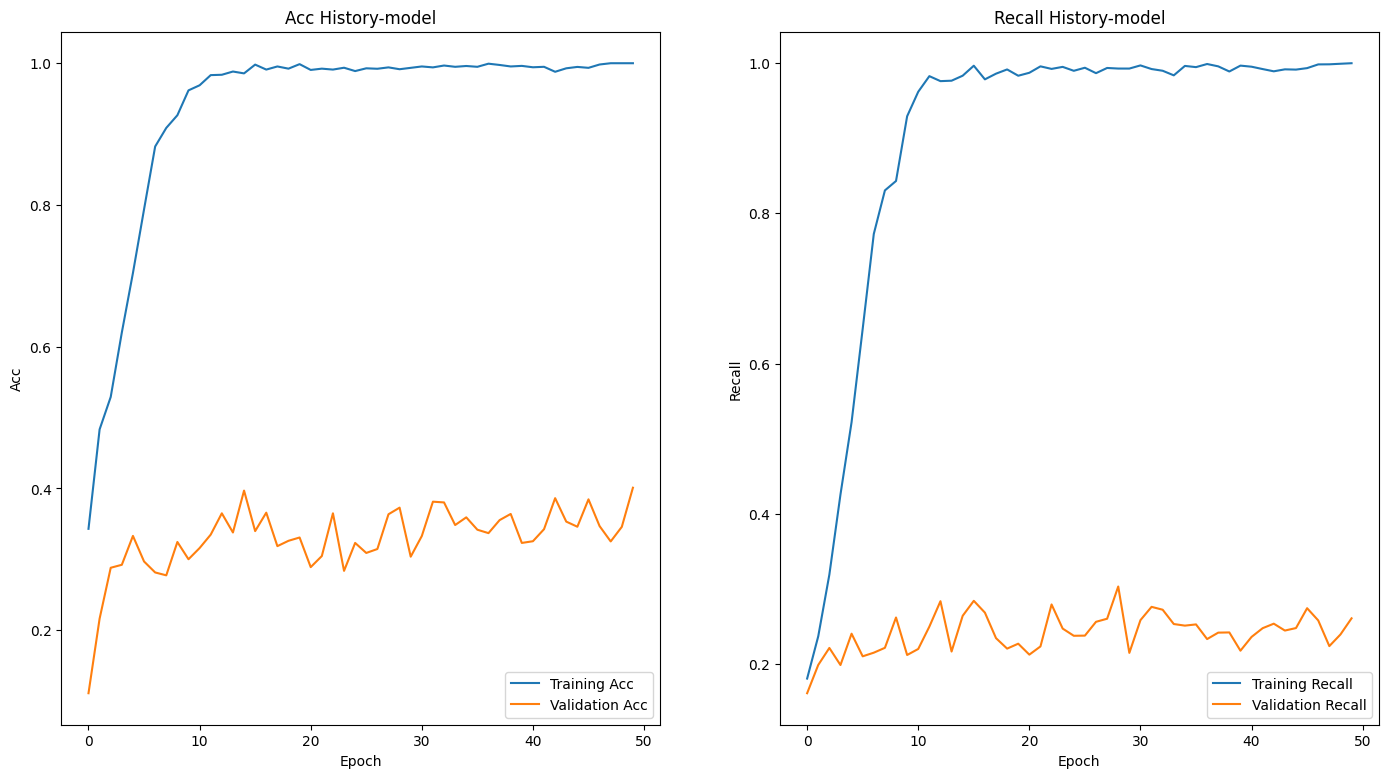

 MODEL: Resnet50_50_bs128_all_classes-mask_true-invert-one_sied_r Train ACC MAX:0.9993489583333334 Train Recall MAX:0.9997165532879819 Train Loss MIN:0.0045569814354421544 
        MODEL: Resnet50_50_bs128_all_classes-mask_true-invert-one_sied_r VAL ACC MAX:0.40099158653846156 VAL Recall MAX:0.30339339939376647 VAL Loss MIN:2.076373360572605 
 


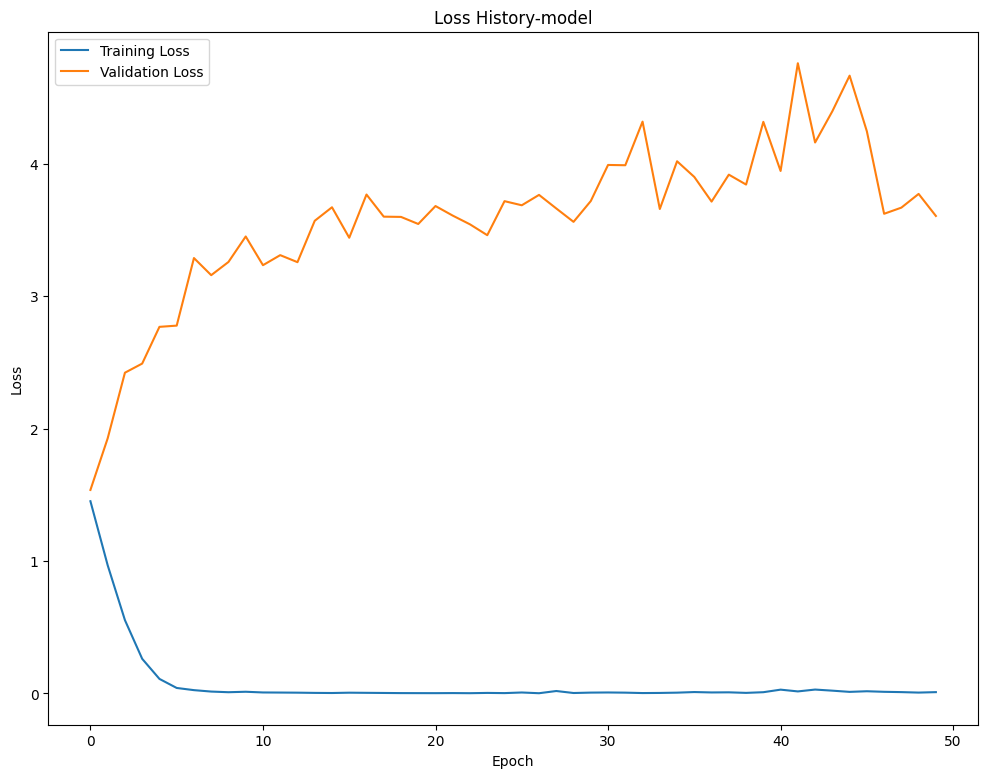

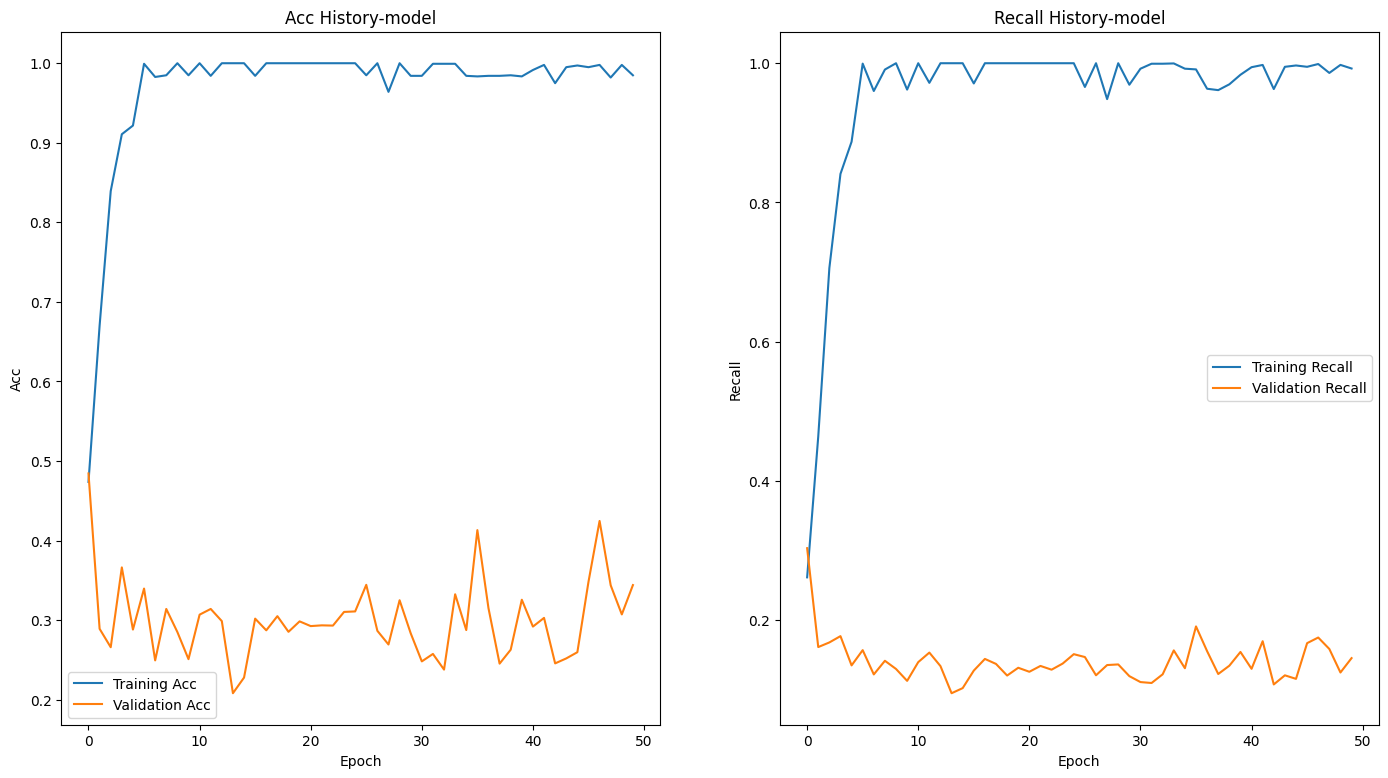

 MODEL: Resnet50_50_bs128_all_classes-mask_true-invert-max_side Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.0015405444269000464 
        MODEL: Resnet50_50_bs128_all_classes-mask_true-invert-max_side VAL ACC MAX:0.484375 VAL Recall MAX:0.3035013006317354 VAL Loss MIN:1.537093913232958 
 


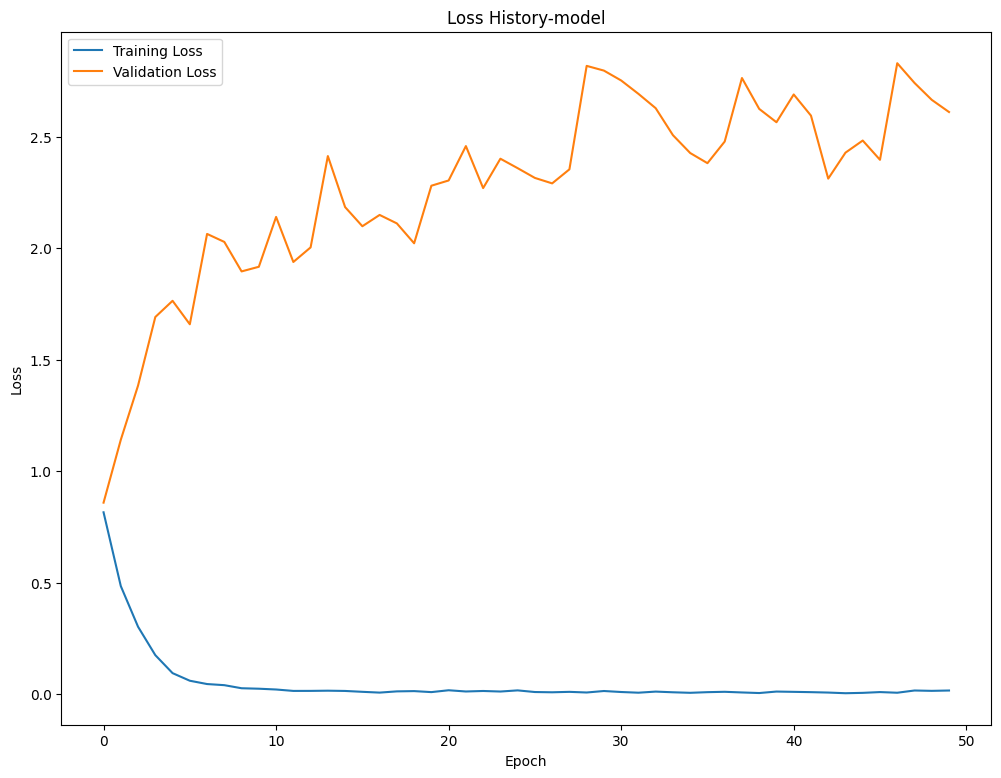

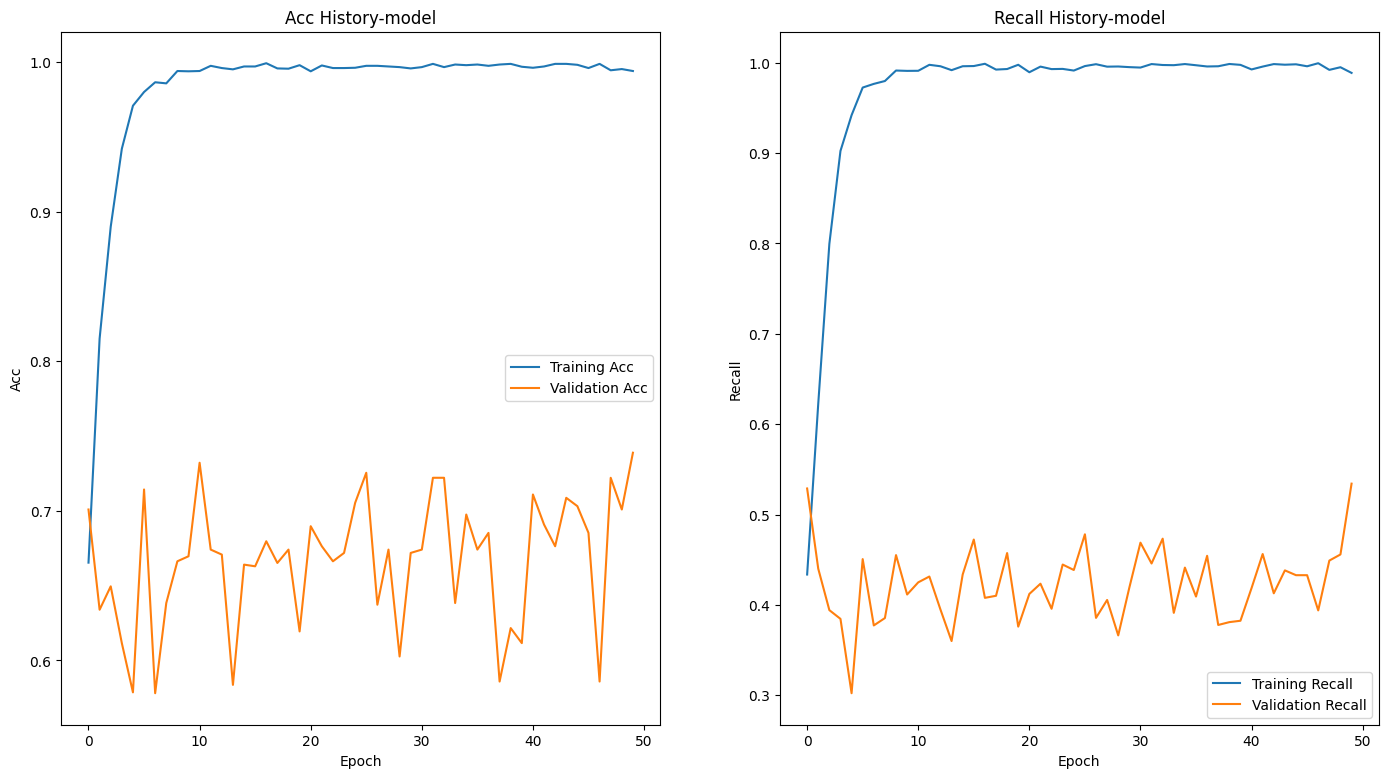

 MODEL: Resnet50_50_bs128_group_classes-mask_false-no_flip-one_sied_r Train ACC MAX:0.9991319444444444 Train Recall MAX:0.9993906573570107 Train Loss MIN:0.004357076736236974 
        MODEL: Resnet50_50_bs128_group_classes-mask_false-no_flip-one_sied_r VAL ACC MAX:0.7388392857142857 VAL Recall MAX:0.5342203347978572 VAL Loss MIN:0.8590007913991184 
 


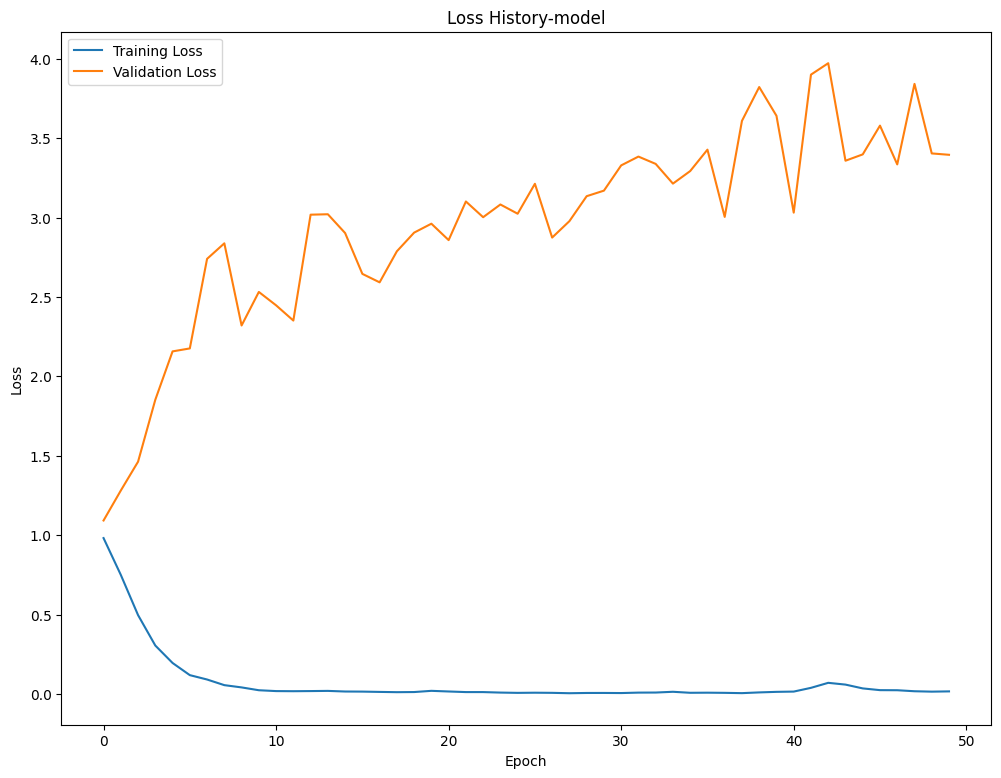

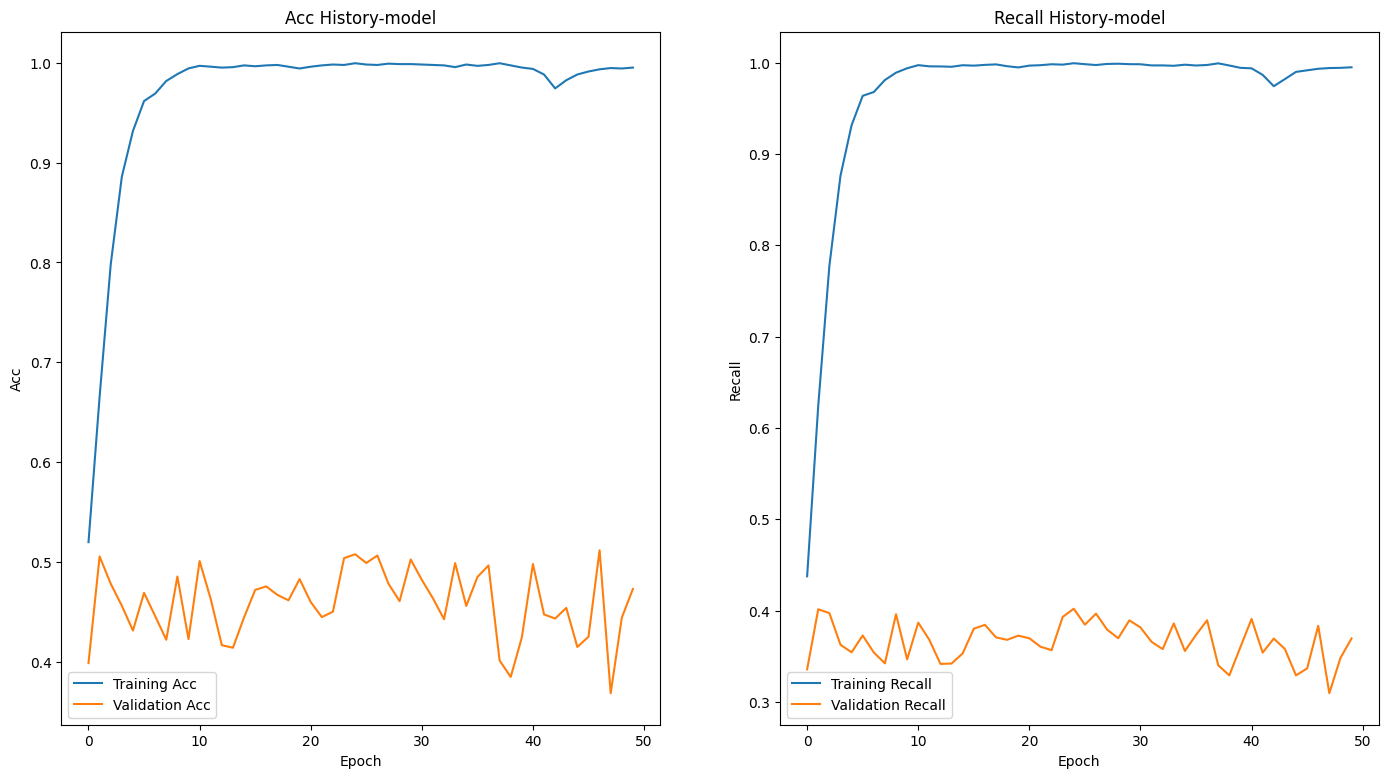

 MODEL: Resnet50_50_bs128_group_classes-mask_false-no_flip-max_side Train ACC MAX:0.9995659722222222 Train Recall MAX:0.9994708994708995 Train Loss MIN:0.004958163882777718 
        MODEL: Resnet50_50_bs128_group_classes-mask_false-no_flip-max_side VAL ACC MAX:0.5115840517241379 VAL Recall MAX:0.40203516151931096 VAL Loss MIN:1.0924001837533617 
 


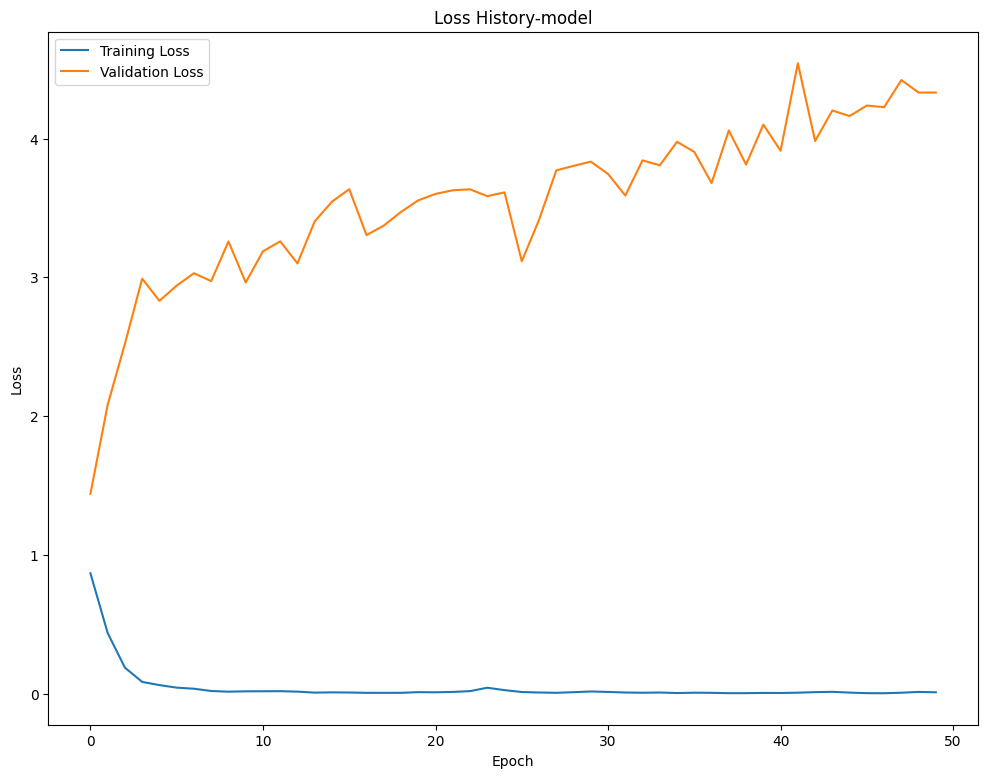

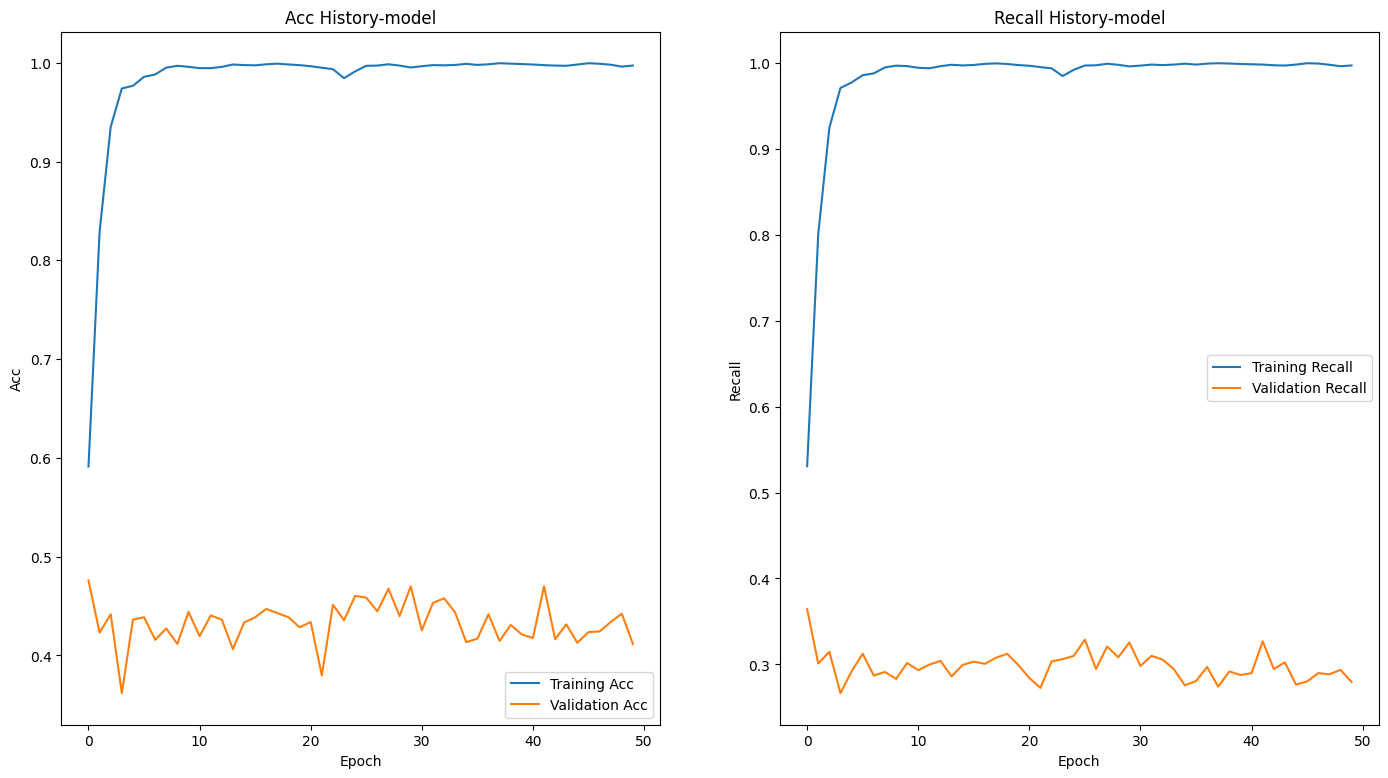

 MODEL: Resnet50_50_bs128_group_classes-mask_false-invert-max_side Train ACC MAX:0.9995659722222222 Train Recall MAX:0.999477173390217 Train Loss MIN:0.0025763897870148423 
        MODEL: Resnet50_50_bs128_group_classes-mask_false-invert-max_side VAL ACC MAX:0.47596153846153844 VAL Recall MAX:0.3642012992170241 VAL Loss MIN:1.4397883218588288 
 


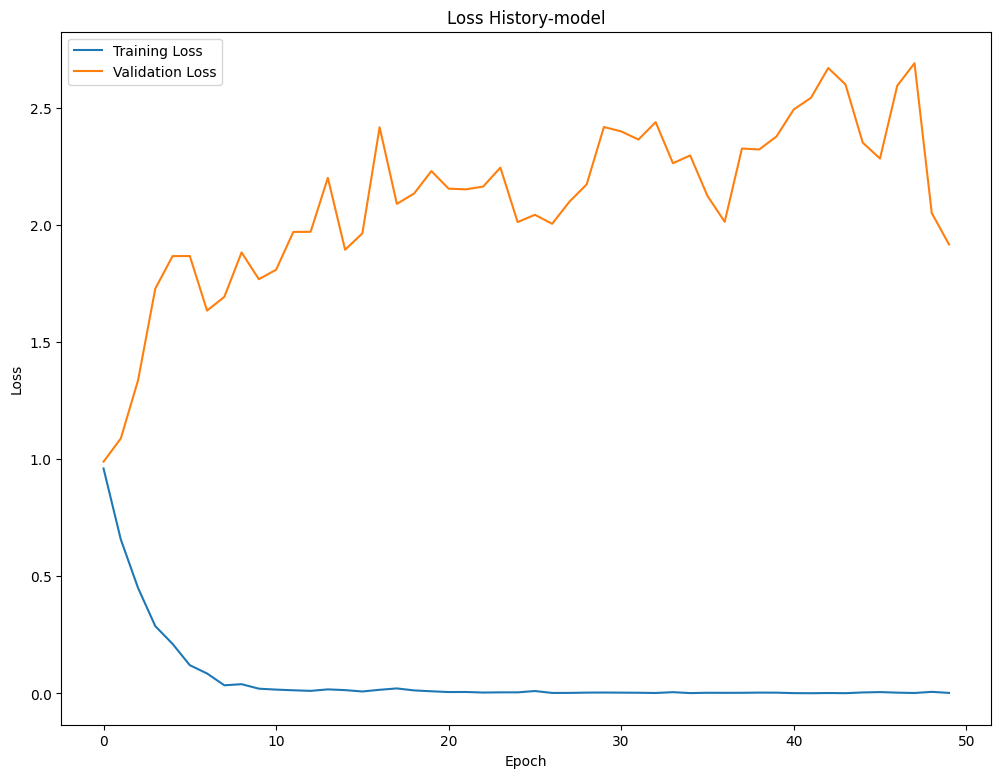

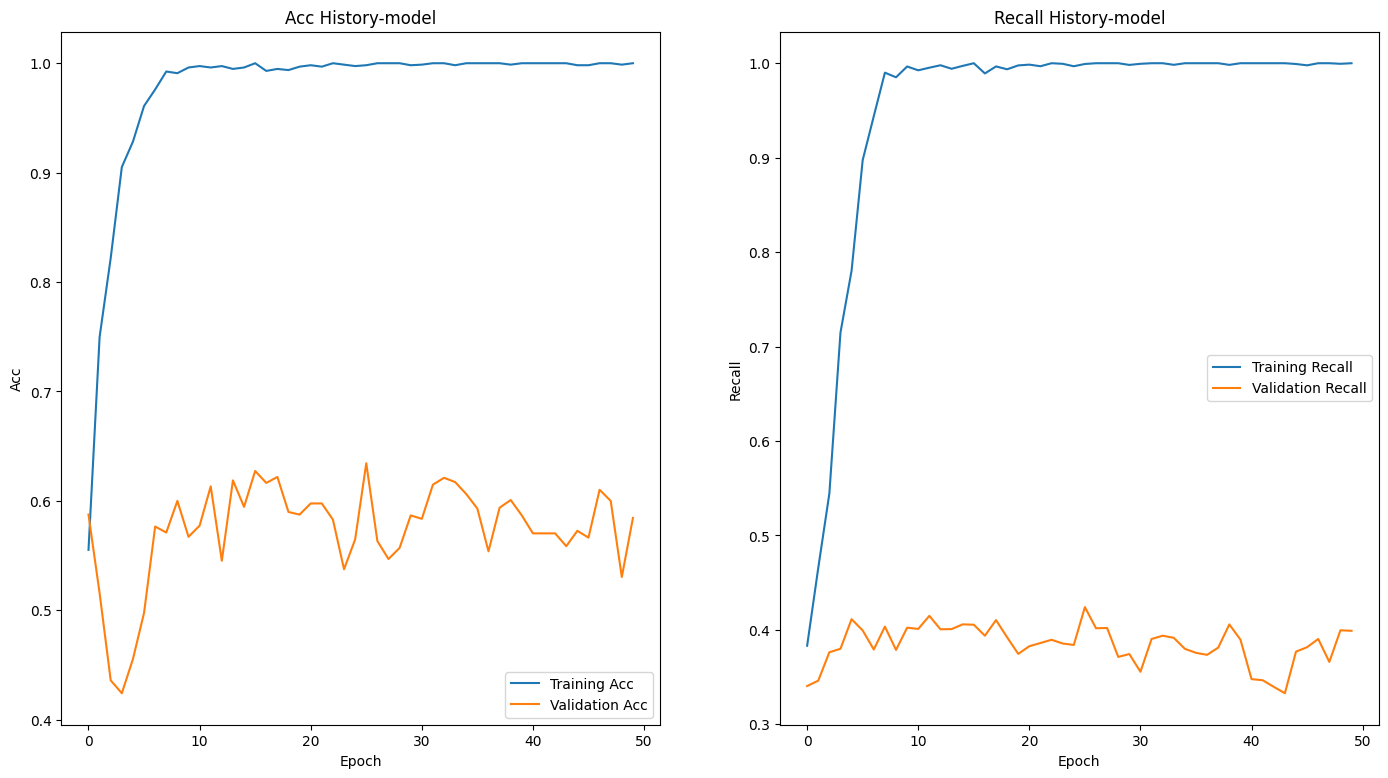

 MODEL: Resnet50_50_bs128_group_classes-mask_true-no_flip-one_sied_r Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.0008901843596339002 
        MODEL: Resnet50_50_bs128_group_classes-mask_true-no_flip-one_sied_r VAL ACC MAX:0.634375 VAL Recall MAX:0.42404904904904905 VAL Loss MIN:0.9893692777707026 
 


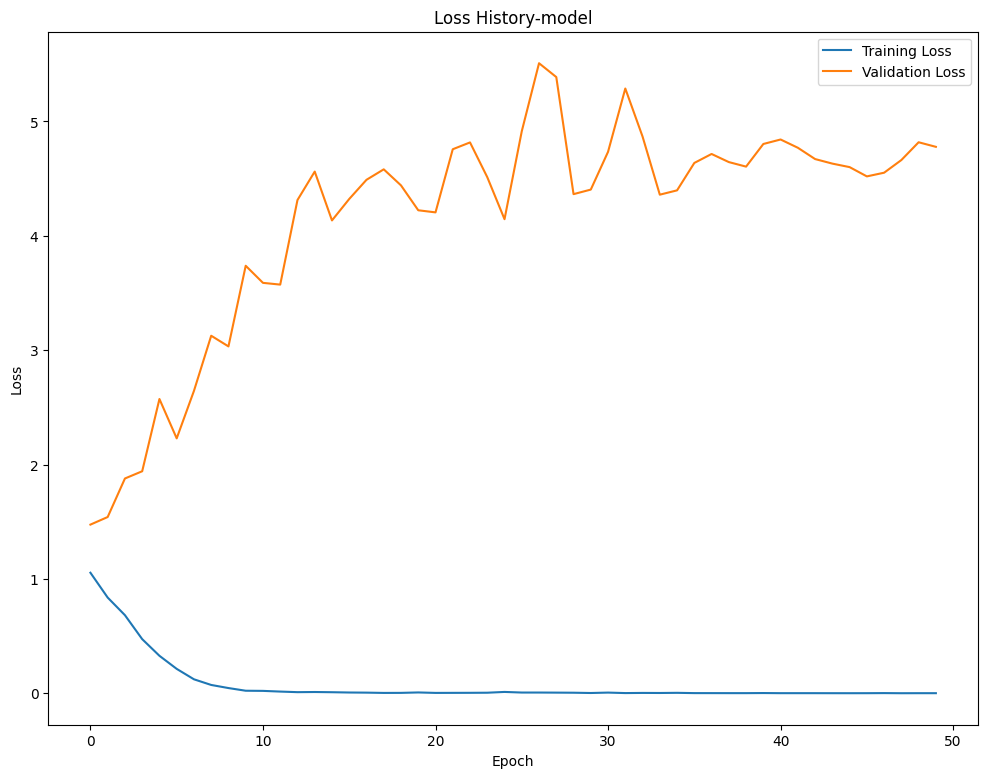

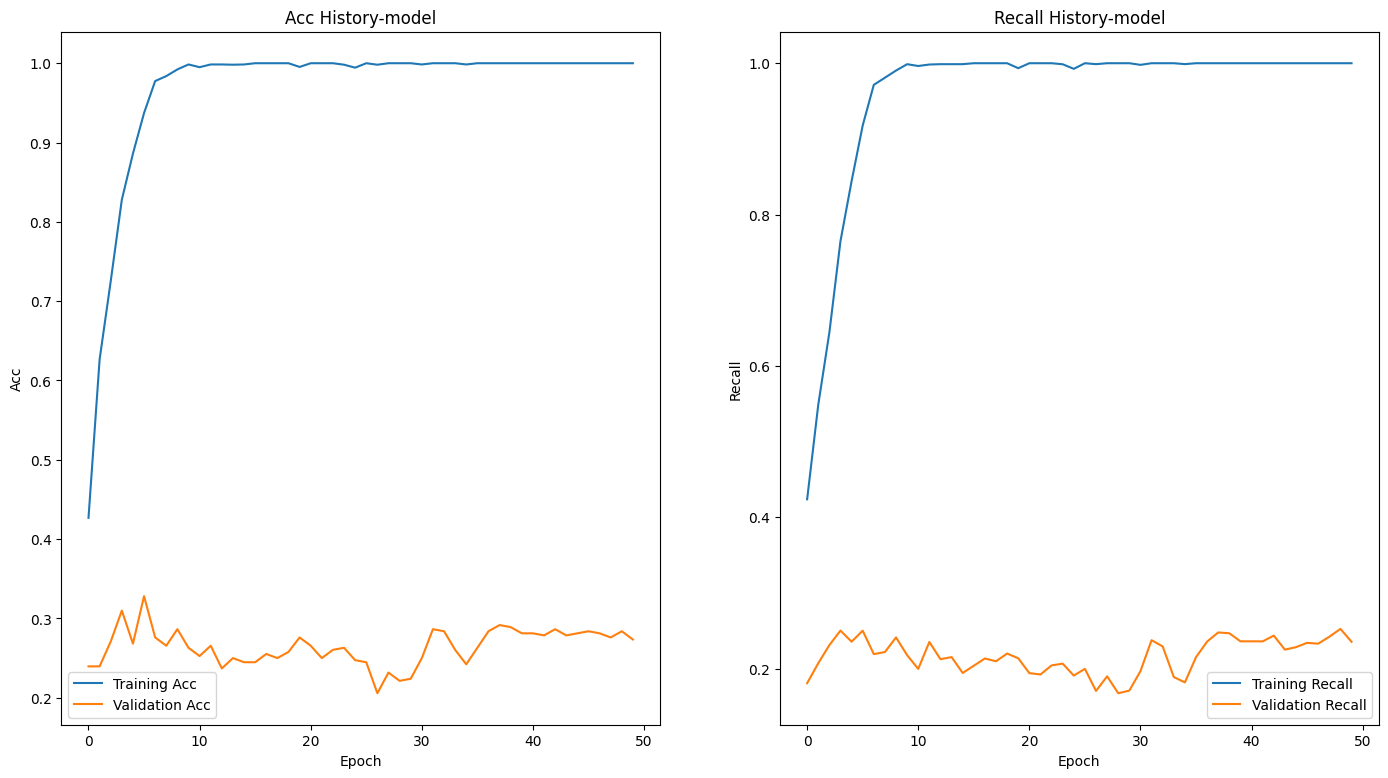

 MODEL: Resnet50_50_bs128_group_classes-mask_true-no_flip-max_side Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.00042798060714869016 
        MODEL: Resnet50_50_bs128_group_classes-mask_true-no_flip-max_side VAL ACC MAX:0.328125 VAL Recall MAX:0.25252791195640206 VAL Loss MIN:1.4746303796768188 
 


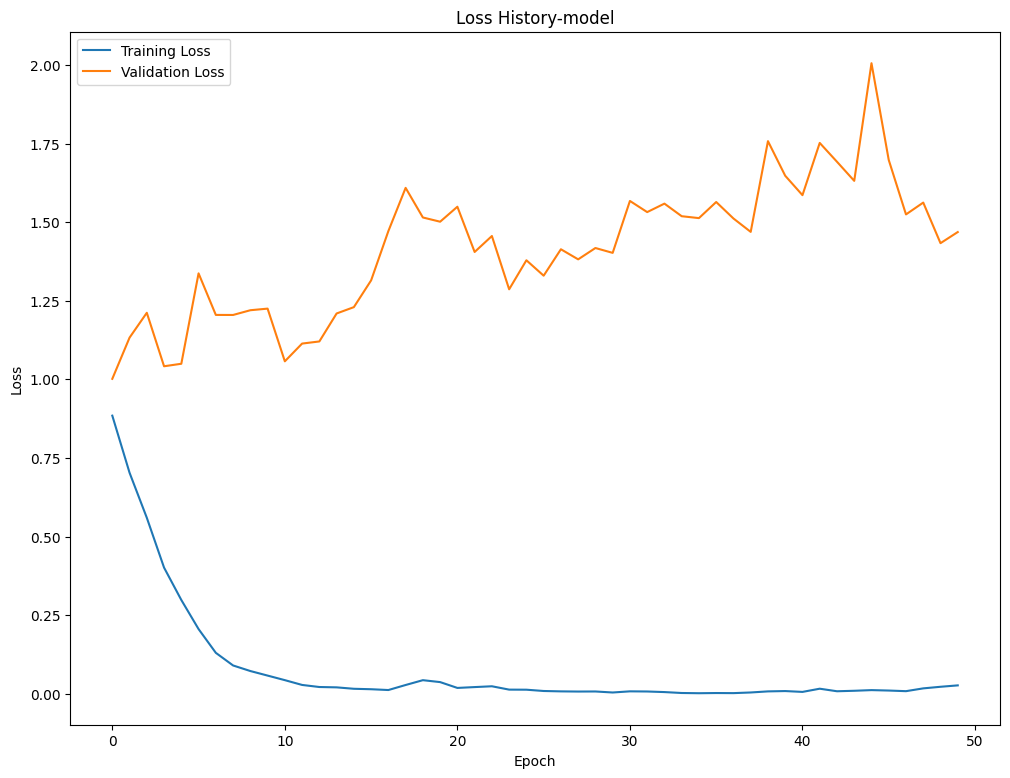

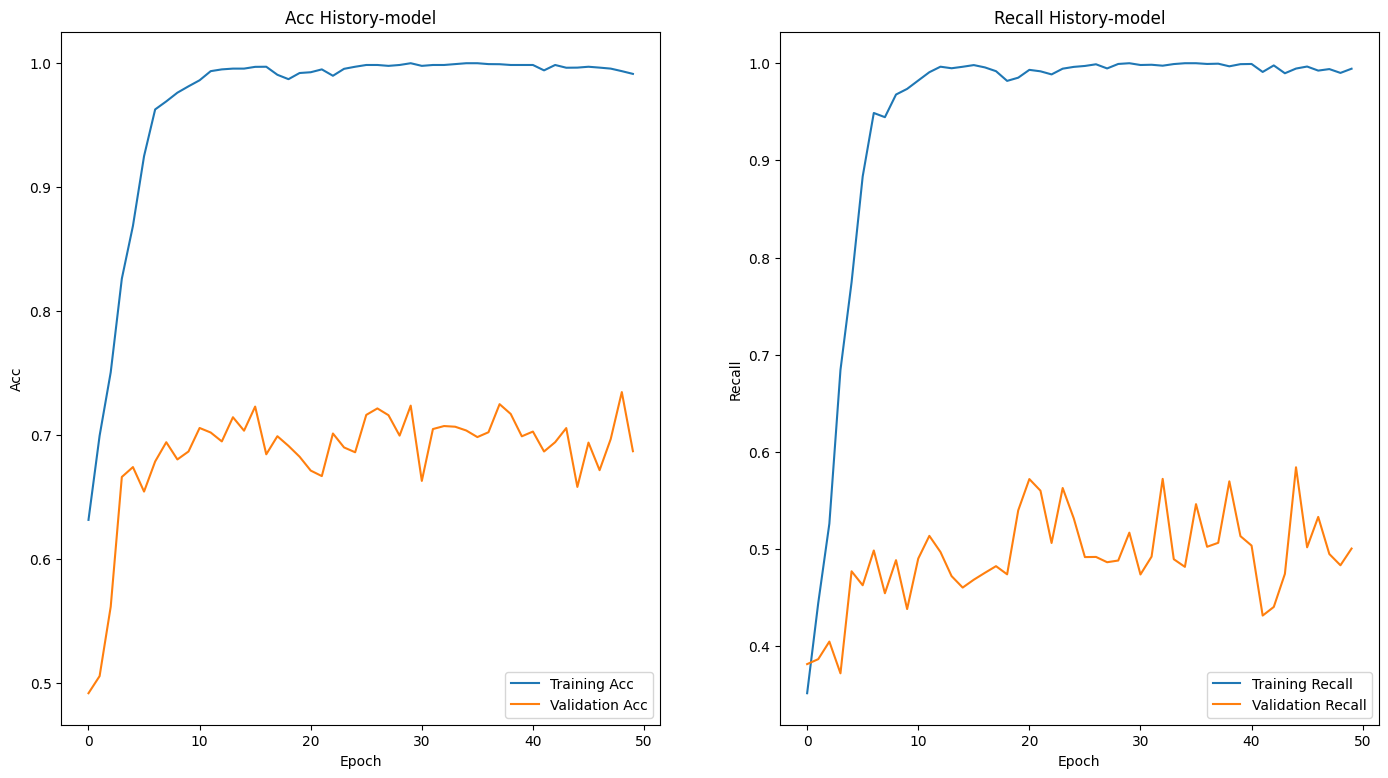

 MODEL: Resnet50_50_bs128_group_classes-mask_true-invert-one_sied_r Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.0015081194624601405 
        MODEL: Resnet50_50_bs128_group_classes-mask_true-invert-one_sied_r VAL ACC MAX:0.734609375 VAL Recall MAX:0.5841024261707014 VAL Loss MIN:1.0016974304333206 
 


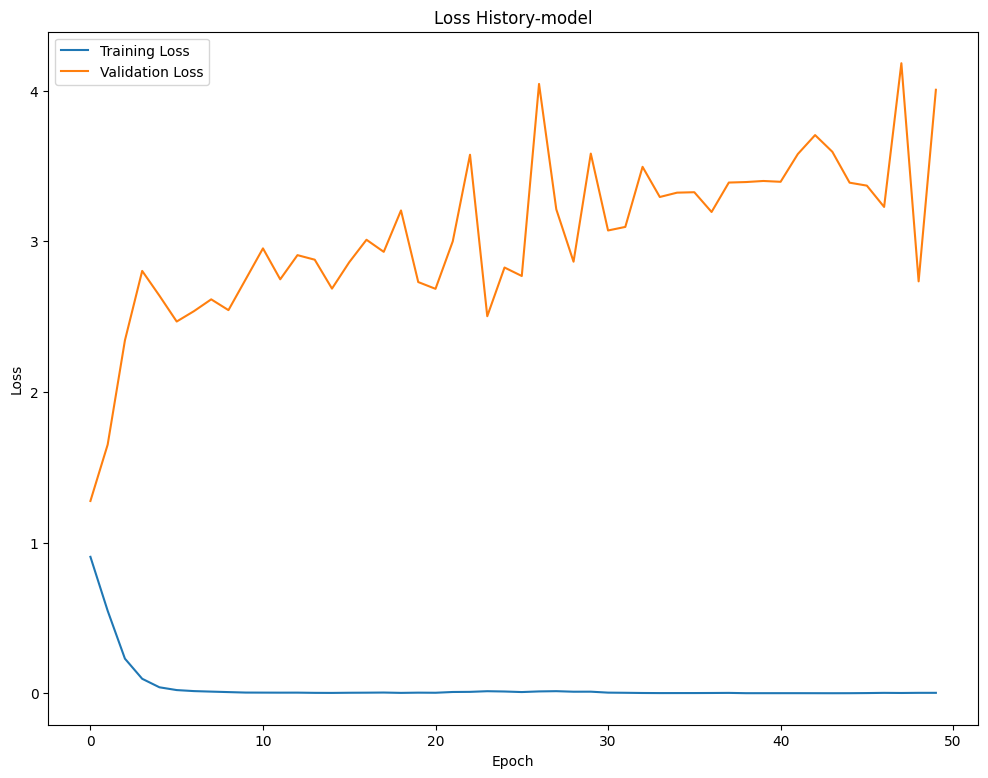

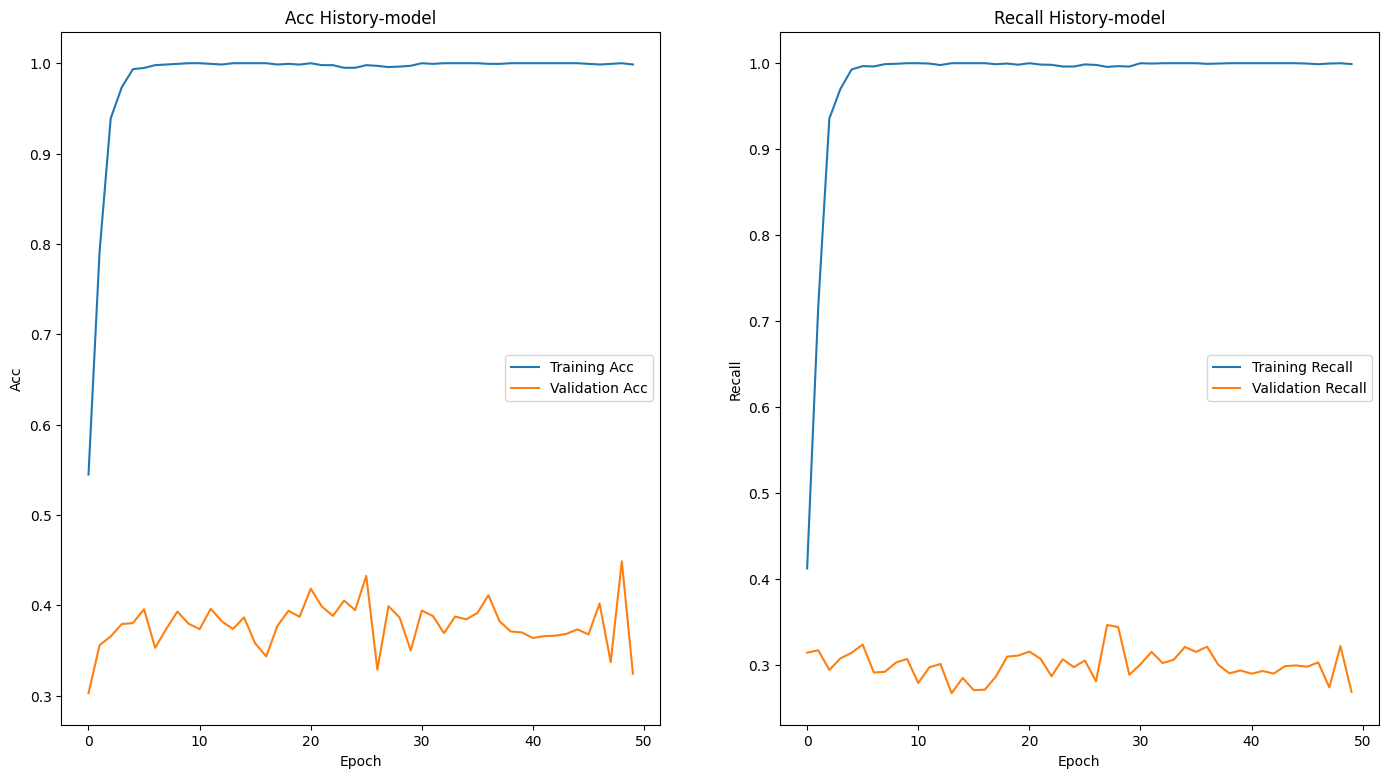

 MODEL: Resnet50_50_bs128_group_classes-mask_true-invert-max_side Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.00028430611669978494 
        MODEL: Resnet50_50_bs128_group_classes-mask_true-invert-max_side VAL ACC MAX:0.44875 VAL Recall MAX:0.3465690320076285 VAL Loss MIN:1.276446296163827 
 


In [159]:
                 
for seg_model_name, history in history_all_data_type.items():
        # plt.figure(figsize=(12,9))

        # plt.plot(history[0]['Train Loss'], label=f'Training Loss')
        # plt.plot(history[0]['Valid Loss'], label=f'Validation Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.legend()
        # plt.title(f'Loss History-model')


        # plt.figure(figsize=(17,9))
        # plt.subplot(1, 2, 1)
        # plt.plot(history[0]['Train Acc'], label=f'Training Acc')
        # plt.plot(history[0]['Valid Acc'], label=f'Validation Acc')
        # plt.xlabel('Epoch')
        # plt.ylabel('Acc')
        # plt.legend()
        # plt.title(f'Acc History-model')

        # plt.subplot(1, 2, 2)
        # plt.plot(history[0]['Train Recall'], label=f'Training Recall')
        # plt.plot(history[0]['Valid Recall'], label=f'Validation Recall')
        # plt.xlabel('Epoch')
        # plt.ylabel('Recall')
        # plt.legend()
        # plt.title(f'Recall History-model')
        # plt.show()
        print(f""" MODEL: {seg_model_name} Train ACC MAX:{max(history[0]['Train Acc'])} Train Recall MAX:{max(history[0]['Train Recall'])} Train Loss MIN:{min(history[0]['Train Loss'])} 
        MODEL: {seg_model_name} VAL ACC MAX:{max(history[0]['Valid Acc'])} VAL Recall MAX:{max(history[0]['Valid Recall'])} VAL Loss MIN:{min(history[0]['Valid Loss'])} \n """)

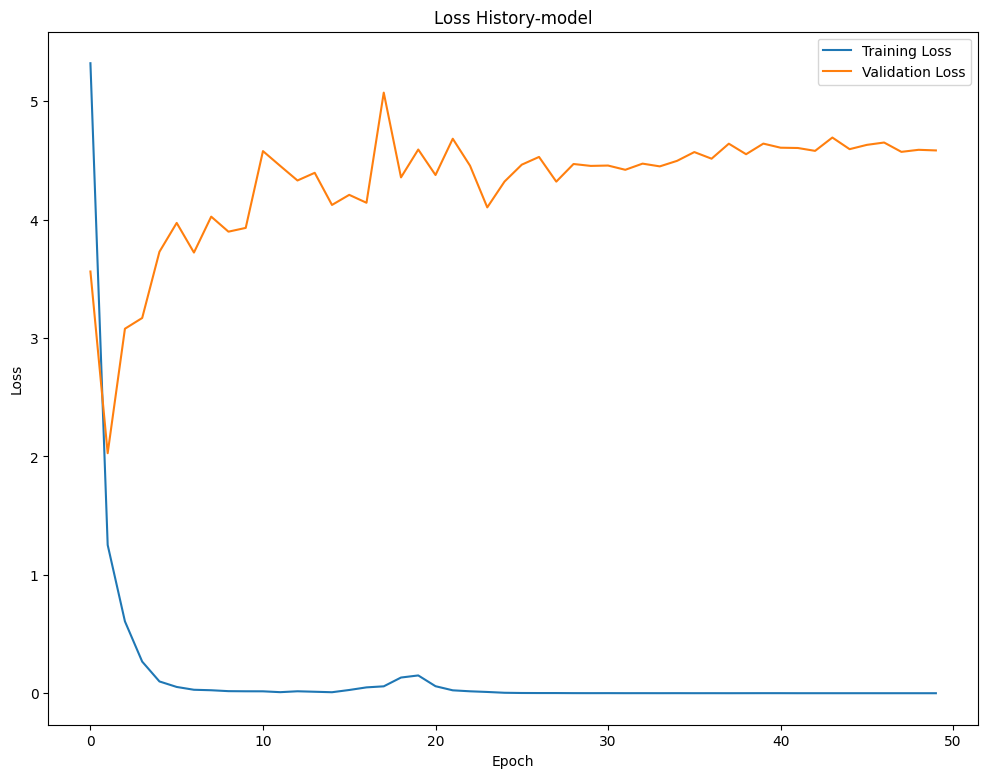

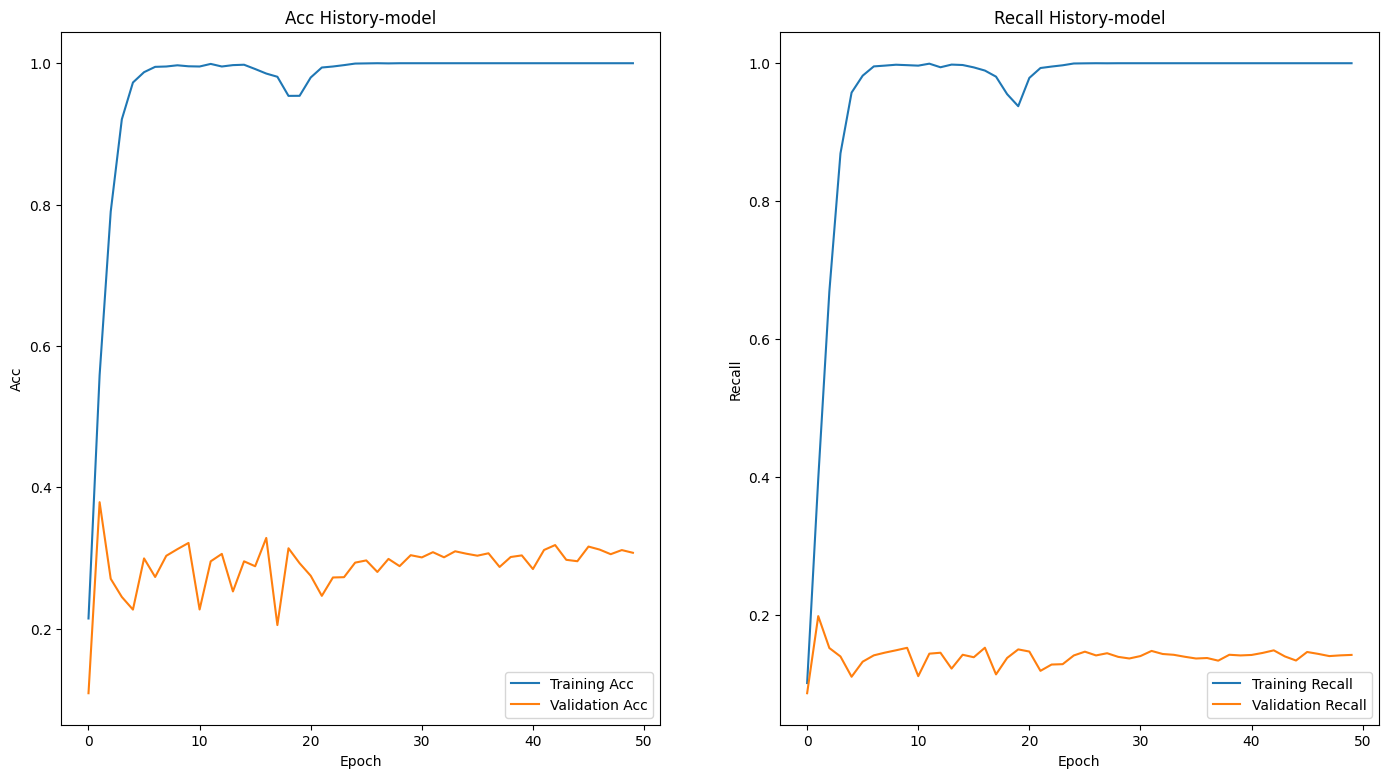

In [70]:
plt.figure(figsize=(12,9))
"без атеншена резнет 50 слабая аугментация"
plt.plot(history['Train Loss'], label=f'Training Loss')
plt.plot(history['Valid Loss'], label=f'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss History-model')


plt.figure(figsize=(17,9))
plt.subplot(1, 2, 1)
plt.plot(history['Train Acc'], label=f'Training Acc')
plt.plot(history['Valid Acc'], label=f'Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.title(f'Acc History-model')

plt.subplot(1, 2, 2)
plt.plot(history['Train Recall'], label=f'Training Recall')
plt.plot(history['Valid Recall'], label=f'Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.title(f'Recall History-model')
plt.show()

In [160]:
for seg_model_name, history in history_all_data_type.items():
        # plt.figure(figsize=(12,9))

        # plt.plot(history[0]['Train Loss'], label=f'Training Loss')
        # plt.plot(history[0]['Valid Loss'], label=f'Validation Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.legend()
        # plt.title(f'Loss History-model')


        # plt.figure(figsize=(17,9))
        # plt.subplot(1, 2, 1)
        # plt.plot(history[0]['Train Acc'], label=f'Training Acc')
        # plt.plot(history[0]['Valid Acc'], label=f'Validation Acc')
        # plt.xlabel('Epoch')
        # plt.ylabel('Acc')
        # plt.legend()
        # plt.title(f'Acc History-model')

        # plt.subplot(1, 2, 2)
        # plt.plot(history[0]['Train Recall'], label=f'Training Recall')
        # plt.plot(history[0]['Valid Recall'], label=f'Validation Recall')
        # plt.xlabel('Epoch')
        # plt.ylabel('Recall')
        # plt.legend()
        # plt.title(f'Recall History-model')
        # plt.show()
        print(f""" MODEL: {seg_model_name} Train ACC MAX:{max(history[0]['Train Acc'])} Train Recall MAX:{max(history[0]['Train Recall'])} Train Loss MIN:{min(history[0]['Train Loss'])} 
        MODEL: {seg_model_name} VAL ACC MAX:{max(history[0]['Valid Acc'])} VAL Recall MAX:{max(history[0]['Valid Recall'])} VAL Loss MIN:{min(history[0]['Valid Loss'])} \n """)

 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r Train ACC MAX:1.0 Train Recall MAX:1.0 Train Loss MIN:0.001523709319360784 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-one_sied_r VAL ACC MAX:0.3668087121212121 VAL Recall MAX:0.20032970527530014 VAL Loss MIN:1.903796438852946 
 
 MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side Train ACC MAX:0.9986979166666666 Train Recall MAX:0.9990693223358219 Train Loss MIN:0.005561340128032255 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-no_flip-max_side VAL ACC MAX:0.28794642857142855 VAL Recall MAX:0.27719376593658207 VAL Loss MIN:1.9249997212336614 
 
 MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r Train ACC MAX:0.9984809027777778 Train Recall MAX:0.9988728484479178 Train Loss MIN:0.00854318798611942 
        MODEL: Resnet50_50_bs128_all_classes-mask_false-invert-one_sied_r VAL ACC MAX:0.38859097633136097 VAL Recall MAX:0.1945672744151963 VAL Loss MIN:1.7999732

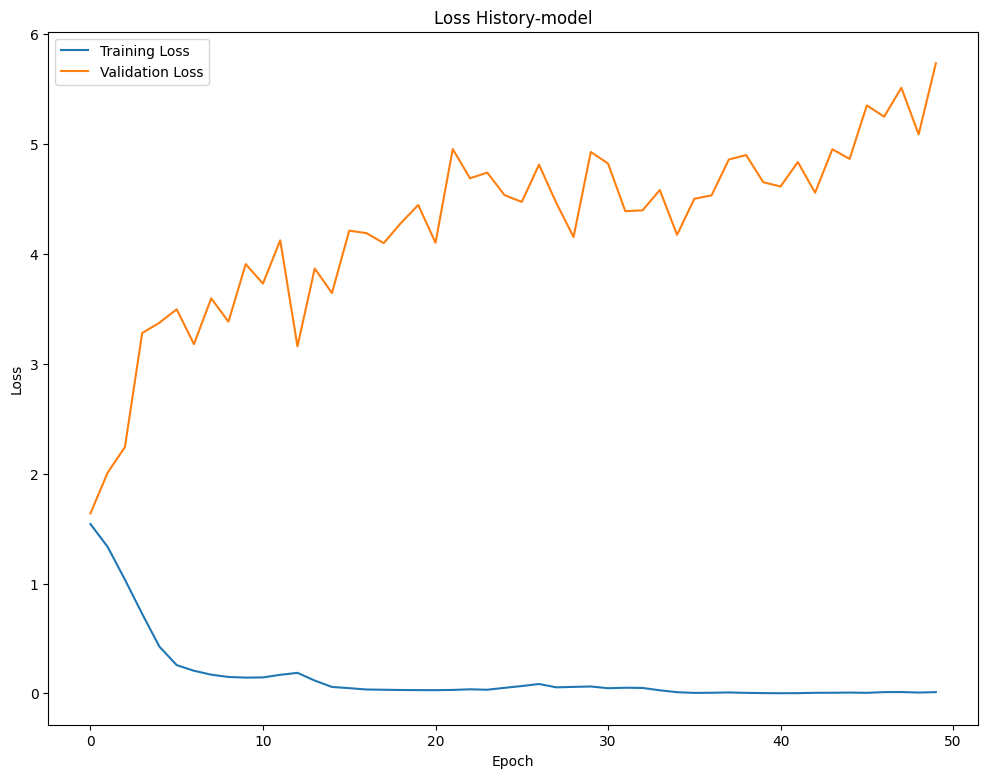

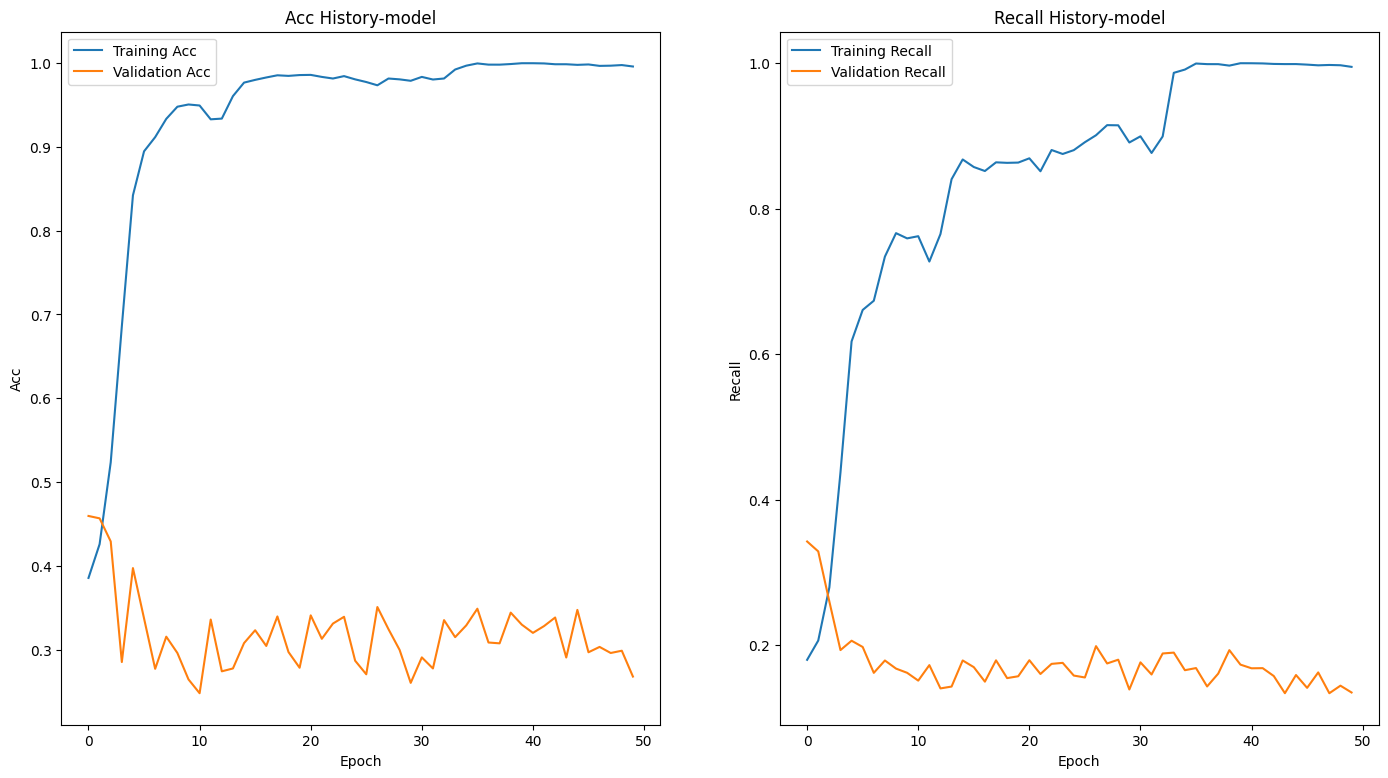

In [65]:
    plt.figure(figsize=(12,9))
"с аттеншеном резнет 50 слабая аугментация"
    plt.plot(history['Train Loss'], label=f'Training Loss')
    plt.plot(history['Valid Loss'], label=f'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss History-model')


    plt.figure(figsize=(17,9))
    plt.subplot(1, 2, 1)
    plt.plot(history['Train Acc'], label=f'Training Acc')
    plt.plot(history['Valid Acc'], label=f'Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.title(f'Acc History-model')

    plt.subplot(1, 2, 2)
    plt.plot(history['Train Recall'], label=f'Training Recall')
    plt.plot(history['Valid Recall'], label=f'Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.title(f'Recall History-model')
    plt.show()

In [166]:
data = []
for seg_model_name, history in history_all_data_type.items():
    train_acc_max = max(history[0]['Train Acc'])
    train_recall_max = max(history[0]['Train Recall'])
    train_loss_min = min(history[0]['Train Loss'])
    val_acc_max = max(history[0]['Valid Acc'])
    val_recall_max = max(history[0]['Valid Recall'])
    val_loss_min = min(history[0]['Valid Loss'])

    data.append([
        seg_model_name[17:], 
        train_acc_max, 
        train_recall_max, 
        train_loss_min, 
        val_acc_max, 
        val_recall_max, 
        val_loss_min
    ])

columns = ['Model', 'Train Acc Max', 'Train Recall Max', 'Train Loss Min', 'Val Acc Max', 'Val Recall Max', 'Val Loss Min']

df = pd.DataFrame(data, columns=columns)

df

Model  Train Acc Max  \
0     _all_classes-mask_false-no_flip-one_sied_r       1.000000   
1       _all_classes-mask_false-no_flip-max_side       0.998698   
2      _all_classes-mask_false-invert-one_sied_r       0.998481   
3        _all_classes-mask_false-invert-max_side       1.000000   
4      _all_classes-mask_true-no_flip-one_sied_r       1.000000   
5        _all_classes-mask_true-no_flip-max_side       1.000000   
6    _group_classes-mask_false-invert-one_sied_r       0.997179   
7       _all_classes-mask_true-invert-one_sied_r       0.999349   
8         _all_classes-mask_true-invert-max_side       1.000000   
9   _group_classes-mask_false-no_flip-one_sied_r       0.999132   
10    _group_classes-mask_false-no_flip-max_side       0.999566   
11     _group_classes-mask_false-invert-max_side       0.999566   
12   _group_classes-mask_true-no_flip-one_sied_r       1.000000   
13     _group_classes-mask_true-no_flip-max_side       1.000000   
14    _group_classes-mask_true-invert-one_sied_r       1.000000   
15      _group_classes-mask_true-invert-max_side       1.000000   

    Train Recall Max  Train Loss Min  Val Acc Max  Val Recall Max  \
0           1.000000        0.001524     0.366809        0.200330   
1           0.999069        0.005561     0.287946        0.277194   
2           0.998873        0.008543     0.388591        0.194567   
3           1.000000        0.001621     0.403045        0.255347   
4           1.000000        0.000977     0.326031        0.293891   
5           1.000000        0.001891     0.739583        0.498656   
6           0.996163        0.008755     0.675758        0.440958   
7           0.999717        0.004557     0.400992        0.303393   
8           1.000000        0.001541     0.484375        0.303501   
9           0.999391        0.004357     0.738839        0.534220   
10          0.999471        0.004958     0.511584        0.402035   
11          0.999477        0.002576     0.475962        0.364201   
12          1.000000        0.000890     0.634375        0.424049   
13          1.000000        0.000428     0.328125        0.252528   
14          1.000000        0.001508     0.734609        0.584102   
15          1.000000        0.000284     0.448750        0.346569   

    Val Loss Min  
0       1.903796  
1       1.925000  
2       1.799973  
3       1.888585  
4       1.838072  
5       1.575658  
6       0.991110  
7       2.076373  
8       1.537094  
9       0.859001  
10      1.092400  
11      1.439788  
12      0.989369  
13      1.474630  
14      1.001697  
15      1.276446

In [165]:
len("Resnet50_50_bs128")

17

In [169]:
def highlight_max(s):
    '''highlight the maximum in a Series yellow.'''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''highlight the minimum in a Series lightblue.'''
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

# Применение стилей
styled_df = df.style.apply(highlight_max, subset=['Train Acc Max', 'Train Recall Max', 'Val Acc Max', 'Val Recall Max']) \
                    .apply(highlight_min, subset=['Train Loss Min', 'Val Loss Min'])



## Exp results

In [170]:
styled_df